# Word sense induction

Goal is to design a system which takes as an input a pair of (word, context) and outputs the sense identifier.

## Import libs

In [ ]:
# Connect to Google Drive and upload a folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/nlpub/russe-wsi-kit.git

Cloning into 'russe-wsi-kit'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 154 (delta 7), reused 28 (delta 6), pack-reused 116
Receiving objects: 100% (154/154), 3.83 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import re # 
import string # For punctuation

### Test

In [ ]:
!python3 /content/russe-wsi-kit/evaluate.py /content/russe-wsi-kit/data/main/wiki-wiki/train.baseline-adagram.csv

word	ari	count
бор	0.591175	56
замок	0.495386	138
лук	0.637076	110
суда	0.005465	135
	0.392449	439


In [ ]:
!python3 /content/russe-wsi-kit/evaluate.py /content/russe-wsi-kit/data/main/bts-rnc/train.baseline-adagram.csv

word	ari	count
балка	0.219333	119
вид	0.174319	77
винт	0.278357	123
горн	0.148054	51
губа	0.011532	137
жаба	0.153284	121
клетка	0.253548	150
крыло	0.232677	91
купюра	0.019886	150
курица	0.303684	93
лавка	0.275710	149
лайка	-0.028626	99
лев	0.227088	44
лира	0.624678	49
мина	0.342283	65
мишень	0.289000	121
обед	0.109923	100
оклад	0.092688	146
опушка	0.141431	148
полис	0.057707	142
пост	0.653152	144
поток	0.059094	136
проказа	0.495533	146
пропасть	0.284520	127
проспект	-0.017906	139
пытка	0.026372	143
рысь	0.641513	120
среда	0.378653	144
хвост	0.120220	121
штамп	0.432813	96
	0.223731	3491


In [ ]:
!python3 /content/russe-wsi-kit/evaluate.py /content/russe-wsi-kit/data/main/active-dict/train.baseline-adagram.csv

word	ari	count
дар	0.052246	36
двигатель	0.904424	15
двойник	-0.018537	25
дворец	-0.004065	13
девятка	0.050212	47
дедушка	0.369427	9
дежурная	0.000000	12
дежурный	-0.028398	13
декабрист	-0.015831	11
декрет	0.664820	12
дело	0.052311	130
демобилизация	-0.058140	14
демократ	0.208723	18
демонстрация	0.042477	38
дерево	0.588235	21
держава	0.092664	15
дерзость	0.044989	37
десятка	0.118856	36
десяток	0.023123	21
деятель	0.190311	14
диалог	0.380952	14
диаметр	0.048164	18
диплом	0.159552	25
директор	0.047936	11
диск	0.134502	63
дичь	0.244444	18
длина	-0.083460	21
доброволец	0.183318	12
добыча	0.228133	35
доказательство	0.067949	24
доктор	0.439893	17
долгота	0.036072	13
доля	0.041822	45
дом	0.153346	38
дорога	0.047524	47
достижение	0.099485	22
древесина	0.122363	16
дупло	0.160305	15
дура	0.437668	12
дух	0.131565	77
дым	0.176240	28
дымка	1.000000	18
дыхание	0.308969	56
дьявол	0.224231	22
евро	-0.028571	8
езда	-0.055072	14
жаворонок	0.635762	11
жало	-0.100000	11
жертва	0.190991	37
жестокость	-0.07

## Import datasets

In [ ]:
# active-dict
# path = './data/main/active-dict/train.csv'

path = '/content/russe-wsi-kit/data/main/active-dict/train.csv'
#path = '/content/russe-wsi-kit/data/main/active-dict/test.csv'

train_ad = pd.read_csv(path, sep='\t', header=0)

#train_ad = pd.read_csv(path, sep='\t', header=0 , skip_blank_lines=False, keep_default_na=True, na_filter=True, na_values = 0)


#train_ad.dropna(subset=['positions'], how='all', inplace=True)
train_ad['positions'] = train_ad['positions'].fillna('nan_my')


In [ ]:
# bts-rnc
# path = './data/main/bts-rnc/train.csv'

#path = '/content/russe-wsi-kit/data/main/bts-rnc/train.csv'
path = '/content/russe-wsi-kit/data/main/bts-rnc/test.csv'


train_br = pd.read_csv(path, sep='\t', header=0)

In [ ]:
# wiki-wiki
# path = 'data/main/wiki-wiki/train.csv'

#path = '/content/russe-wsi-kit/data/main/wiki-wiki/train.csv'
path = '/content/russe-wsi-kit/data/main/wiki-wiki/test.csv'


train_ww = pd.read_csv(path, sep='\t', header=0)

#train_ww.fillna(0)
# values = {"positions": 0}
# train_ww.fillna(value=values)

In [ ]:
train_ad.head(50)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,дар,1,NaN,18-21,Отвергнуть щедрый дар
1,2,дар,1,NaN,21-27,покупать преданность дарами и наградами
2,3,дар,1,NaN,19-22,Вот яд – последний дар моей Изоры
3,4,дар,1,NaN,81-86,Основная функция корильных песен – повеселить ...
4,5,дар,1,NaN,151-156,Но недели две спустя (Алевтина его когда-то об...
5,6,дар,1,NaN,95-98,Мать Ревекки приберегала кусок и на праздник п...
6,7,дар,1,NaN,205-209,Время от времени Лидия Михайловна «доставала» ...
7,8,дар,1,NaN,80-83,Недавно приезжавший в Оргеев посол РФ в Молдав...
8,9,дар,2.1,NaN,18-21,Жизнь – бесценный дар
9,10,дар,2.1,NaN,25-28,Такая любовь – настоящий дар судьбы


In [ ]:
train_br.head()

In [ ]:
train_ww.head()

## Pre-process

### Functions

#### Clean context example

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Rules of cleaning:
    - Convert words to lowercase.
    - Remove ellipsis.
    - Remove dash between words.
    - Remove punctuation.
    - Remove multiple spaces.

In [ ]:
def clean_context(context):

    context = context.lower() # Lowercase words

    context = re.sub(r"…", " ", context) # Remove ellipsis

    context = re.sub(r"\u0301", "", context) # Remove accent mark

    context = re.sub(r"\u0439", "\u0438", context) # Remove jo

    context = re.sub(r"(?<=\w)-(?=\w)", " ", context)  # Replace dash between words

    # Remove punctuation
    context = re.sub(r"[\"\—\#\$\%\&\'\(\)\*\+\,\–\-\/\:\;\<\=\>\?\@\[\\\]\^\?\!\_\`\{\|\}\~\«\»ѣ\№]", " ", context)


    context = re.sub(r"\s+", " ", context) # Remove multiple spaces in content

    return context

In [ ]:
# # Test

text = "Ну что сказать, я виж~!у кто-то насту,пил на граблий…, Ты разочаровал№ меняѣ», ты был натравлен. клеткой"
text = clean_context(text)
print(text)

ну что сказать я виж у кто то насту пил на граблии ты разочаровал меня ты был натравлен. клеткои


### Prepare data

__ad_ = about active-dict

__br_ = about bts-rnc

__ww_ = about wiki_wiki

_unique_senses_list_ = unique senses list of every word in dataset

#### Active-Dict

In [ ]:
train_ad.shape

(2073, 6)

In [ ]:
unique_senses_list_ad = []
unique_senses_list_ad = [train_ad[train_ad['word'] == value].gold_sense_id.nunique() for value in train_ad.word.unique()]

print(len(unique_senses_list_ad))
for ind, i in enumerate(unique_senses_list_ad):
    print('\''+train_ad.word.unique()[ind]+'\'', 'has', i, 'unique senses')

85
'дар' has 3 unique senses
'двигатель' has 2 unique senses
'двойник' has 4 unique senses
'дворец' has 2 unique senses
'девятка' has 9 unique senses
'дедушка' has 2 unique senses
'дежурная' has 2 unique senses
'дежурный' has 2 unique senses
'декабрист' has 2 unique senses
'декрет' has 2 unique senses
'дело' has 17 unique senses
'демобилизация' has 2 unique senses
'демократ' has 3 unique senses
'демонстрация' has 5 unique senses
'дерево' has 3 unique senses
'держава' has 2 unique senses
'дерзость' has 7 unique senses
'десятка' has 7 unique senses
'десяток' has 2 unique senses
'деятель' has 2 unique senses
'диалог' has 2 unique senses
'диаметр' has 3 unique senses
'диплом' has 4 unique senses
'директор' has 2 unique senses
'диск' has 10 unique senses
'дичь' has 3 unique senses
'длина' has 3 unique senses
'доброволец' has 2 unique senses
'добыча' has 6 unique senses
'доказательство' has 3 unique senses
'доктор' has 2 unique senses
'долгота' has 2 unique senses
'доля' has 7 unique senses


In [ ]:
train_ad.context[1]

'покупать преданность дарами и наградами'

In [ ]:
clean_context(train_ad.context[1])

'покупать преданность дарами и наградами'

##### Save word variationss

In [ ]:
word_variations_ad = []

nans = 0
bad_words = 0
for id, text in enumerate(train_ad["context"]):
  
  #print(id)
  #print(train_ad.word[id])

  if id == 0:
    word_variations_ad_word = set()

  elif (train_ad.word[id] != train_ad.word[id-1]):
    word_variations_ad.append(word_variations_ad_word)
    word_variations_ad_word = set()

  #if id < 5:
  #print(train_ad.positions[id])
  if train_ad.positions[id] != 'nan_my': #isnull()):
    #print("lolol___")
    positions = list(train_ad.positions[id].split(","))

    for id_pos, position in enumerate(positions):
      position_str = list(position.split("-"))
      position_start, position_end = int(position_str[0]), int(position_str[1])
      #print(position_start, position_end)

      word = text[position_start:position_end]

      word = word.lower()
      # print(word)

      #if word[0:2] != train_ad.word[id][0:2]:
      if word[0:1] != train_ad.word[id][0:1]:
        #print(f'[LOG] Instead of "{train_ad.word[id]}" got "{word}" at line "{id}"')
        word = train_ad.word[id]
        bad_words+=1

      #word = re.sub(r"(?<=\w)\u0301(?=\w)", "", word) # Remove accent mark
      word = re.sub(r"\u0301", "", word) # Remove accent mark
      word = re.sub(r"\u0439", "\u0438", word) # Remove jo

      word = re.sub(r"[\"\—\#\$\%\&\'\(\)\*\+\,\–\-\/\:\;\<\=\>\?\@\[\\\]\^\?\!\_\`\{\|\}\~\«\»ѣ\№]", "", word)

      # if id_pos == 0:
      #   word_variations_ad.append( {word} )
      # else: 
      word_variations_ad_word.add(word)
  else:
    #print("bruh")
    nans += 1


print(f'[INFO] Number of bad words: {bad_words}')
print(f'[INFO] Number of nans in positions: {nans}')

word_variations_ad.append(word_variations_ad_word)
print(word_variations_ad)


[INFO] Number of bad words: 1
[INFO] Number of nans in positions: 45
[{'дары', 'дар', 'дарам', 'дарами', 'даров', 'даром'}, {'двигатель', 'двигателя', 'двигателеи'}, {'двоиниками', 'двоиник', 'двоиников', 'двоиники', 'двоиника', 'двоиником'}, {'дворцы', 'дворцов', 'дворцом', 'дворца', 'дворец'}, {'девяток', 'девятками', 'девяткои', 'девятку', 'девятка', 'девятке', 'девятки'}, {'дедушкои', 'дедушка', 'дедушки'}, {'дежурная', 'дежурнои'}, {'дежурным', 'дежурные', 'дежурного', 'дежурныи', 'дежурных'}, {'декабристы', 'декабрист', 'декабристов', 'декабриста'}, {'декрет', 'декрета', 'декрету', 'декретом'}, {'дело', 'делами', 'деле', 'делу', 'делам', 'делом', 'дела', 'дел'}, {'демобилизация', 'демобилизации', 'демобилизациеи', 'демобилизацию'}, {'демократом', 'демократов', 'демократ', 'демократа', 'демократы'}, {'демонстрацию', 'демонстрации', 'демонстрациеи', 'демонстрация'}, {'деревом', 'деревья', 'деревьев', 'дереве', 'дерево', 'дерева', 'деревьях'}, {'державы', 'державу', 'державои', 'дер

In [ ]:
train_ad['text'] = train_ad.context
train_ad['text'] = [clean_context(train_ad.context[i]) for i in range(train_ad.shape[0])]

train_ad

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,1,дар,1,NaN,18-21,Отвергнуть щедрый дар,отвергнуть щедрыи дар
1,2,дар,1,NaN,21-27,покупать преданность дарами и наградами,покупать преданность дарами и наградами
2,3,дар,1,NaN,19-22,Вот яд – последний дар моей Изоры,вот яд последнии дар моеи изоры
3,4,дар,1,NaN,81-86,Основная функция корильных песен – повеселить ...,основная функция корильных песен повеселить уч...
4,5,дар,1,NaN,151-156,Но недели две спустя (Алевтина его когда-то об...,но недели две спустя алевтина его когда то об ...
...,...,...,...,...,...,...,...
2068,2069,зонт,1,NaN,85-90,"Такая погода легко переживается весной, а вот ...",такая погода легко переживается веснои а вот о...
2069,2070,зонт,2,NaN,8-12,Пляжный зонт,пляжныи зонт
2070,2071,зонт,2,NaN,18-24,сидеть в кафе под зонтом,сидеть в кафе под зонтом
2071,2072,зонт,2,NaN,21-28,"Cтолики под широкими зонтами, несколько привин...",cтолики под широкими зонтами несколько привинч...


#### Bts-Rnc

In [ ]:
train_br.shape

(6556, 6)

In [ ]:
unique_senses_list_br = []
unique_senses_list_br = [train_br[train_br['word'] == value].gold_sense_id.nunique() for value in train_br.word.unique()]

print(len(unique_senses_list_br))
for ind, i in enumerate(unique_senses_list_br):
    print('\''+train_br.word.unique()[ind]+'\'', 'has', i, 'unique senses')

51
'акция' has 0 unique senses
'баба' has 0 unique senses
'байка' has 0 unique senses
'бум' has 0 unique senses
'бычок' has 0 unique senses
'вал' has 0 unique senses
'газ' has 0 unique senses
'гвоздика' has 0 unique senses
'гипербола' has 0 unique senses
'град' has 0 unique senses
'гусеница' has 0 unique senses
'дождь' has 0 unique senses
'домино' has 0 unique senses
'забой' has 0 unique senses
'икра' has 0 unique senses
'кабачок' has 0 unique senses
'капот' has 0 unique senses
'карьер' has 0 unique senses
'кличка' has 0 unique senses
'ключ' has 0 unique senses
'кок' has 0 unique senses
'кольцо' has 0 unique senses
'концерт' has 0 unique senses
'котелок' has 0 unique senses
'крона' has 0 unique senses
'круп' has 0 unique senses
'кулак' has 0 unique senses
'лейка' has 0 unique senses
'лук' has 0 unique senses
'мандарин' has 0 unique senses
'ножка' has 0 unique senses
'опора' has 0 unique senses
'патрон' has 0 unique senses
'печать' has 0 unique senses
'пол' has 0 unique senses
'полоз' h

In [ ]:
train_br.context[1]

'пакет акций. «Все зависит от того, насколько реально компания сама оценит свои акции», – сказал в разговоре с RBC daily аналитик ИК «АТОН» Алексей Языков. Однако,'

In [ ]:
clean_context(train_br.context[1])

'пакет акции. все зависит от того насколько реально компания сама оценит свои акции сказал в разговоре с rbc daily аналитик ик атон алексеи языков. однако '

##### Save word variationss

In [ ]:
word_variations_br = []


bad_words = 0
for id, text in enumerate(train_br["context"]):

  if id == 0:
    word_variations_br_word = set()

  elif (train_br.word[id] != train_br.word[id-1]):
    word_variations_br.append(word_variations_br_word)
    word_variations_br_word = set()

  #if id < 5:
  positions = list(train_br.positions[id].split(","))

  for id_pos, position in enumerate(positions):
    position_str = list(position.split("-"))
    position_start, position_end = int(position_str[0]), int(position_str[1])
    #print(position_start, position_end)

    word = text[position_start:position_end]

    #if word[0:2] != train_br.word[id][0:2]:
    if word[0:1] != train_br.word[id][0:1]:
      
      #print(f'[LOG] Instead of "{train_br.word[id]}" got "{word}" at line "{id}"')
      word = train_br.word[id]
      bad_words+=1

    #word = re.sub(r"(?<=\w)\u0301(?=\w)", "", word) # Remove accent mark
    word = re.sub(r"\u0301", "", word) # Remove accent mark
    word = re.sub(r"\u0439", "\u0438", word) # Remove jo

    word = re.sub(r"[\"\—\#\$\%\&\'\(\)\*\+\,\–\-\/\:\;\<\=\>\?\@\[\\\]\^\?\!\_\`\{\|\}\~\«\»ѣ\№]", "", word)


    # if id_pos == 0:
    #   word_variations_br.append( {word} )
    # else: 
    word_variations_br_word.add(word)


print(f'[INFO] Number of bad words: {bad_words}')

word_variations_br.append(word_variations_br_word)
print(word_variations_br)


[INFO] Number of bad words: 526
[{'акция', 'акцию', 'акциям', 'акциеи', 'акции', 'акциями', 'акциях'}, {'баба', 'бабами', 'бабы', 'бабу', 'баб', 'бабе', 'бабои'}, {'баике', 'баек', 'баики', 'баика', 'баиками', 'баику', 'баикои'}, {'бума', 'буме', 'бум', 'бумом'}, {'бычок', 'бычку', 'бычке', 'бычков', 'бычками', 'бычка', 'бычках', 'бычки', 'бычком'}, {'валом', 'валов', 'валах', 'валами', 'вал', 'валы', 'вала', 'валу'}, {'газами', 'газы', 'газа', 'газу', 'газ', 'газом', 'газе', 'газам', 'газов'}, {'гвоздик', 'гвоздиках', 'гвоздики', 'гвоздикою', 'гвоздику', 'гвоздиками', 'гвоздикои', 'гвоздика'}, {'гипербол', 'гиперболои', 'гиперболами', 'гиперболу', 'гиперболах', 'гиперболам', 'гиперболы', 'гиперболе', 'гипербола'}, {'граде', 'грады', 'града', 'градам', 'градом', 'град', 'граду', 'градах'}, {'гусеницеи', 'гусеницам', 'гусенице', 'гусениц', 'гусеницами', 'гусеницы', 'гусеницамъ', 'гусеницу', 'гусеница', 'гусеницах'}, {'дождеи', 'дожди', 'дождя', 'дождю', 'дожде', 'дождями', 'дождем', 'до

In [ ]:
train_br['text'] = train_br.context
train_br['text'] = [clean_context(train_br.context[i]) for i in range(train_br.shape[0])]

train_br

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,3492,акция,NaN,NaN,104-109,"точными сведениями осенью. Напомним, что снача...",точными сведениями осенью. напомним что сначал...
1,3493,акция,NaN,NaN,"6-11,79-84","пакет акций. «Все зависит от того, насколько р...",пакет акции. все зависит от того насколько реа...
2,3494,акция,NaN,NaN,"70-75,119-124","в ЕГРЮЛ только 5 октября 2012 года, а госрегис...",в егрюл только 5 октября 2012 года а госрегист...
3,3495,акция,NaN,NaN,67-72,"8%, а бумаги Дальсвязи подорожали на 4,4%. Вме...",8 а бумаги дальсвязи подорожали на 4 4 . вмест...
4,3496,акция,NaN,NaN,90-95,", пожилые - у нас много категорий граждан, кот...",пожилые у нас много категории граждан которым...
...,...,...,...,...,...,...,...
6551,10043,шашка,NaN,NaN,64-71,"1, 2, 3, 4 приведена в порядок, и при дальнейш...",1 2 3 4 приведена в порядок и при дальнеиших м...
6552,10044,шашка,NaN,NaN,86-91,"весело, были одеты щеголями и распоряжались ра...",весело были одеты щеголями и распоряжались раз...
6553,10045,шашка,NaN,NaN,103-110,"подол, как звереныши, поглядывали блестящими г...",подол как звереныши поглядывали блестящими гла...
6554,10046,шашка,NaN,NaN,101-106,", случавшиеся с монументом Чапаеву, у которого...",случавшиеся с монументом чапаеву у которого с...


#### Wiki-Wiki

In [ ]:
train_ww.shape

(618, 6)

In [ ]:
unique_senses_list_ww = []
unique_senses_list_ww = [train_ww[train_ww['word'] == value].gold_sense_id.nunique() for value in train_ww.word.unique()]

print(len(unique_senses_list_ww))
for ind, i in enumerate(unique_senses_list_ww):
    print('\''+train_ww.word.unique()[ind]+'\'', 'has', i, 'unique senses')

6
'банка' has 0 unique senses
'белка' has 0 unique senses
'бит' has 0 unique senses
'горе' has 0 unique senses
'граф' has 0 unique senses
'душ' has 0 unique senses


In [ ]:
train_ww.context[1]

'трехлитровая банка во времена ссср такие банки были популярны для маринованных овощей , овощных и фруктовых соков и так далее . популярность трехлитровых банок объясняется тем , что это самая объемная банка из массово доступных , и это удобно при большом объеме заготовок . в наши дни стеклянные банки продолжают использоваться в быту для домашнего консервирования . подготовка абсолютно целых ( без трещин и сколов ) стеклянных банок подразумевает не только тщательное мытье внутри и снаружи слабым'

In [ ]:
clean_context(train_ww.context[1])

'трехлитровая банка во времена ссср такие банки были популярны для маринованных овощеи овощных и фруктовых соков и так далее . популярность трехлитровых банок объясняется тем что это самая объемная банка из массово доступных и это удобно при большом объеме заготовок . в наши дни стеклянные банки продолжают использоваться в быту для домашнего консервирования . подготовка абсолютно целых без трещин и сколов стеклянных банок подразумевает не только тщательное мытье внутри и снаружи слабым'

##### Save word variationss

In [ ]:
word_variations_ww = []


bad_words = 0
for id, text in enumerate(train_ww["context"]):

  if id == 0:
    word_variations_ww_word = set()

  elif (train_ww.word[id] != train_ww.word[id-1]):
    word_variations_ww.append(word_variations_ww_word)
    word_variations_ww_word = set()

  #if id < 5:
  positions = list(train_ww.positions[id].split(","))

  for id_pos, position in enumerate(positions):
    position_str = list(position.split("-"))
    position_start, position_end = int(position_str[0]), int(position_str[1])
    #print(position_start, position_end)

    word = text[position_start:position_end]

    #if word[0:2] != train_ww.word[id][0:2]:
    if word[0:1] != train_ww.word[id][0:1]:
      
      #print(f'[LOG] Instead of "{train_ww.word[id]}" got "{word}" at line "{id}"')
      word = train_ww.word[id]
      bad_words+=1

    #word = re.sub(r"(?<=\w)\u0301(?=\w)", "", word) # Remove accent mark
    word = re.sub(r"\u0301", "", word) # Remove accent mark
    word = re.sub(r"\u0439", "\u0438", word) # Remove jo

    word = re.sub(r"[\"\—\#\$\%\&\'\(\)\*\+\,\–\-\/\:\;\<\=\>\?\@\[\\\]\^\?\!\_\`\{\|\}\~\«\»ѣ\№]", "", word)


    # if id_pos == 0:
    #   word_variations_ww.append( {word} )
    # else: 
    word_variations_ww_word.add(word)


print(f'[INFO] Number of bad words: {bad_words}')

word_variations_ww.append(word_variations_ww_word)
print(word_variations_ww)


[INFO] Number of bad words: 4
[{'банка', 'банкои', 'банок', 'банками', 'банку', 'банки', 'банке'}, {'белка', 'белкои', 'белки'}, {'битов', 'бит', 'бита'}, {'горя', 'горе'}, {'графом', 'графов', 'графы', 'графами', 'графам', 'графа', 'граф'}, {'душ'}]


In [ ]:
train_ww['text'] = train_ww.context
train_ww['text'] = [clean_context(train_ww.context[i]) for i in range(train_ww.shape[0])]

train_ww

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,440,банка,NaN,NaN,"7-12,36-41",здание банка китая ( макао ) здание банка кита...,здание банка китая макао здание банка китая ba...
1,441,банка,NaN,NaN,"201-206,154-159,429-434,13-18",трехлитровая банка во времена ссср такие банки...,трехлитровая банка во времена ссср такие банки...
2,442,банка,NaN,NaN,"58-63,21-26,263-268,101-106",здание национального банка украины в здании на...,здание национального банка украины в здании на...
3,443,банка,NaN,NaN,"261-266,343-348,134-139",зюдфиртель города эссен ( федеральная земля се...,зюдфиртель города эссен федеральная земля севе...
4,444,банка,NaN,NaN,"43-48,521-526,300-307,381-386",ведения боевых действий полевые учреждения бан...,ведения боевых деиствии полевые учреждения бан...
...,...,...,...,...,...,...,...
613,1073,душ,NaN,NaN,"324-327,404-407","вайзард . по стечению обстоятельств , ичиго ку...",ваизард . по стечению обстоятельств ичиго куро...
614,1074,душ,NaN,NaN,286-289,подлые способности . использовал его дважды — ...,подлые способности . использовал его дважды во...
615,1075,душ,NaN,NaN,260-263,"ему было более шестидесяти лет , и это сочинен...",ему было более шестидесяти лет и это сочинение...
616,1076,душ,NaN,NaN,"436-439,565-568,323-326",имеет начиненные ядом лезвия у подбородка с ме...,имеет начиненные ядом лезвия у подбородка с ме...


## Word embedding

#### BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 182 kB 63.5 MB/s 
     |████████████████████████████████| 7.6 MB 41.0 MB/s 


###### Create a model:

In [ ]:
from transformers import BertTokenizer, BertModel


def setup_model(word_variations=[], never_split_check=False):

  if never_split_check:
    if word_variations:
      word_variations_all = list(set().union(*word_variations))
      print(word_variations_all)

    else:
      ##word_variations_ww_all = list(set().union(*word_variations_ww))
      #word_variations_all = list(set().union(*word_variations_br)) # word_variations_ww
      word_variations_all = []

  else:
    word_variations_all = []


  tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=True, do_basic_tokenize=True, never_split=word_variations_all,
                                            clean_text=True, handle_chinese_chars=False) # never_split=['Replace'])
  # tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=True, do_basic_tokenize=True, never_split=word_variations_all,
  #                                           clean_text=False, handle_chinese_chars=False) # never_split=['Replace'])

  model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased")
  
  model.eval()


  return tokenizer, model

In [ ]:
tokenizer, model = setup_model(word_variations_ad, never_split_check=True)


['жилы', 'езда', 'дар', 'дыму', 'заложников', 'заголовком', 'добычи', 'диалогов', 'зеркалом', 'дворец', 'дуплах', 'долями', 'девятками', 'завещанием', 'жаворонка', 'закона', 'диалог', 'добыча', 'западнеи', 'десятка', 'закрытии', 'законы', 'декрету', 'завещания', 'заголовками', 'дары', 'длине', 'двоиник', 'дворца', 'дереве', 'знаку', 'заголовка', 'дарами', 'дежурная', 'дежурного', 'захоронении', 'задачами', 'дерзостеи', 'деятеля', 'девятке', 'знаменем', 'духи', 'заведением', 'зонты', 'дисками', 'директором', 'диаметром', 'затруднении', 'запятая', 'дежурныи', 'дорог', 'замене', 'задач', 'жертвои', 'деятели', 'задачи', 'звезды', 'демократом', 'жестокость', 'замены', 'диски', 'запятую', 'диаметре', 'диске', 'духа', 'значение', 'дупле', 'задачеи', 'заложниками', 'значениях', 'жертвы', 'деревьях', 'затеях', 'доля', 'добычеи', 'декрета', 'дело', 'древесины', 'дежурным', 'деятеле', 'жилу', 'знамен', 'дыханию', 'значением', 'езды', 'звонами', 'доказательство', 'жестокости', 'жильцам', 'декабрис

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer_helper, model_helper = setup_model()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


###### Embedding extraction:

In [ ]:
import torch
import numpy as np

print_info = True #True
print_info_extra = False #False

replace_word_variations = True

all_representations = []
word_variations_ad_original = word_variations_ad.copy()

bad_words_total = 0

word_id = 0

for id, text in enumerate(train_ad["text"]):
#for id, text in enumerate(train_ww["text"]):
#for id, text in enumerate(train_br["text"]):

  #if id < 50: # > 382: #247: #137:

    if print_info: print(text)
    #print(len(text))
    # text_list = text.split(" ")
    # print(text_list)
    # print(len(text_list))


    ## Check if the field for a position of the main word in a senetnce was "NaN" in the dataset:
    nan_value = False
    if train_ad.positions[id] == 'nan_my':
      nan_value = True
      print("[INFO] Prepending a main word to a line with nan word positions.")

      text = ' '.join((train_ad.word[id], text))

      print("New text with prepended main word:")
      print(text)
      

    ## Check if the main word has been changed:
      # Exception is to capture the (id-1) indexing error when id == 0
    try:
      next_word = (train_ad.word[id] != train_ad.word[id-1])
    except KeyError:
      next_word = False
    # else:
    #   next_word = True
    if print_info_extra: next_word


    ## Check if the main word is not found:
    if id == 0 or next_word:
      print("--- Next word ---")

      if (id != 0) and next_word:
        word_id += 1

      ##text_test = ' '.join([train_ww.word[id], text])
      
      text_test = train_ad.word[id]
      #text_test = train_ww.word[id]
      #text_test = train_br.word[id]

      #print(text_test)

      encoded_input_test_word = tokenizer(text_test) #, unk_token='замок') #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
      encoded_sequence_test_word = encoded_input_test_word["input_ids"]    
      world_main_id = encoded_sequence_test_word[1] # id of the pre-pended main word
      if print_info: print(world_main_id)


      if world_main_id == 100 or world_main_id == '[UNK]':
        #raise Exception(f"[ERROR My] The main word at line {id} is Unknown [UNK]")
        print(f"[ERROR My] The main word at line {id} is Unknown [UNK]")
        bad_words_total +=1
        world_main_id_text = tokenizer.convert_ids_to_tokens(world_main_id)

        print(train_ad.word[id])
        #print(train_ww.word[id])
        #print(train_br.word[id])
      
        print(world_main_id_text)


        encoded_world_main_id = tokenizer_helper(train_ad.word[id]) #, unk_token='замок') #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
        #encoded_world_main_id = tokenizer_helper(train_ww.word[id]) #, unk_token='замок') #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
        #encoded_world_main_id = tokenizer_helper(train_br.word[id]) #, unk_token='замок') #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
        
        world_main_id_separated = encoded_world_main_id["input_ids"]
        print(world_main_id_separated)

        # Setup new main word id:
        world_main_id = world_main_id_separated[1] # id of the pre-pended main word
        #world_main_id = world_main_id_separated[1:-1] # id of the pre-pended main word

        if print_info: print("New main word main ID:", world_main_id)


        world_main_id_separated_text = tokenizer_helper.convert_ids_to_tokens(world_main_id_separated)
        print(world_main_id_separated_text)


        separated_word = world_main_id_separated_text[1]
        print(separated_word)

        #replace_word_set = separated_word
        #print(replace_word_set)


        word_variations_ad[word_id].add(separated_word)
        print(word_variations_ad[word_id])
        print(word_variations_ad)

        # word_variations_ww[word_id].add(separated_word)
        # print(word_variations_ww)

        #word_variations_br[word_id].add(separated_word)
        #print(word_variations_br)


        tokenizer, model = setup_model(word_variations_ad, never_split_check=True)
        #tokenizer, model = setup_model(word_variations_ww, never_split_check=True)
        #tokenizer, model = setup_model(word_variations_br, never_split_check=True)


        # ## Setup new main word id:
        # encoded_input_test_word = tokenizer(text_test) #, unk_token='замок') #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
        # encoded_sequence_test_word = encoded_input_test_word["input_ids"]    
        # world_main_id = encoded_sequence_test_word[1] # id of the pre-pended main word
        # if print_info: print("New main word main ID:", world_main_id)



    if replace_word_variations:
      if print_info_extra: print("Text before:", text)

      text_list = text.split(" ")
      #print(text_list)

      for id_w, word_w in enumerate(text_list):
        #print(word_variations_ad[word_id])
        if word_w in word_variations_ad_original[word_id]:
          if print_info: print(word_w)
          text_list[id_w] = train_ad.word[id]
      #print(text_list)

      text = ' '.join([str(word_t) for word_t in text_list])
      if print_info_extra: print("Text after:", text)



    encoded_input_test = tokenizer(text) #, unk_token='замок') #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
    encoded_sequence_test = encoded_input_test["input_ids"]
    #print(encoded_sequence_test)

    ##encoded_sequence_test[encoded_sequence_test==119] = 102
    encoded_sequence_test = [102 if item == 132 else item for item in encoded_sequence_test] #119 [SEP]
    #print(encoded_sequence_test)
    
    encoded_sequence_test = [world_main_id if item == 100 else item for item in encoded_sequence_test] # main word [UNK]
    
    #encoded_sequence_test = [encoded_sequence_test[id_seq:id_seq] = world_main_id if item == 100 else item for id_seq, item in enumerate(encoded_sequence_test)]
    #a[5:5] = range(10, 13)

    if print_info: print(encoded_sequence_test)

    words_all = tokenizer.convert_ids_to_tokens(encoded_sequence_test)
    if print_info: print(words_all)


    if id == 0 or next_word:
      #word_id =+ 1

      if next_word:
        print(len(word_representations))
        all_representations.append(word_representations)

      word_representations = []
      # word_id = 0
      #sentence_id = 0

      ##words_all = tokenizer.convert_ids_to_tokens(encoded_sequence_test)      
      
      words_allowed = word_variations_ad[word_id]
      #words_allowed = word_variations_ww[word_id]
      #words_allowed = word_variations_br[word_id]      

      if print_info: print(words_allowed)

      #word_id += 1

      if not words_allowed: # if words_allowed is empty
        raise Exception(f"[ERROR My] Allowed main words were not recongnised for word '{train_ad.word[id]}' at id '{id}'.")


    words_allowed.add('[UNK]')
    indices = []
    #words_all_list = words_all.split(" ")
    #if print_info: print(words_all)
    #print(len(words_all))


    for word in words_allowed:
        if print_info_extra: print(word)
        if print_info_extra: print(words_all)

        # if word == '[UNK]':
        #   indices_unk = {i for i, x in enumerate(words_all) if x == word}
        #indices.append([i for i, x in enumerate(words_all) if x == word])
        indices.append({i for i, x in enumerate(words_all) if x == word})
    
    if print_info_extra: print(indices)
    indices = list(set().union(*indices))
    if print_info_extra: print(indices)



    if not indices:
      print(indices)

      if nan_value:        
        if print_info: print("[INFO] Processing a line with nan replaced to the main word.")


      if print_info: print("[INFO] Adding crop of the main word if the current modified word is not allowed.")
      world_main_id_text = tokenizer.convert_ids_to_tokens(world_main_id)
      if print_info: print("New added main word:", world_main_id_text)

      words_allowed.add( world_main_id_text )
      if print_info: print(words_allowed)


      word_variations_ad[word_id].add(world_main_id_text)
      print(word_variations_ad[word_id])
      print(word_variations_ad)

      tokenizer, model = setup_model(word_variations_ad, never_split_check=True)


      indices = []
      for word in words_allowed:
          if print_info_extra: print(word)
          if print_info_extra: print(words_all)

          # if word == '[UNK]':
          #   indices_unk = {i for i, x in enumerate(words_all) if x == word}
          #indices.append([i for i, x in enumerate(words_all) if x == word])
          indices.append({i for i, x in enumerate(words_all) if x == word})
      
      if print_info_extra: print(indices)
      indices = list(set().union(*indices))
      if print_info: print("New indices:", indices)


      if not indices:
        #else:
        raise Exception(f"[ERROR My] No main word found at line {id}. Please, check if there is a required word in that line.")



    encoded_input = tokenizer(text, return_tensors='pt')#, unk_token='замок') #, never_split=['Replace']) # do_basic_tokenize=True
    #encoded_input = tokenizer.basic_tokenizer(text, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
    #print(encoded_input)

    encoded_sequence = encoded_input["input_ids"]
    #print(encoded_sequence)

    replace_dot = True
    pavlolv_rubert_model = True
    if replace_dot:
      if pavlolv_rubert_model:
        encoded_sequence[encoded_sequence==132] = 102
      else:
        encoded_sequence[encoded_sequence==119] = 102
      #print(encoded_sequence)

    replace_unk = True
    if replace_unk:
      #print("______________________________")
      encoded_sequence[encoded_sequence==100] = world_main_id
      
      #encoded_sequence[encoded_sequence==100] = torch.cat([ encoded_sequence[encoded_sequence==100], torch.tensor(world_main_id)], dim=1)
      #encoded_sequence = torch.cat([ encoded_sequence[encoded_sequence==100], torch.tensor(world_main_id)], dim=1)

      #print(encoded_sequence)
      #print(encoded_input["input_ids"])


    output = model(**encoded_input)
    #print(output)
    #print(output.last_hidden_state.size())
    #print(output.last_hidden_state)


    #cls_representation = output.last_hidden_state[:,0,:]
    #print(cls_representation.size())

    tokens_representation = output.last_hidden_state[:,:,:] #[:,1:-1,:]
    if print_info: print(tokens_representation.size())

    indices_uns = torch.as_tensor(indices)
    #print(indices_uns)
    
    indices, _ = torch.sort(indices_uns)
    if print_info: print(indices)


    tokens_representation_allowed = torch.index_select(tokens_representation, 1, indices)
    #print(tokens_representation_allowed)
    if print_info: print(tokens_representation_allowed.size())


    tokens_representation_allowed_np = tokens_representation_allowed[0, :, :].cpu().detach().numpy()
    if print_info: print(tokens_representation_allowed_np.shape)

    word_representations.append(tokens_representation_allowed_np)

    if print_info: print()


print(len(word_representations))
all_representations.append(word_representations)
print(len(all_representations))

print("Number of bad words:", bad_words_total)

отвергнуть щедрыи дар
--- Next word ---
12332
дар
[101, 76294, 896, 59555, 880, 852, 12332, 102]
['[CLS]', 'отвергнут', '##ь', 'щедр', '##ы', '##и', 'дар', '[SEP]']
{'дары', 'дар', 'дарам', 'дарами', 'даров', 'даром'}
torch.Size([1, 8, 768])
tensor([6])
torch.Size([1, 1, 768])
(1, 768)

покупать преданность дарами и наградами
дарами
[101, 39215, 70233, 12332, 851, 47402, 102]
['[CLS]', 'покупать', 'преданность', 'дар', 'и', 'наградами', '[SEP]']
torch.Size([1, 7, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

вот яд последнии дар моеи изоры
дар
[101, 19030, 17470, 4522, 10781, 12332, 63446, 852, 52663, 3098, 102]
['[CLS]', 'вот', 'яд', 'послед', '##нии', 'дар', 'мое', '##и', 'изо', '##ры', '[SEP]']
torch.Size([1, 11, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

основная функция корильных песен повеселить участников свадьбы и побудить их к дарам
дарам
[101, 25372, 25898, 3337, 30062, 13948, 45546, 56492, 896, 13121, 34425, 851, 54039, 2603, 3806, 861, 12332, 102]
['[CLS]', '

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


двоиники
[101, 20034, 1997, 875, 10271, 15029, 29941, 6818, 41283, 102]
['[CLS]', 'говорят', 'что', 'у', 'многих', 'известных', 'политиков', 'есть', 'дво', '[SEP]']
15
{'двоиниками', 'двоиник', 'двоиников', 'двоиники', 'дво', 'двоиника', 'двоиником'}
torch.Size([1, 10, 768])
tensor([8])
torch.Size([1, 1, 768])
(1, 768)

говорят что на конкурсе двоиников чарли чаплина сам чаплин занял лишь третье место
двоиников
[101, 20034, 1997, 1469, 19892, 41283, 34358, 1698, 60885, 41189, 2058, 3248, 60885, 41189, 858, 11532, 7433, 19104, 5761, 102]
['[CLS]', 'говорят', 'что', 'на', 'конкурсе', 'дво', 'чар', '##ли', 'ча', '##пли', '##на', 'сам', 'ча', '##пли', '##н', 'занял', 'лишь', 'третье', 'место', '[SEP]']
torch.Size([1, 20, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

похитить чертежи и аппарат не удалось потому что бездельники нанятые семеновым убили не гарина а его двоиника
двоиника
[101, 69676, 71559, 851, 13128, 1699, 9111, 13496, 1997, 26192, 64383, 852, 56246, 2604, 104897, 11170

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


девятка
[101, 15987, 86501, 2784, 9545, 102]
['[CLS]', 'девят', 'нечет', '##ное', 'число', '[SEP]']
13
{'девяток', 'девятками', 'девяткои', 'девятку', 'девят', 'девятка', 'девятке', 'девятки'}
torch.Size([1, 6, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

поставить на девятку
девятку
[101, 27942, 1469, 15987, 102]
['[CLS]', 'поставить', 'на', 'девят', '[SEP]']
torch.Size([1, 5, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

считать девятками
девятками
[101, 19635, 15987, 102]
['[CLS]', 'считать', 'девят', '[SEP]']
torch.Size([1, 4, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

число семь указывает скорее на то что интересующая вас фраза имеет исламское происхождение. точнее арабское. турки и татары отдают первенство девятке
девятке
[101, 9545, 9075, 20328, 17254, 1469, 3815, 1997, 9294, 19012, 26212, 43195, 7497, 15601, 4064, 22644, 102, 38592, 84182, 102, 39034, 851, 34920, 75947, 33048, 15987, 102]
['[CLS]', 'число', 'семь', 'указывает', 'скорее', 'на', 'то', 'что',

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


дежурнои
[101, 7974, 29526, 1997, 3815, 65937, 10380, 19226, 69613, 861, 26407, 102]
['[CLS]', 'если', 'вам', 'что', 'то', 'понадобится', 'обращ', '##аи', '##тесь', 'к', 'дежур', '[SEP]']
9
{'дежур', 'дежурная', 'дежурнои'}
torch.Size([1, 12, 768])
tensor([10])
torch.Size([1, 1, 768])
(1, 768)

дежурная распоряжается кому в каком порядке выступать
дежурная
[101, 26407, 15135, 3032, 23938, 845, 30134, 17272, 19034, 102]
['[CLS]', 'дежур', 'распоряж', '##ается', 'кому', 'в', 'каком', 'порядке', 'выступать', '[SEP]']
torch.Size([1, 10, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

я в пансионе дежурнои была в кухне изжарила начальнице котлету из жеванои бумаги 
[INFO] Prepending a main word to a line with nan word positions.
New text with prepended main word:
дежурная я в пансионе дежурнои была в кухне изжарила начальнице котлету из жеванои бумаги 
дежурная
дежурнои
[101, 26407, 877, 845, 93232, 26407, 3370, 845, 56318, 1703, 62835, 3297, 8445, 14816, 104589, 9227, 1703, 77481, 5709

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


дежурныи
[101, 861, 12550, 57753, 26407, 1516, 33118, 876, 851, 14451, 13238, 102]
['[CLS]', 'к', 'нам', 'подошел', 'дежур', 'по', 'вокзал', '##у', 'и', 'предложил', 'помощь', '[SEP]']
12
{'дежур', 'дежурным', 'дежурные', 'дежурного', 'дежурныи', 'дежурных'}
torch.Size([1, 12, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

на перемене дежурные вытерли доску и вымыли тряпку
дежурные
[101, 1469, 42550, 842, 26407, 16396, 1437, 1698, 66250, 851, 91349, 1698, 100817, 3247, 102]
['[CLS]', 'на', 'перемен', '##е', 'дежур', 'выт', '##ер', '##ли', 'доску', 'и', 'вымы', '##ли', 'тряп', '##ку', '[SEP]']
torch.Size([1, 15, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

я вызвался бессрочно быть дежурным чтобы каждую перемену проветривать класс
дежурным
[101, 877, 112456, 55938, 8908, 6345, 26407, 5247, 29794, 42550, 876, 3391, 33242, 9956, 8241, 102]
['[CLS]', 'я', 'вызвался', 'бесср', '##очно', 'быть', 'дежур', 'чтобы', 'каждую', 'перемен', '##у', 'пров', '##етр', '##ивать', 'класс', '[

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


демобилизации
[101, 112774, 62752, 1516, 33433, 36183, 1523, 111786, 866, 1758, 14178, 10185, 102]
['[CLS]', 'увольн', '##яемые', 'по', 'демобилиз', 'обеспечивают', '##ся', 'обмундирование', '##м', 'за', 'счет', 'государства', '[SEP]']
130
{'демобилизации', 'демобилизацию', 'демобилиз', 'демобилизация', 'демобилизациеи'}
torch.Size([1, 13, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

старшему сыну до демобилизации еще год
демобилизации
[101, 44658, 25770, 2785, 33433, 8106, 1574, 102]
['[CLS]', 'старшему', 'сыну', 'до', 'демобилиз', 'еще', 'год', '[SEP]']
torch.Size([1, 8, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

после демобилизации он вернулся в роднои город
демобилизации
[101, 3468, 33433, 2886, 11346, 845, 3687, 1438, 852, 3106, 102]
['[CLS]', 'после', 'демобилиз', 'он', 'вернулся', 'в', 'род', '##но', '##и', 'город', '[SEP]']
torch.Size([1, 11, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

оставшиеся до демобилизации четыре месяца он провел в германии под бе

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


дерзость
[101, 4912, 1699, 63133, 18313, 24465, 1758, 51216, 851, 23876, 66543, 28545, 102]
['[CLS]', 'она', 'не', 'любила', 'секретар', '##шу', 'за', 'дерз', 'и', 'нах', '##альс', '##тво', '[SEP]']
15
{'дерзость', 'дерзостью', 'дерз', 'дерзости', 'дерзостеи'}
torch.Size([1, 13, 768])
tensor([7])
torch.Size([1, 1, 768])
(1, 768)

он онемел от дерзости подчиненного
дерзости
[101, 2886, 2886, 16730, 864, 1641, 51216, 12350, 5139, 102]
['[CLS]', 'он', 'он', '##еме', '##л', 'от', 'дерз', 'подчин', '##енного', '[SEP]']
torch.Size([1, 10, 768])
tensor([6])
torch.Size([1, 1, 768])
(1, 768)

невоздержанность на язык оставалась в нем смолоду никакие синяки шишки дерзости не умерили ума разума не прибавили
дерзости
[101, 91675, 4567, 37240, 1469, 11910, 28186, 845, 4757, 43424, 10756, 64541, 10285, 48128, 64751, 2237, 51216, 1699, 8959, 2761, 37505, 50465, 1699, 85527, 852, 102]
['[CLS]', 'невоз', '##держ', '##анность', 'на', 'язык', 'оставалась', 'в', 'нем', 'смол', '##оду', 'никакие', 'син', '

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


New indices: [2]
torch.Size([1, 9, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

в 18 лет дед ушел добровольцем на фронт
добровольцем
[101, 845, 2810, 3422, 24638, 27968, 54452, 4792, 3273, 1469, 15818, 102]
['[CLS]', 'в', '18', 'лет', 'дед', 'ушел', 'добро', '##вол', '##ец', 'на', 'фронт', '[SEP]']
torch.Size([1, 12, 768])
tensor([6])
torch.Size([1, 1, 768])
(1, 768)

ты записался добровольцем 
добровольцем
[101, 4609, 78463, 54452, 4792, 3273, 102]
['[CLS]', 'ты', 'записался', 'добро', '##вол', '##ец', '[SEP]']
torch.Size([1, 7, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

мои воспитанник пошел добровольцем к генералу корнилову
добровольцем
[101, 40648, 40542, 40794, 54452, 4792, 3273, 861, 44777, 33674, 115791, 102]
['[CLS]', 'мои', 'воспитанник', 'пошел', 'добро', '##вол', '##ец', 'к', 'генералу', 'корни', '##лову', '[SEP]']
torch.Size([1, 12, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

в помощь дону я развернул уже самыи крепкии корпус добровольцев
добровольце

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


долготы
[101, 7553, 26593, 29033, 852, 12952, 102]
['[CLS]', '50', 'градусов', 'западно', '##и', 'долго', '[SEP]']
17
{'долготе', 'долго', 'долготы', 'долгота', 'долготам', 'долготу', 'долготои'}
torch.Size([1, 7, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

определить долготу острова
долготу
[101, 21911, 12952, 12159, 102]
['[CLS]', 'определить', 'долго', 'острова', '[SEP]']
torch.Size([1, 5, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

чураков и гашев по высоте солнца пытаются определить нашу долготу берут замеры через каждые пятнадцать минут
долготу
[101, 59684, 86310, 851, 57073, 1576, 1516, 15867, 34738, 23996, 21911, 40446, 12952, 43063, 109408, 880, 5806, 21117, 49453, 9688, 102]
['[CLS]', 'чу', '##раков', 'и', 'гаш', '##ев', 'по', 'высоте', 'солнца', 'пытаются', 'определить', 'нашу', 'долго', 'берут', 'замер', '##ы', 'через', 'каждые', 'пятнадцать', 'минут', '[SEP]']
torch.Size([1, 21, 768])
tensor([12])
torch.Size([1, 1, 768])
(1, 768)

долгота была указана вами 

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


дупло
[101, 82067, 4099, 845, 58860, 102]
['[CLS]', 'залез', '##ть', 'в', 'дуп', '[SEP]']
16
{'дуп', 'дуплом', 'дуплах', 'дупле', 'дупла', 'дупло'}
torch.Size([1, 6, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

белка выглянула из дупла
дупла
[101, 35838, 18413, 22542, 1703, 58860, 102]
['[CLS]', 'белка', 'выгля', '##нула', 'из', 'дуп', '[SEP]']
torch.Size([1, 7, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

а вот широкая старая верба с громадным дуплом а на неи вороньи гнезда
дуплом
[101, 625, 19030, 45330, 46047, 33731, 626, 869, 49122, 2010, 58860, 625, 1469, 1699, 852, 32547, 15510, 54614, 102]
['[CLS]', 'а', 'вот', 'широкая', 'старая', 'верб', '##а', 'с', 'громад', '##ным', 'дуп', 'а', 'на', 'не', '##и', 'ворон', '##ьи', 'гнезда', '[SEP]']
torch.Size([1, 19, 768])
tensor([10])
torch.Size([1, 1, 768])
(1, 768)

это был летяга зверек которого не увидишь днем он прячется в дуплах а ночью перелетает над таигои
дуплах
[101, 3998, 2067, 3422, 67013, 23582, 1575, 6213, 1699, 

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


дымка
[101, 84016, 38623, 7600, 25082, 102]
['[CLS]', 'голубая', 'утрен', '##няя', 'дым', '[SEP]']
28
{'дымка', 'дымку', 'дымке', 'дым', 'дымкои'}
torch.Size([1, 6, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

горы в синеи дымке
дымке
[101, 17152, 845, 49335, 852, 25082, 102]
['[CLS]', 'горы', 'в', 'сине', '##и', 'дым', '[SEP]']
torch.Size([1, 7, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

выплыть из дымки
[INFO] Prepending a main word to a line with nan word positions.
New text with prepended main word:
дымка выплыть из дымки
дымка
[101, 25082, 4701, 73578, 1703, 25082, 2237, 102]
['[CLS]', 'дым', 'вып', '##лыть', 'из', 'дым', '##ки', '[SEP]']
torch.Size([1, 8, 768])
tensor([1, 5])
torch.Size([1, 2, 768])
(2, 768)

горизонт затянут дымкои
дымкои
[101, 21033, 54928, 2057, 25082, 102]
['[CLS]', 'горизонт', 'затян', '##ут', 'дым', '[SEP]']
torch.Size([1, 6, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

дымка по прежнему висела над горами но над аю дагом небо расчисти

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


езда
[101, 86267, 22849, 102]
['[CLS]', 'быстрая', 'езд', '[SEP]']
8
{'езду', 'езда', 'езд', 'ездои', 'езды'}
torch.Size([1, 4, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

долгая езда
езда
[101, 116942, 22849, 102]
['[CLS]', 'долгая', 'езд', '[SEP]']
torch.Size([1, 4, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

езда на машине
езда
[101, 22849, 1469, 24686, 102]
['[CLS]', 'езд', 'на', 'машине', '[SEP]']
torch.Size([1, 5, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

час езды
езды
[101, 7897, 22849, 102]
['[CLS]', 'час', 'езд', '[SEP]']
torch.Size([1, 4, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

устать от езды
езды
[101, 118182, 4099, 1641, 22849, 102]
['[CLS]', 'уста', '##ть', 'от', 'езд', '[SEP]']
torch.Size([1, 6, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

слушаите ребята вдруг сказал игорь если вы серьезно задумали подработать езжаите в рыболовецкии колхоз прожектор . три часа езды на автобусе отсюда
езды
[101, 16489, 19226, 5306, 47509, 38987

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


жаворонок
[101, 845, 39807, 21935, 7650, 74411, 102]
['[CLS]', 'в', 'небе', 'залива', '##лся', 'жа', '[SEP]']
14
{'жаворонками', 'жаворонков', 'жаворонка', 'жаворонок', 'жа', 'жаворонки'}
torch.Size([1, 7, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

самец жаворонка поет на лету
жаворонка
[101, 51029, 74411, 57099, 1469, 55189, 102]
['[CLS]', 'самец', 'жа', 'поет', 'на', 'лету', '[SEP]']
torch.Size([1, 7, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

трещали кузнечики звенели стеклянными крылышками стрекозы и где то высоко в небе распевал жаворонок
жаворонок
[101, 35227, 2343, 85994, 3437, 5205, 8372, 1698, 35198, 3359, 10726, 85512, 6887, 104658, 880, 851, 4206, 3815, 20658, 845, 39807, 3460, 41948, 74411, 102]
['[CLS]', 'трещ', '##али', 'кузнеч', '##ики', 'зв', '##ене', '##ли', 'стеклян', '##ными', 'кры', '##лыш', '##ками', 'стрекоз', '##ы', 'и', 'где', 'то', 'высоко', 'в', 'небе', 'расп', '##евал', 'жа', '[SEP]']
torch.Size([1, 25, 768])
tensor([23])
torch.Size([1, 1, 7

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


жильцов
[101, 41563, 5022, 20226, 10845, 9599, 1516, 15712, 19114, 14178, 12583, 12240, 102]
['[CLS]', 'завтра', 'будет', 'собрание', 'жил', 'дома', 'по', 'поводу', 'установки', 'счет', '##чиков', 'воды', '[SEP]']
17
{'жильцы', 'жилец', 'жил', 'жильцов', 'жильцу', 'жильцам', 'жильцами'}
torch.Size([1, 13, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

нас залил верхнии жилец
жилец
[101, 3660, 8639, 1506, 9931, 10781, 10845, 102]
['[CLS]', 'нас', 'зал', '##ил', 'верх', '##нии', 'жил', '[SEP]']
torch.Size([1, 8, 768])
tensor([6])
torch.Size([1, 1, 768])
(1, 768)

жильцы соседнеи квартиры написали жалобу
жильцы
[101, 10845, 12703, 3389, 852, 23686, 36661, 32788, 102]
['[CLS]', 'жил', 'сосед', '##не', '##и', 'квартиры', 'написали', 'жалобу', '[SEP]']
torch.Size([1, 9, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

старшим по подъезду выбирали одного из жильцов
жильцов
[101, 20894, 1516, 48362, 876, 71288, 8237, 1703, 10845, 102]
['[CLS]', 'старшим', 'по', 'подъезд', '##у', 'выбир

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


жребии
[101, 17062, 45667, 70957, 23938, 46176, 1469, 23551, 102]
['[CLS]', 'решили', 'бросить', 'жреб', 'кому', 'ехать', 'на', 'станцию', '[SEP]']
15
{'жреб', 'жребию', 'жребии', 'жребием'}
torch.Size([1, 9, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

по жребию выпало ехать мне
жребию
[101, 1516, 70957, 80388, 46176, 16740, 102]
['[CLS]', 'по', 'жреб', 'выпало', 'ехать', 'мне', '[SEP]']
torch.Size([1, 7, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

после утреннеи доики привычно заспанные объездчики прожевали завтрак и принялись бросать жребии кому сегодня куда
жребии
[101, 3468, 38623, 3389, 852, 2785, 3437, 27186, 1438, 14081, 21646, 2059, 61249, 15796, 8052, 64786, 84669, 851, 83825, 77524, 70957, 23938, 12904, 15582, 102]
['[CLS]', 'после', 'утрен', '##не', '##и', 'до', '##ики', 'привыч', '##но', 'зас', '##пан', '##ные', 'объезд', '##чики', 'прож', '##евали', 'завтрак', 'и', 'принялись', 'бросать', 'жреб', 'кому', 'сегодня', 'куда', '[SEP]']
torch.Size([1, 25, 768])


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


зажигалка
[101, 48996, 2630, 33806, 282, 36636, 261, 102]
['[CLS]', 'масля', '##ная', 'зажиг', 'z', '##ipp', '##o', '[SEP]']
60
{'зажигалок', 'зажигалкои', 'зажиг', 'зажигалка', 'зажигалку', 'зажигалки'}
torch.Size([1, 8, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

он достал из кармана зажигалку и закурил
зажигалку
[101, 2886, 83227, 1703, 102676, 33806, 851, 3420, 17880, 864, 102]
['[CLS]', 'он', 'достал', 'из', 'кармана', 'зажиг', 'и', 'зак', '##ури', '##л', '[SEP]']
torch.Size([1, 11, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

 дозвольте прикурить спрашивал режиссер и кузьменко тотчас вынимал модную зажигалку
зажигалку
[101, 59300, 64277, 7977, 17880, 4099, 111757, 26679, 851, 17445, 16919, 6188, 69255, 108229, 1444, 6606, 3065, 33806, 102]
['[CLS]', 'дозвол', '##ьте', 'прик', '##ури', '##ть', 'спрашивал', 'режиссер', 'и', 'куз', '##ьм', '##енко', 'тотчас', 'выним', '##ал', 'мод', '##ную', 'зажиг', '[SEP]']
torch.Size([1, 19, 768])
tensor([17])
torch.Size([1, 1, 768

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


New indices: [3]
torch.Size([1, 6, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

расстрелять заложников
заложников
[101, 103931, 13679, 1984, 102]
['[CLS]', 'расстрелять', 'залож', '##ник', '[SEP]']
torch.Size([1, 5, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

вскоре преступники потребовали за заложника выкуп в размере 6 млн
заложника
[101, 11697, 36119, 27766, 1758, 13679, 1984, 18137, 845, 16017, 148, 11364, 102]
['[CLS]', 'вскоре', 'преступники', 'потребовали', 'за', 'залож', '##ник', 'выкуп', 'в', 'размере', '6', 'млн', '[SEP]']
torch.Size([1, 13, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

одним из новых методов борьбы наемных работников с властными структурами и предпринимателями стал захват заложников из числа администрации
заложников
[101, 8082, 1703, 10899, 22310, 14338, 42434, 1755, 19696, 869, 5646, 3359, 52422, 851, 89699, 3899, 11013, 13679, 1984, 1703, 13110, 13382, 102]
['[CLS]', 'одним', 'из', 'новых', 'методов', 'борьбы', 'наем', '##ных', 'работни

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


западню
[101, 46257, 15380, 845, 5786, 102]
['[CLS]', 'медведь', 'попал', 'в', 'запад', '[SEP]']
18
{'западню', 'западня', 'западнеи', 'западне', 'запад', 'западни'}
torch.Size([1, 6, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

охотники устроили западню на тропе ведущеи к водопою
западню
[101, 68536, 31022, 5786, 1469, 19318, 842, 11559, 15034, 861, 31120, 12865, 102]
['[CLS]', 'охотники', 'устроили', 'запад', 'на', 'троп', '##е', 'ведущ', '##еи', 'к', 'водоп', '##ою', '[SEP]']
torch.Size([1, 13, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

в западню предназначенную для звереи может попасть и человек
западню
[101, 845, 5786, 98218, 2748, 23582, 15034, 5269, 23546, 851, 3451, 102]
['[CLS]', 'в', 'запад', 'предназначенную', 'для', 'звер', '##еи', 'может', 'попасть', 'и', 'человек', '[SEP]']
torch.Size([1, 12, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

большои красивыи щегол с лоснящимися перьями вдруг перестал долбить задорно чирикнул что то и слетел на краи запад

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


запятыми
[101, 3652, 42887, 53174, 1468, 852, 21484, 33490, 108801, 102]
['[CLS]', 'де', '##епр', '##ичаст', '##ны', '##и', 'оборот', 'выделяется', 'запят', '[SEP]']
11
{'запятых', 'запятую', 'запятые', 'запятая', 'запятои', 'запят', 'запятыми'}
torch.Size([1, 10, 768])
tensor([8])
torch.Size([1, 1, 768])
(1, 768)

во фразеологизмах запятая часто не ставится
запятая
[101, 2743, 117638, 10010, 884, 108801, 9734, 1699, 51888, 102]
['[CLS]', 'во', 'фразеолог', '##изма', '##х', 'запят', 'часто', 'не', 'ставится', '[SEP]']
torch.Size([1, 10, 768])
tensor([5])
torch.Size([1, 1, 768])
(1, 768)

нужна ли здесь запятая 
запятая
[101, 40692, 11089, 10378, 108801, 102]
['[CLS]', 'нужна', 'ли', 'здесь', 'запят', '[SEP]']
torch.Size([1, 6, 768])
tensor([4])
torch.Size([1, 1, 768])
(1, 768)

запятые ставят перед что которыи и если 
запятые
[101, 108801, 48314, 4179, 1997, 2075, 880, 852, 851, 7974, 102]
['[CLS]', 'запят', 'ставят', 'перед', 'что', 'котор', '##ы', '##и', 'и', 'если', '[SEP]']
torch.S

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


застои
[101, 21465, 5630, 14720, 102]
['[CLS]', 'заст', 'жел', '##чи', '[SEP]']
14
{'застои', 'застоем', 'застоя', 'заст', 'застою'}
torch.Size([1, 5, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

застои жидкости
застои
[101, 21465, 30467, 102]
['[CLS]', 'заст', 'жидкости', '[SEP]']
torch.Size([1, 4, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

застои воздуха
застои
[101, 21465, 18587, 102]
['[CLS]', 'заст', 'воздуха', '[SEP]']
torch.Size([1, 4, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

застои крови в нем в малом тазе обусловлен естественными причинами земным притяжением и с этим увы ничего не поделаешь
застои
[101, 21465, 18531, 845, 4757, 845, 58095, 57605, 842, 60430, 87570, 48234, 5713, 2010, 108070, 3695, 851, 869, 10742, 5945, 880, 14179, 1699, 25039, 92511, 102]
['[CLS]', 'заст', 'крови', 'в', 'нем', 'в', 'малом', 'таз', '##е', 'обусловлен', 'естественными', 'причинами', 'зем', '##ным', 'притяж', '##ением', 'и', 'с', 'этим', 'ув', '##ы', 'ничего', 'не', 'п

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


затея
[101, 13627, 1637, 63893, 102]
['[CLS]', 'пуст', '##ая', 'зате', '[SEP]']
13
{'затея', 'зате', 'затеи', 'затею', 'затеями', 'затеях'}
torch.Size([1, 5, 768])
tensor([3])
torch.Size([1, 1, 768])
(1, 768)

затея с продажеи мебели была неудачнои
затея
[101, 63893, 869, 20920, 852, 46365, 3370, 32785, 852, 102]
['[CLS]', 'зате', 'с', 'продаже', '##и', 'мебели', 'была', 'неудачно', '##и', '[SEP]']
torch.Size([1, 10, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

пришлось отказаться от этои затеи
затеи
[101, 14384, 20464, 1641, 3998, 852, 63893, 102]
['[CLS]', 'пришлось', 'отказаться', 'от', 'это', '##и', 'зате', '[SEP]']
torch.Size([1, 8, 768])
tensor([6])
torch.Size([1, 1, 768])
(1, 768)

затея с прогулкои оказалась неудачнои
затея
[101, 63893, 869, 30885, 2606, 852, 17022, 32785, 852, 102]
['[CLS]', 'зате', 'с', 'прогул', '##ко', '##и', 'оказалась', 'неудачно', '##и', '[SEP]']
torch.Size([1, 10, 768])
tensor([1])
torch.Size([1, 1, 768])
(1, 768)

наши побеги были затеями велика

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


затишье
затишье
[101, 92814, 4179, 13846, 15034, 17132, 38176, 2325, 92814, 4179, 18267, 15484, 102]
['[CLS]', 'затиш', 'перед', 'бур', '##еи', '##кор', '##отк', '##ое', 'затиш', 'перед', 'гроз', '##ои', '[SEP]']
12
{'затиш', 'затишья', 'затишье', 'затишьем'}
torch.Size([1, 13, 768])
tensor([1, 8])
torch.Size([1, 2, 768])
(2, 768)

циклон принесшии сюда снежные тучи сменился затишьем
затишьем
[101, 77348, 15776, 14035, 852, 27264, 30497, 2059, 89005, 852, 75740, 92814, 102]
['[CLS]', 'циклон', 'принес', '##ши', '##и', 'сюда', 'снеж', '##ные', 'туч', '##и', 'сменился', 'затиш', '[SEP]']
torch.Size([1, 13, 768])
tensor([11])
torch.Size([1, 1, 768])
(1, 768)

когда мы наконец подошли к страстнои там стояло предрассветное затишье
затишье
[101, 5318, 8235, 19648, 41078, 861, 97872, 852, 8528, 71996, 2296, 45588, 3626, 2784, 92814, 102]
['[CLS]', 'когда', 'мы', 'наконец', 'подошли', 'к', 'страстно', '##и', 'там', 'стояло', 'пред', '##расс', '##вет', '##ное', 'затиш', '[SEP]']
torch.Size([1, 

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


затруднения
[101, 47079, 29178, 102]
['[CLS]', 'временные', 'затрудн', '[SEP]']
12
{'затруднения', 'затруднениях', 'затруднении', 'затрудн', 'затруднение'}
torch.Size([1, 4, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

финансовые затруднения держались в секрете
затруднения
[101, 26715, 29178, 97532, 845, 75419, 102]
['[CLS]', 'финансовые', 'затрудн', 'держались', 'в', 'секрете', '[SEP]']
torch.Size([1, 7, 768])
tensor([2])
torch.Size([1, 1, 768])
(1, 768)

уход за этим растением не вызовет серьезных затруднении
затруднении
[101, 14328, 1758, 10742, 99562, 1699, 76749, 44284, 29178, 102]
['[CLS]', 'уход', 'за', 'этим', 'растением', 'не', 'вызовет', 'серьезных', 'затрудн', '[SEP]']
torch.Size([1, 10, 768])
tensor([8])
torch.Size([1, 1, 768])
(1, 768)

молодои человек заведовал музеем и без промедления стал говорить о затруднениях которые переживает его детище
затруднениях
[101, 7397, 15484, 3451, 35636, 46817, 851, 4428, 7710, 37714, 1757, 3899, 20821, 612, 29178, 4427, 51995, 275

###### Test

In [ ]:
import torch

text = "Он -- еще зверь, а жизнь для него уже стала клеткой, и ему тесно в ней при его добром здоровье и склонности к"

my_text1 = tokenizer.tokenize(text, never_split = ['replace'])
print(tokenizer.tokenize(text))

encoded_input_test = tokenizer(text) #, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
encoded_sequence_test = encoded_input_test["input_ids"]
print(encoded_sequence_test)

#encoded_sequence_test[encoded_sequence_test==119] = 102
encoded_sequence_test = [102 if item == 119 else item for item in encoded_sequence_test]

print(encoded_sequence_test)

print(tokenizer.convert_ids_to_tokens(encoded_sequence_test))
#decoded_sequence = tokenizer.decode(encoded_sequence)



encoded_input = tokenizer(text, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
#encoded_input = tokenizer.basic_tokenizer(text, return_tensors='pt') #, never_split=['Replace']) # do_basic_tokenize=True
#print(encoded_input)

encoded_sequence = encoded_input["input_ids"]
#print(encoded_sequence)

replace_dot = True
if replace_dot:
  encoded_sequence[encoded_sequence==119] = 102
  #print(encoded_sequence)


output = model(**encoded_input)
#print(output)
print(output.last_hidden_state.size())
print(output.last_hidden_state)


#cls_representation = output.last_hidden_state[:,0,:]
#print(cls_representation.size())

tokens_representation = output.last_hidden_state[:,1:-1,:]
print(tokens_representation.size())



Keyword arguments {'never_split': ['replace']} not recognized.


['он', '-', '-', 'еще', 'зверь', ',', 'а', 'жизнь', 'для', 'него', 'уже', 'стала', 'клет', '##ко', '##и', ',', 'и', 'ему', 'тесно', 'в', 'не', '##и', 'при', 'его', 'добром', 'здоровье', 'и', 'склонности', 'к']
[101, 2886, 130, 130, 8106, 77731, 128, 625, 11074, 2748, 7268, 4745, 7349, 13339, 2606, 852, 128, 851, 6164, 27112, 845, 1699, 852, 2790, 2752, 106449, 27946, 851, 89459, 861, 102]
[101, 2886, 130, 130, 8106, 77731, 128, 625, 11074, 2748, 7268, 4745, 7349, 13339, 2606, 852, 128, 851, 6164, 27112, 845, 1699, 852, 2790, 2752, 106449, 27946, 851, 89459, 861, 102]
['[CLS]', 'он', '-', '-', 'еще', 'зверь', ',', 'а', 'жизнь', 'для', 'него', 'уже', 'стала', 'клет', '##ко', '##и', ',', 'и', 'ему', 'тесно', 'в', 'не', '##и', 'при', 'его', 'добром', 'здоровье', 'и', 'склонности', 'к', '[SEP]']
torch.Size([1, 31, 768])
tensor([[[-0.0108, -0.2027,  0.0377,  ..., -0.0631,  0.1978, -0.1831],
         [ 0.3001, -0.8245, -0.2465,  ...,  1.0889,  0.4637, -0.0157],
         [ 0.6044, -0.7112,  0.

## Clustering

#### Active-dict

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import SpectralClustering

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



print_info_extra = False
print_info = True

mean_before = False #True


answers = []
answers_by_sentence_all = []

global_id = 0
for word_idx, word_list in enumerate(all_representations):

  print("----------Word number:", word_idx)

  word_list_len = len(word_list)
  if print_info_extra: print(word_list_len)
  #print(type(word_list[0]))
  #print(word_list[0].shape)

  word_labels_list = len(train_ad["gold_sense_id"][global_id : (global_id + word_list_len) ])
  if print_info_extra: print(len(train_ad["gold_sense_id"][global_id : (global_id + word_list_len) ]))

  #print(train_ad["gold_sense_id"][global_id:word_list_len])

  assert word_list_len==word_labels_list

  for sen_id, (sentence_list, label) in enumerate(zip(word_list, train_ad["gold_sense_id"][global_id : (global_id + word_list_len) ])):
    
    #print(sen_id, sentence_list.shape, label)
    if print_info_extra: print("Before:", sentence_list.shape)

    if mean_before:
      #print(sentence_list.shape)
      sentence_list = np.mean(sentence_list, axis=0, keepdims=True)
      #print(sentence_list.shape)
    else:
      answers_by_sentence = len(sentence_list)
      #print(answers_by_sentence)
      answers_by_sentence_all.append(answers_by_sentence)

    if print_info_extra: print("After:", sentence_list.shape)


    #### K-means (or mb try Neural layer ?):

    ## Just all words as different inputs:
    if sen_id == 0:
      word_representations_all = sentence_list #((1, 1, 1, 768))

      #if (train_ad.gold_sense_id[id] != train_ad.gold_sense_id[id-1]):

      #sentence_representations = np.append(sentence_representations, XXX_NEW, axis=0)
      #print(sentence_representations.shape)
      
    else:
      word_representations_all = np.append(word_representations_all, sentence_list, axis=0)

    ## Mean of words from one sentence:

    #answers.append()
    global_id += 1

  if print_info: print("All:", word_representations_all.shape)



  ### Pre-processing:
  ## Normalise
  # print("Before:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])

  # word_representations_all = normalize(word_representations_all, axis=0)
  
  # print("After:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])


  ## Standartise:
  # print("Before:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])
  
  # word_representations_all = stats.zscore(word_representations_all) #, axis=1, ddof=1)

  # print("After:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])

  ## PCA:
  #fit_transform(X, y=None)

  if print_info_extra: print("Before:", word_representations_all.shape)
  
  #pca = PCA(n_components=10) #(word_representations_all.shape[0] // 2 ))
  pca = PCA(.45)

  word_representations_all = pca.fit_transform(word_representations_all)
  if print_info_extra: print(pca.explained_variance_ratio_)
  
  if print_info_extra: print("After:", word_representations_all.shape)



  #print(sentence_list)
  #print(word_representations_all.shape)
  #print(np.mean(word_representations_all, axis=0, keepdims=True))


  
  ## Choose the number of clusters:
  model_e = KMeans(random_state=0)

  elb_visualizer = KElbowVisualizer(model_e, k=(1,6))
  elb_visualizer.fit(word_representations_all)
  #elb_visualizer.show()

  e_number = elb_visualizer.elbow_value_
  #if print_info_extra: 
  if print_info: print("e_numb", elb_visualizer.elbow_value_)
  #print(elb_visualizer.elbow_score_)


  s_scores = []
  #for clus in range(6): # 2-7 clusters
  for clus in range(5): # 2-6 clusters
  #for clus in range(4): # 2-5 clusters
  #for clus in range(3): # 2-4 clusters
    if print_info: print(word_representations_all.shape[0], clus+2)
    if ( word_representations_all.shape[0] <= clus+2 ):
      continue
    model_s = KMeans(n_clusters = clus+2, random_state=0)
    sil_visualizer = SilhouetteVisualizer(model_s)
    sil_visualizer.fit(word_representations_all) 
    #sil_visualizer.show()

    s_scores.append(sil_visualizer.silhouette_score_)
    #if print_info_extra: 
    if print_info: print("s_score", clus+2, sil_visualizer.silhouette_score_)
    #print(sil_visualizer.silhouette_samples_)

  s_scores2b = sorted(range(len(s_scores)), key = lambda sub: s_scores[sub])[-2:]
  s_scores2b = [x + 2 for x in s_scores2b] # (0..n)+2 as number of cluster

  # s_scores.sort()
  # last_index = len(s_scores) - 1
  # s_scores2b = [(last_index - 1), last_index]
  if print_info_extra: print(s_scores2b)


  if e_number:
    if (e_number in s_scores2b):
      max_val = max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2])
      min_val = min(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2])

      if ( (max_val % min_val) < (max_val*0.1) ):
        if print_info: print(max_val*0.1)
        clusters_number = e_number
      else:
        s_scores2b.sort()
        clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2
    else:
      s_scores2b.sort()
      clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2

  else:
    if print_info: print(len(s_scores))
    s_scores2b.sort()
    clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2

  if print_info: print("Cluster number:", clusters_number)
  


  ### K-means clustering:
  #kmeans = KMeans(n_clusters=2, random_state=0).fit(word_representations_all) #2,3,4,5 
  kmeans = KMeans(n_clusters=clusters_number, random_state=0).fit(word_representations_all) #2,3,4,5 

  #kmeans = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(word_representations_all) #2,3,4,5 
  #kmeans = KMeans(n_clusters=2, random_state=0, algorithm='full').fit(word_representations_all) #2,3,4,5 

  # kmeans = SpectralClustering(n_clusters=2, 
  #                             assign_labels='kmeans', 
  #                             random_state=0).fit(word_representations_all)
  # 'discretize', 'cluster_qr', 'kmeans'

  if print_info: print(kmeans.labels_)
  if print_info: print(len(kmeans.labels_))

  #if print_info: print(kmeans.cluster_centers_)


  answers.extend(kmeans.labels_)
  #nswers += kmeans.labels_
  #answers.append(kmeans.labels_)
  if print_info: print(len(answers))

#if print_info: print(len(answers))

if print_info: print(len(answers_by_sentence_all))



if not mean_before:
  
  answers_new = []
  answer_id = 0

  for sentence in answers_by_sentence_all:

    #print(len(answers[answer_id: (answer_id + (sentence))]))
    if len(answers[answer_id: (answer_id + (sentence))]) > 1:
      
      print("After mean:")

      list_temp = answers[answer_id: (answer_id + (sentence))]
      #if print_info_extra: 
      print(list_temp) 


      # classes = {}
      # for i in list_temp:
      #     classes[i] = list_temp.count(i)
      #print(classes)

      counts = [0] * 7 #clusters_number
      for cls in range(7):
        #counts.append([])
        counts[cls] = list_temp.count(cls)
        
        # zeros = 0
        # ones = 0
        # zeros = list_temp.count(0)
        # ones = list_temp.count(1)

      #if print_info_extra: 
      print(counts)

      max_cls = max(counts)
      print(max(counts))

      cls_final = counts.index(max_cls)
      print(cls_final)

      # if zeros >= ones:
      #   answers_new.append(0)
      # elif zeros < ones:
      #   answers_new.append(1)
      if counts:
        answers_new.append( cls_final )
      else:
        raise Exception(f"[ERROR My] WTF ???")

      if print_info_extra: print(answers_new[-1])

    else:
      answers_new.append(answers[answer_id])


    answer_id += sentence
  
  if print_info_extra: print(len(answers_new))
  if print_info_extra: print(len(answers))

  answers = answers_new
  if print_info: print(len(answers))




----------Word number: 0
All: (40, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
40 2
s_score 2 0.20454006
40 3
s_score 3 0.17466617
40 4
s_score 4 0.21909098
40 5
s_score 5 0.23280807
40 6
s_score 6 0.23202786
5
Cluster number: 5
[0 0 3 0 2 3 0 2 0 0 0 3 3 3 0 3 3 3 3 2 2 2 2 2 0 0 1 0 1 0 1 1 4 4 4 4 4
 4 4 4]
40
40
----------Word number: 1
All: (15, 768)
e_numb 2
15 2
s_score 2 0.3775186
15 3
s_score 3 0.39621824
15 4
s_score 4 0.3789854
15 5
s_score 5 0.29581615
15 6
s_score 6 0.37571362
Cluster number: 3
[0 0 0 0 0 0 1 1 1 2 2 2 1 1 2]
15
55
----------Word number: 2
All: (25, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
25 2
s_score 2 0.17714185
25 3
s_score 3 0.17215797
25 4
s_score 4 0.23210293
25 5
s_score 5 0.23523176
25 6
s_score 6 0.23241606
5
Cluster number: 5
[0 4 3 4 1 3 4 0 0 2 0 2 1 2 4 0 3 3 2 1 0 1 1 0 1]
25
80
----------Word number: 3
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.2580322
14 3
s_score 3 0.3201597
14 4
s_score 4 0.3543473
14 5
s_score 5 0.30278745
14 6
s_score 6 0.28702003
5
Cluster number: 4
[1 1 1 3 0 3 3 3 1 1 1 0 2 2]
14
94
----------Word number: 4
All: (52, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
52 2
s_score 2 0.16398019
52 3
s_score 3 0.17670104
52 4
s_score 4 0.1625024
52 5
s_score 5 0.17051275
52 6
s_score 6 0.18329209
5
Cluster number: 6
[5 2 5 4 5 2 4 1 4 4 4 4 4 4 5 0 4 5 0 4 4 0 5 4 1 1 1 2 2 2 2 2 5 2 5 5 1
 0 1 5 1 1 1 3 3 3 3 0 3 0 0 0]
52
146
----------Word number: 5
All: (9, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
9 2
s_score 2 0.2831988
9 3
s_score 3 0.33037278
9 4
s_score 4 0.38276294
9 5
s_score 5 0.32125726
9 6
s_score 6 0.3212102
5
Cluster number: 4
[2 1 0 1 3 0 3 0 3]
9
155
----------Word number: 6
All: (13, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
13 2
s_score 2 0.3031866
13 3
s_score 3 0.4700926
13 4
s_score 4 0.5220738
13 5
s_score 5 0.5051724
13 6
s_score 6 0.4210178
5
Cluster number: 4
[3 0 1 1 0 2 2 2 2 0 0 0 0]
13
168
----------Word number: 7
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.21861352
14 3
s_score 3 0.21542773
14 4
s_score 4 0.2303652
14 5
s_score 5 0.2611412
14 6
s_score 6 0.29095742
5
Cluster number: 6
[1 1 5 3 1 3 3 2 2 1 4 2 0 4]
14
182
----------Word number: 8
All: (11, 768)
e_numb None
11 2
s_score 2 0.33013058
11 3
s_score 3 0.31280965
11 4


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


s_score 4 0.32475966
11 5
s_score 5 0.30069786
11 6
s_score 6 0.24577002
5
Cluster number: 2
[0 0 0 0 0 0 0 1 1 1 0]
11
193
----------Word number: 9
All: (13, 768)
e_numb 2
13 2
s_score 2 0.39696968
13 3
s_score 3 0.4163933
13 4
s_score 4 0.43666682
13 5
s_score 5 0.48547524
13 6
s_score 6 0.35628098
Cluster number: 5
[0 0 4 0 0 0 2 2 1 3 3 1 1]
13
206
----------Word number: 10
All: (144, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
144 2
s_score 2 0.1587893
144 3
s_score 3 0.17494409
144 4
s_score 4 0.18051486
144 5
s_score 5 0.18113361
144 6
s_score 6 0.12983447
5
Cluster number: 5
[2 3 3 1 3 3 4 1 0 2 2 2 0 3 0 4 3 4 2 2 2 2 0 1 4 0 3 3 2 2 2 1 1 1 2 2 2
 0 0 2 2 1 4 4 0 1 2 4 2 4 4 4 4 2 2 2 2 0 1 2 1 4 1 1 2 2 3 3 3 3 3 3 3 3
 3 2 2 3 3 3 3 3 2 2 2 2 2 0 3 4 4 4 0 2 2 3 3 2 1 2 2 2 2 3 2 2 4 0 3 3 2
 2 2 3 3 3 3 3 4 2 2 2 3 3 2 2 2 2 2 2 1 3 1 1 1 4 2 2 1 4 1 1 4 4]
144
350
----------Word number: 11
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.16451402
14 3
s_score 3 0.2712452
14 4
s_score 4 0.30397686
14 5
s_score 5 0.2674936
14 6
s_score 6 0.36150178
5
Cluster number: 6
[4 2 2 2 0 1 0 0 1 3 1 5 1 5]
14
364
----------Word number: 12
All: (18, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
18 2
s_score 2 0.1749673
18 3
s_score 3 0.30189753
18 4
s_score 4 0.37529746
18 5
s_score 5 0.3210067
18 6
s_score 6 0.3043696
5
Cluster number: 4
[3 3 2 2 1 1 2 3 3 0 3 0 0 3 3 1 2 1]
18
382
----------Word number: 13
All: (40, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
40 2
s_score 2 0.13590261
40 3
s_score 3 0.16522542
40 4
s_score 4 0.18997803
40 5
s_score 5 0.21220818
40 6
s_score 6 0.21935181
5
Cluster number: 6
[4 4 4 1 1 1 1 3 4 4 3 5 5 3 3 3 4 3 1 0 2 0 2 2 2 4 2 4 2 2 2 2 0 1 0 0 1
 1 1 4]
40
422
----------Word number: 14
All: (22, 768)
e_numb None
22 2
s_score 2 0.38594887
22 3


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


s_score 3 0.34025943
22 4
s_score 4 0.3912731
22 5
s_score 5 0.43052256
22 6
s_score 6 0.39642316
5
Cluster number: 5
[3 3 3 1 1 1 1 1 3 3 0 0 0 4 4 1 4 4 2 3 2 2]
22
444
----------Word number: 15
All: (16, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
16 2
s_score 2 0.30866128
16 3
s_score 3 0.32167077
16 4
s_score 4 0.3933866
16 5
s_score 5 0.4738764
16 6
s_score 6 0.5035819
5
Cluster number: 6
[2 3 0 0 5 5 1 4 4 2 2 1 4 3 1 1]
16
460
----------Word number: 16
All: (41, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
41 2
s_score 2 0.17631525
41 3
s_score 3 0.19362266
41 4
s_score 4 0.20950827
41 5
s_score 5 0.21496674
41 6
s_score 6 0.24882218
5
Cluster number: 6
[0 0 0 0 1 5 5 0 4 1 2 2 3 3 1 0 3 1 0 1 2 2 0 2 2 0 4 4 4 3 4 1 1 1 2 2 0
 0 0 0 3]
41
501
----------Word number: 17
All: (44, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
44 2
s_score 2 0.16111112
44 3
s_score 3 0.1784257
44 4
s_score 4 0.2241732
44 5
s_score 5 0.23318891
44 6
s_score 6 0.26912025
5
Cluster number: 6
[1 5 0 5 5 5 4 2 2 2 2 3 4 4 0 3 0 5 4 0 0 0 5 3 0 0 3 0 5 5 4 5 4 5 0 0 2
 4 0 3 3 3 1 1]
44
545
----------Word number: 18
All: (25, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
25 2
s_score 2 0.2505854
25 3
s_score 3 0.24299715
25 4
s_score 4 0.32360455
25 5
s_score 5 0.37189007
25 6
s_score 6 0.40984464
5
Cluster number: 6
[3 3 3 2 3 2 2 3 3 3 1 1 1 4 4 4 0 1 0 5 5 2 2 0 0]
25
570
----------Word number: 19
All: (14, 768)
e_numb None
14 2
s_score 2 0.3440391
14 3


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


s_score 3 0.37622327
14 4
s_score 4 0.37570816
14 5
s_score 5 0.27401373
14 6
s_score 6 0.24237593
5
Cluster number: 3
[1 0 2 2 0 2 2 1 1 1 1 1 1 1]
14
584
----------Word number: 20
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.35294202
14 3
s_score 3 0.4573671
14 4
s_score 4 0.60062075
14 5
s_score 5 0.57518625
14 6
s_score 6 0.5186688
5
Cluster number: 4
[1 1 3 2 2 3 2 1 1 0 2 0 0 0]
14
598
----------Word number: 21
All: (21, 768)
e_numb None
21 2


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


s_score 2 0.25069955
21 3
s_score 3 0.34380877
21 4
s_score 4 0.4786396
21 5
s_score 5 0.51256835
21 6
s_score 6 0.48453963
5
Cluster number: 5
[2 1 2 2 3 3 1 1 1 0 0 4 0 0 1 0 1 0 0 0 0]
21
619
----------Word number: 22
All: (25, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
25 2
s_score 2 0.14949936
25 3
s_score 3 0.20463412
25 4
s_score 4 0.22015771
25 5
s_score 5 0.24435875
25 6
s_score 6 0.24499458
5
Cluster number: 6
[3 1 5 0 4 0 0 1 1 3 4 0 0 3 1 1 1 4 0 2 2 2 4 2 0]
25
644
----------Word number: 23
All: (13, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
13 2
s_score 2 0.30404046
13 3
s_score 3 0.33737952
13 4
s_score 4 0.35465732
13 5
s_score 5 0.3513543
13 6
s_score 6 0.2899153
5
Cluster number: 4
[3 1 1 1 1 1 1 2 1 0 0 0 0]
13
657
----------Word number: 24
All: (64, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
64 2
s_score 2 0.12595005
64 3
s_score 3 0.1539562
64 4
s_score 4 0.17430161
64 5
s_score 5 0.18421268
64 6
s_score 6 0.1875523
5
Cluster number: 6
[3 3 2 0 2 2 2 3 2 2 0 1 5 2 0 0 3 0 2 3 5 1 1 3 5 5 1 1 3 1 1 1 3 3 5 5 5
 5 0 0 4 4 4 4 4 2 3 2 2 2 0 0 3 3 0 1 2 1 0 0 3 1 0 2]
64
721
----------Word number: 25
All: (18, 768)
e_numb None
18 2


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


s_score 2 0.2970118
18 3
s_score 3 0.1957101
18 4
s_score 4 0.18098846
18 5
s_score 5 0.22022763
18 6
s_score 6 0.26782107
5
Cluster number: 2
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
18
739
----------Word number: 26
All: (22, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
22 2
s_score 2 0.43218946
22 3
s_score 3 0.42376992
22 4
s_score 4 0.5052047
22 5
s_score 5 0.5549948
22 6
s_score 6 0.57601076
5
Cluster number: 6
[0 0 0 0 0 2 4 2 2 2 4 0 0 3 4 3 0 5 1 1 4 2]
22
761
----------Word number: 27
All: (12, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
12 2
s_score 2 0.38379952
12 3
s_score 3 0.46791235
12 4
s_score 4 0.49175966
12 5
s_score 5 0.3402927
12 6
s_score 6 0.33438644
5
Cluster number: 4
[0 3 0 3 2 0 2 0 0 1 0 1]
12
773
----------Word number: 28
All: (35, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
35 2
s_score 2 0.3370452
35 3
s_score 3 0.351428
35 4
s_score 4 0.41720724
35 5
s_score 5 0.45207712
35 6
s_score 6 0.50157326
5
Cluster number: 6
[0 0 5 5 5 5 5 0 0 1 1 1 0 3 3 0 5 5 0 1 0 0 0 4 4 4 4 0 0 2 2 4 2 2 4]
35
808
----------Word number: 29
All: (26, 768)
e_numb 3
26 2
s_score 2 0.35812804
26 3
s_score 3 0.4193319
26 4
s_score 4 0.4280519
26 5
s_score 5 0.46302792
26 6
s_score 6 0.475049
Cluster number: 6
[1 1 1 1 0 0 3 3 3 4 1 1 1 5 3 4 4 1 1 1 1 2 0 4 5 2]
26
834
----------Word number: 30
All: (20, 768)
e_numb 3
20 2
s_score 2 0.4457194
20 3
s_score 3 0.48329034
20 4
s_score 4 0.49016196
20 5
s_score 5 0.54598725
20 6
s_score 6 0.5972599
Cluster number: 6
[0 5 0 5 4 4 1 1 1 1 3 3 5 5 2 2 2 2 2 2]
20
854
----------Word number: 31
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.25907296
14 3
s_score 3 0.3123079
14 4
s_score 4 0.34463468
14 5
s_score 5 0.3459529
14 6
s_score 6 0.3412928
5
Cluster number: 5
[1 1 1 3 3 4 2 2 1 1 0 0 0 0]
14
868
----------Word number: 32
All: (48, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
48 2
s_score 2 0.14900623
48 3
s_score 3 0.18955837
48 4
s_score 4 0.20231844
48 5
s_score 5 0.2188258
48 6
s_score 6 0.258967
5
Cluster number: 6
[4 4 2 2 5 2 2 2 4 5 2 2 2 2 2 2 2 2 2 4 4 1 4 5 1 1 3 5 3 3 5 3 0 4 0 0 2
 4 0 0 4 4 5 2 5 5 5 5]
48
916
----------Word number: 33
All: (42, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
42 2
s_score 2 0.2320441
42 3
s_score 3 0.21299541
42 4
s_score 4 0.22102435
42 5
s_score 5 0.2541768
42 6
s_score 6 0.26994318
5
Cluster number: 6
[0 0 4 2 2 2 2 0 4 3 1 4 4 1 4 0 4 1 1 5 5 3 4 3 4 4 0 5 5 5 5 0 0 0 1 0 0
 0 0 0 0 1]
42
958
----------Word number: 34
All: (51, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
51 2
s_score 2 0.19743508
51 3
s_score 3 0.19796379
51 4
s_score 4 0.19180943
51 5
s_score 5 0.21386169
51 6
s_score 6 0.19184613
5
Cluster number: 5
[3 0 2 1 1 1 2 2 3 2 1 1 1 1 1 1 1 0 1 2 1 2 1 4 4 4 4 0 0 0 2 2 1 0 3 0 3
 2 4 0 1 1 4 4 1 1 3 4 4 3 4]
51
1009
----------Word number: 35
All: (22, 768)
e_numb None
22 2


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


s_score 2 0.26686263
22 3
s_score 3 0.3090975
22 4
s_score 4 0.37464038
22 5
s_score 5 0.4190542
22 6
s_score 6 0.4404752
5
Cluster number: 6
[3 3 5 5 5 2 2 2 3 3 0 0 0 0 3 3 1 1 1 4 4 4]
22
1031
----------Word number: 36
All: (17, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
17 2
s_score 2 0.17728831
17 3
s_score 3 0.22526832
17 4
s_score 4 0.23608208
17 5
s_score 5 0.28394508
17 6
s_score 6 0.26781145
5
Cluster number: 5
[2 2 2 3 1 0 3 0 0 2 2 4 4 4 1 1 0]
17
1048
----------Word number: 37
All: (15, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
15 2
s_score 2 0.20247969
15 3
s_score 3 0.22953767
15 4
s_score 4 0.20253658
15 5
s_score 5 0.23304838
15 6
s_score 6 0.25454184
5
Cluster number: 6
[5 5 4 5 1 1 2 0 4 1 0 2 3 1 3]
15
1063
----------Word number: 38
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.22328849
14 3
s_score 3 0.35727593
14 4
s_score 4 0.41063985
14 5
s_score 5 0.45736352
14 6
s_score 6 0.4816033
5
Cluster number: 6
[5 0 3 3 0 0 0 4 4 5 1 1 2 2]
14
1077
----------Word number: 39
All: (81, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
81 2
s_score 2 0.17437045
81 3
s_score 3 0.17782415
81 4
s_score 4 0.16605127
81 5
s_score 5 0.1965154
81 6
s_score 6 0.166719
5
Cluster number: 5
[0 1 1 1 1 1 1 1 3 3 3 3 3 0 0 0 0 1 3 0 4 4 2 4 2 3 1 3 1 1 1 0 2 2 4 3 1
 0 1 0 4 3 3 1 4 0 3 3 3 4 0 4 3 3 1 2 0 0 2 3 3 3 3 3 3 3 1 4 1 2 1 1 3 3
 4 4 0 3 3 1 1]
81
1158
----------Word number: 40
All: (29, 768)
e_numb 2
29 2
s_score 2 0.35237986
29 3
s_score 3 0.35689342
29 4
s_score 4 0.2917353
29 5
s_score 5 0.3403172
29 6
s_score 6 0.36289522
Cluster number: 6
[1 1 3 5 1 5 3 1 5 5 5 3 4 3 4 1 5 3 5 3 0 1 0 5 2 2 2 1 0]
29
1187
----------Word number: 41
All: (19, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
19 2
s_score 2 0.22572394
19 3
s_score 3 0.24577415
19 4
s_score 4 0.27014014
19 5
s_score 5 0.2753983
19 6
s_score 6 0.32062387
5
Cluster number: 6
[4 1 1 1 1 4 0 2 0 2 4 1 1 4 0 4 5 3 0]
19
1206
----------Word number: 42
All: (59, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
59 2
s_score 2 0.23286666
59 3
s_score 3 0.2966393
59 4
s_score 4 0.28798696
59 5
s_score 5 0.28109765
59 6
s_score 6 0.32275963
5
Cluster number: 6
[3 3 1 1 1 1 1 1 5 5 5 2 2 2 2 4 4 5 5 0 0 3 0 0 0 0 5 5 2 2 2 5 5 5 5 5 5
 2 2 2 5 2 2 5 1 5 2 1 1 1 3 3 1 1 2 2 3 1 1]
59
1265
----------Word number: 43
All: (23, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
23 2
s_score 2 0.21814877
23 3
s_score 3 0.23991525
23 4
s_score 4 0.2610271
23 5
s_score 5 0.27060077
23 6
s_score 6 0.29754874
5
Cluster number: 6
[3 3 3 2 2 2 2 5 0 2 2 2 4 2 0 0 2 1 0 1 4 1 1]
23
1288
----------Word number: 44
All: (10, 768)
e_numb 3
10 2
s_score 2 0.5495713
10 3
s_score 3 0.5534896
10 4
s_score 4 0.5836485
10 5
s_score 5 0.40676612
10 6
s_score 6 0.31268877
0.05836485028266907
Cluster number: 3
[2 2 0 1 1 1 0 2 0 2]
10
1298
----------Word number: 45
All: (14, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
14 2
s_score 2 0.26998383
14 3
s_score 3 0.30802345
14 4
s_score 4 0.3283174
14 5
s_score 5 0.35717988
14 6
s_score 6 0.35377046
5
Cluster number: 5
[0 0 1 0 0 1 1 4 1 3 3 3 2 1]
14
1312
----------Word number: 46
All: (11, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
11 2
s_score 2 0.2372136
11 3
s_score 3 0.23834601
11 4
s_score 4 0.26531956
11 5
s_score 5 0.31687137
11 6
s_score 6 0.28705603
5
Cluster number: 5
[0 1 0 1 3 1 1 2 4 2 1]
11
1323
----------Word number: 47
All: (11, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


###### Old clustering:

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

print_info = False

#for id, text in enumerate(train_ad["gold_sense_id"]):

answers = []

global_id = 0
for word_list in all_representations:

  word_list_len = len(word_list)
  if print_info: print(word_list_len)
  #print(type(word_list[0]))
  #print(word_list[0].shape)
  word_labels_list = len(train_ad["gold_sense_id"][global_id : (global_id + word_list_len) ])
  if print_info: print(len(train_ad["gold_sense_id"][global_id : (global_id + word_list_len) ]))

  #print(train_ad["gold_sense_id"][global_id:word_list_len])

  assert word_list_len==word_labels_list

  for sen_id, (sentence_list, label) in enumerate(zip(word_list, train_ad["gold_sense_id"][global_id : (global_id + word_list_len) ])):
    
    #print(sen_id, sentence_list.shape, label)
    

    ### Pre-processing:
    ## Normalise
    ## PCA

    #print(sentence_list.shape)
    sentence_list = np.mean(sentence_list, axis=0, keepdims=True)
    #print(sentence_list.shape)

    #### K-means / KNN / Neural layer

    ## Just all words as different inputs:
    if sen_id == 0:
      word_representations_all = sentence_list #((1, 1, 1, 768))
      #if (train_ad.gold_sense_id[id] != train_ad.gold_sense_id[id-1]):

      #sentence_representations = np.append(sentence_representations, XXX_NEW, axis=0)
      #print(sentence_representations.shape)
      
    else:
      word_representations_all = np.append(word_representations_all, sentence_list, axis=0)

    ## Mean of words from one sentence:

    #answers.append()
    global_id += 1

  print(word_representations_all.shape)

  kmeans = KMeans(n_clusters=2, random_state=0).fit(word_representations_all)

  print(kmeans.labels_)
  print(len(kmeans.labels_))

  print(kmeans.cluster_centers_)


  answers.extend(kmeans.labels_)
  #nswers += kmeans.labels_
  #answers.append(kmeans.labels_)
  print(len(answers))

print(len(answers))

# >>> X = np.array([[1, 2], [1, 4], [1, 0],
# ...               [10, 2], [10, 4], [10, 0]])
# >>> kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# >>> kmeans.labels_
# array([1, 1, 1, 0, 0, 0], dtype=int32)
# >>> kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)
# >>> kmeans.cluster_centers_
# array([[10.,  2.],
#        [ 1.,  2.]])



##### Train file

In [ ]:
#train_ad['text'] = train_ad.context
train_ad['predict_sense_id'] = [answers[i] for i in range(train_ad.shape[0])]

train_ad

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,1,дар,1,0,18-21,Отвергнуть щедрый дар,отвергнуть щедрыи дар
1,2,дар,1,0,21-27,покупать преданность дарами и наградами,покупать преданность дарами и наградами
2,3,дар,1,3,19-22,Вот яд – последний дар моей Изоры,вот яд последнии дар моеи изоры
3,4,дар,1,0,81-86,Основная функция корильных песен – повеселить ...,основная функция корильных песен повеселить уч...
4,5,дар,1,0,151-156,Но недели две спустя (Алевтина его когда-то об...,но недели две спустя алевтина его когда то об ...
...,...,...,...,...,...,...,...
2068,2069,зонт,1,1,85-90,"Такая погода легко переживается весной, а вот ...",такая погода легко переживается веснои а вот о...
2069,2070,зонт,2,1,8-12,Пляжный зонт,пляжныи зонт
2070,2071,зонт,2,1,18-24,сидеть в кафе под зонтом,сидеть в кафе под зонтом
2071,2072,зонт,2,0,21-28,"Cтолики под широкими зонтами, несколько привин...",cтолики под широкими зонтами несколько привинч...


In [ ]:
train_ad.to_csv('/content/russe-wsi-kit/data/main/active-dict/train_my.csv', index=False, sep='\t', encoding='utf-8')
#train_ad.to_csv('/content/russe-wsi-kit/data/main/active-dict/ad_test_my_SEP_multi5_pca60.csv', index=False, sep='\t', encoding='utf-8')

path_my = '/content/russe-wsi-kit/data/main/active-dict/train_my.csv'
#path_my = '/content/russe-wsi-kit/data/main/active-dict/ad_test_my_SEP_multi5_pca60.csv'

train_ad_my = pd.read_csv(path_my, sep='\t', header=0)

In [ ]:
compression_opts = dict(method='zip', archive_name='train_my_z.csv')

train_ad.to_csv('out.zip', index=False, sep='\t', encoding='utf-8', compression=compression_opts)

In [ ]:
train_ad_my.head(30)

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,1,дар,1,0,18-21,Отвергнуть щедрый дар,отвергнуть щедрыи дар
1,2,дар,1,0,21-27,покупать преданность дарами и наградами,покупать преданность дарами и наградами
2,3,дар,1,3,19-22,Вот яд – последний дар моей Изоры,вот яд последнии дар моеи изоры
3,4,дар,1,0,81-86,Основная функция корильных песен – повеселить ...,основная функция корильных песен повеселить уч...
4,5,дар,1,0,151-156,Но недели две спустя (Алевтина его когда-то об...,но недели две спустя алевтина его когда то об ...
5,6,дар,1,3,95-98,Мать Ревекки приберегала кусок и на праздник п...,мать ревекки приберегала кусок и на праздник п...
6,7,дар,1,0,205-209,Время от времени Лидия Михайловна «доставала» ...,время от времени лидия михаиловна доставала на...
7,8,дар,1,4,80-83,Недавно приезжавший в Оргеев посол РФ в Молдав...,недавно приезжавшии в оргеев посол рф в молдав...
8,9,дар,2.1,0,18-21,Жизнь – бесценный дар,жизнь бесценныи дар
9,10,дар,2.1,0,25-28,Такая любовь – настоящий дар судьбы,такая любовь настоящии дар судьбы


In [ ]:
!python3 /content/russe-wsi-kit/evaluate.py /content/russe-wsi-kit/data/main/active-dict/train_my.csv

word	ari	count
дар	0.169101	36
двигатель	0.614537	15
двойник	-0.003521	25
дворец	0.144033	13
девятка	0.250437	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.126050	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.058551	130
демобилизация	0.176471	14
демократ	-0.013895	18
демонстрация	0.129709	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.173243	37
десятка	0.064875	36
десяток	0.035309	21
деятель	0.337434	14
диалог	0.120996	14
диаметр	0.077458	18
диплом	0.158050	25
директор	0.304724	11
диск	0.084233	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.295495	17
долгота	0.225873	13
доля	0.278894	45
дом	0.100116	38
дорога	0.007256	47
достижение	0.435678	22
древесина	0.002580	16
дупло	0.084585	15
дура	0.403425	12
дух	0.085800	77
дым	0.415139	28
дымка	0.154093	18
дыхание	0.255869	56
дьявол	0.196497	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.185379	37
жестокость	-0.111139

In [ ]:
------ ### original (with SEP):

# Original (with SEP) + 2 clusters
word	ari	count
дар	-0.037182	36
двигатель	0.732824	15
двойник	-0.010534	25
дворец	0.071429	13
девятка	0.058720	47
дедушка	0.222222	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	-0.000296	130
демобилизация	0.118217	14
демократ	0.208723	18
демонстрация	0.020079	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	-0.008450	37
десятка	0.062003	36
десяток	-0.028665	21
деятель	0.281407	14
диалог	0.281407	14
диаметр	0.241058	18
диплом	0.078624	25
директор	1.000000	11
диск	0.047674	63
дичь	0.029777	18
длина	0.024828	21
доброволец	-0.035874	12
добыча	0.135574	35
доказательство	-0.039695	24
доктор	0.559585	17
долгота	1.000000	13
доля	0.094389	45
дом	0.003425	38
дорога	0.008688	47
достижение	0.186869	22
древесина	0.004149	16
дупло	0.045802	15
дура	0.062328	12
дух	0.000592	77
дым	0.216949	28
дымка	-0.061681	18
дыхание	0.028243	56
дьявол	0.142972	22
евро	-0.103448	8
езда	0.120773	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.172588	37
жестокость	0.025696	14
жидкость	-0.066482	12
жила	0.688073	17
жилец	0.092409	16
жир	0.160305	15
жребий	0.732824	15
заведение	-0.119205	14
завещание	-0.066667	16
зависимость	0.163485	21
заголовок	0.247351	22
заготовка	0.131857	26
задание	0.044774	33
задача	0.019901	36
задержка	0.008051	60
зажигалка	0.235294	13
закон	0.001671	56
закрытие	0.078066	38
заложник	0.439216	13
замена	0.148034	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.066482	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	0.313725	15
захоронение	0.093726	22
звезда	0.160840	40
звон	0.009674	14
зеркало	-0.025316	21
зло	-0.057719	23
злоупотребление	-0.094931	12
знак	0.072642	55
знамя	1.000000	14
значение	0.251750	30
зонт	0.000000	9
	0.114934	2073


# Original (with SEP) + 2 clusters + PCA=35
word	ari	count
дар	-0.037182	36
двигатель	0.732824	15
двойник	-0.048809	25
дворец	0.071429	13
девятка	0.057826	47
дедушка	0.222222	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	-0.000778	130
демобилизация	0.470930	14
демократ	0.208723	18
демонстрация	0.158015	38
дерево	0.386364	21
держава	-0.017588	15
дерзость	0.063295	37
десятка	0.062003	36
десяток	0.238026	21
деятель	0.713073	14
диалог	0.281407	14
диаметр	0.108789	18
диплом	0.164491	25
директор	0.637203	11
диск	0.045222	63
дичь	0.029777	18
длина	-0.052414	21
доброволец	0.183318	12
добыча	0.135574	35
доказательство	-0.042951	24
доктор	0.559585	17
долгота	0.691700	13
доля	0.164764	45
дом	0.093166	38
дорога	0.014028	47
достижение	0.186869	22
древесина	0.197995	16
дупло	-0.067538	15
дура	0.270046	12
дух	-0.001023	77
дым	0.216949	28
дымка	-0.049383	18
дыхание	0.066444	56
дьявол	0.142972	22
евро	0.172414	8
езда	-0.076273	14
жаворонок	0.137255	11
жало	0.352941	11
жертва	0.245062	37
жестокость	-0.058140	14
жидкость	-0.066482	12
жила	0.654898	17
жилец	0.092409	16
жир	0.160305	15
жребий	0.732824	15
заведение	-0.119205	14
завещание	-0.066667	16
зависимость	0.354780	21
заголовок	0.302378	22
заготовка	0.090935	26
задание	0.054275	33
задача	0.027559	36
задержка	0.008051	60
зажигалка	0.235294	13
закон	-0.024684	56
закрытие	-0.001293	38
заложник	0.439216	13
замена	0.410177	18
западня	-0.091270	11
запятая	-0.058140	14
застой	0.235294	13
затея	-0.066482	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	-0.067538	15
захоронение	0.120348	22
звезда	0.129639	40
звон	0.009674	14
зеркало	0.051613	21
зло	-0.044724	23
злоупотребление	-0.058662	12
знак	0.056584	55
знамя	1.000000	14
значение	0.251750	30
зонт	0.000000	9
	0.127657	2073




# Original (with SEP) + 3 clusters
word	ari	count
дар	-0.005021	36
двигатель	0.655361	15
двойник	0.028389	25
дворец	0.315789	13
девятка	0.096485	47
дедушка	-0.036364	9
дежурная	-0.078431	12
дежурный	0.210526	13
декабрист	0.560000	11
декрет	0.750000	12
дело	0.017807	130
демобилизация	0.398237	14
демократ	0.228816	18
демонстрация	0.026582	38
дерево	0.446809	21
держава	-0.009975	15
дерзость	0.112136	37
десятка	0.074429	36
десяток	0.086129	21
деятель	0.530120	14
диалог	0.181818	14
диаметр	0.221801	18
диплом	0.071582	25
директор	0.121172	11
диск	0.036287	63
дичь	0.047797	18
длина	0.034833	21
доброволец	-0.022789	12
добыча	0.067582	35
доказательство	0.121283	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.184871	45
дом	0.057528	38
дорога	0.062227	47
достижение	0.101010	22
древесина	0.026029	16
дупло	-0.079295	15
дура	-0.057493	12
дух	0.028795	77
дым	0.165238	28
дымка	0.036220	18
дыхание	0.075257	56
дьявол	0.096024	22
евро	0.030303	8
езда	0.102909	14
жаворонок	0.040268	11
жало	0.317241	11
жертва	0.134919	37
жестокость	-0.052670	14
жидкость	-0.084507	12
жила	0.206955	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.575835	15
заведение	0.322917	14
завещание	0.083333	16
зависимость	0.451007	21
заголовок	0.228698	22
заготовка	0.104598	26
задание	0.058867	33
задача	0.142101	36
задержка	0.026169	60
зажигалка	0.154472	13
закон	-0.023351	56
закрытие	0.110527	38
заложник	0.423387	13
замена	0.325875	18
западня	0.121172	11
запятая	-0.099565	14
застой	0.153846	13
затея	0.099744	12
затишье	0.047934	16
затмение	0.377945	12
затруднение	0.049946	15
захоронение	-0.006595	22
звезда	0.242278	40
звон	0.211742	14
зеркало	0.081633	21
зло	-0.009195	23
злоупотребление	0.566197	12
знак	0.067055	55
знамя	0.365472	14
значение	0.532535	30
зонт	0.100000	9
	0.124589	2073


# Original (with SEP) + 3 clusters + PCA=35
word	ari	count
дар	0.089410	36
двигатель	0.422442	15
двойник	-0.010994	25
дворец	0.315789	13
девятка	0.134193	47
дедушка	0.100000	9
дежурная	-0.078431	12
дежурный	0.421053	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.024171	130
демобилизация	0.212219	14
демократ	0.221801	18
демонстрация	0.207824	38
дерево	0.680851	21
держава	-0.010363	15
дерзость	0.148674	37
десятка	0.036848	36
десяток	0.240094	21
деятель	0.530120	14
диалог	0.251309	14
диаметр	0.036367	18
диплом	0.165758	25
директор	0.341755	11
диск	0.061972	63
дичь	0.016300	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.138695	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.147783	45
дом	0.077184	38
дорога	0.065045	47
достижение	0.101010	22
древесина	0.114894	16
дупло	-0.036184	15
дура	-0.041783	12
дух	0.008219	77
дым	0.165238	28
дымка	0.292223	18
дыхание	0.104974	56
дьявол	0.243312	22
евро	-0.028571	8
езда	0.102909	14
жаворонок	0.080268	11
жало	0.276316	11
жертва	0.197622	37
жестокость	-0.007876	14
жидкость	0.101408	12
жила	0.577737	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.392157	15
заведение	0.322917	14
завещание	-0.066667	16
зависимость	0.252745	21
заголовок	0.154168	22
заготовка	0.302656	26
задание	0.193872	33
задача	0.242244	36
задержка	0.039970	60
зажигалка	0.151020	13
закон	-0.018454	56
закрытие	0.055844	38
заложник	0.423387	13
замена	0.217290	18
западня	0.121172	11
запятая	0.037500	14
застой	0.469388	13
затея	-0.012788	12
затишье	0.218605	16
затмение	0.377945	12
затруднение	0.267621	15
захоронение	-0.014911	22
звезда	0.365603	40
звон	0.211742	14
зеркало	-0.028571	21
зло	-0.015343	23
злоупотребление	0.377945	12
знак	0.099352	55
знамя	0.715008	14
значение	0.398007	30
зонт	0.117647	9
	0.152151	2073





---# Original (with SEP) + 1 word + Multi (2-4 clus)
word	ari	count
дар	0.037699	36
двигатель	1.000000	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.058720	47
дедушка	0.024096	9
дежурная	0.000000	12
дежурный	0.434783	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.045092	130
демобилизация	0.013966	14
демократ	0.150175	18
демонстрация	0.047297	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	-0.008450	37
десятка	-0.037806	36
десяток	-0.052488	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.103064	18
диплом	0.146470	25
директор	-0.120973	11
диск	0.056524	63
дичь	0.029777	18
длина	0.061103	21
доброволец	-0.035874	12
добыча	0.103441	35
доказательство	0.041991	24
доктор	0.559585	17
долгота	0.225873	13
доля	0.088639	45
дом	0.010765	38
дорога	0.017271	47
достижение	0.186869	22
древесина	0.024390	16
дупло	-0.030534	15
дура	0.062328	12
дух	0.038198	77
дым	0.415139	28
дымка	-0.061681	18
дыхание	0.123721	56
дьявол	0.294872	22
евро	-0.055556	8
езда	0.562500	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.075392	37
жестокость	-0.057878	14
жидкость	-0.043360	12
жила	0.547942	17
жилец	0.058032	16
жир	0.023438	15
жребий	0.575835	15
заведение	0.452632	14
завещание	0.266667	16
зависимость	0.163485	21
заголовок	0.153237	22
заготовка	0.170821	26
задание	0.089935	33
задача	0.139932	36
задержка	-0.000340	60
зажигалка	0.304527	13
закон	-0.008413	56
закрытие	0.078098	38
заложник	0.037037	13
замена	0.354653	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.069054	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	0.732824	15
захоронение	0.085511	22
звезда	0.375974	40
звон	0.169947	14
зеркало	-0.053435	21
зло	0.064648	23
злоупотребление	0.377945	12
знак	0.101443	55
знамя	1.000000	14
значение	0.070358	30
зонт	0.000000	9
	0.141076	2073


# Original (with SEP) + 1 word + Multi (2-4 clus) + Mean After
word	ari	count
дар	0.163416	36
двигатель	1.000000	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.029391	47
дедушка	0.024096	9
дежурная	0.067797	12
дежурный	0.557114	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.028586	130
демобилизация	0.013966	14
демократ	0.150175	18
демонстрация	-0.013411	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.035921	37
десятка	-0.022327	36
десяток	-0.005238	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.129622	18
диплом	0.146470	25
директор	0.229486	11
диск	0.064481	63
дичь	0.029777	18
длина	0.121979	21
доброволец	-0.035874	12
добыча	0.103441	35
доказательство	-0.024553	24
доктор	0.764298	17
долгота	0.094262	13
доля	0.127878	45
дом	0.010765	38
дорога	0.019870	47
достижение	0.186869	22
древесина	-0.050000	16
дупло	-0.030534	15
дура	0.037629	12
дух	0.043851	77
дым	0.415139	28
дымка	-0.061681	18
дыхание	0.088941	56
дьявол	0.218935	22
евро	-0.142857	8
езда	0.562500	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.075392	37
жестокость	-0.057878	14
жидкость	-0.043360	12
жила	0.461242	17
жилец	0.058032	16
жир	0.004914	15
жребий	0.327177	15
заведение	0.452632	14
завещание	0.216667	16
зависимость	0.163485	21
заголовок	0.133157	22
заготовка	0.237584	26
задание	0.089935	33
задача	0.019190	36
задержка	-0.000340	60
зажигалка	0.304527	13
закон	0.006723	56
закрытие	0.078098	38
заложник	0.037037	13
замена	0.268579	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.069054	12
затишье	-0.030769	16
затмение	0.391705	12
затруднение	0.309211	15
захоронение	0.085511	22
звезда	0.358639	40
звон	0.015388	14
зеркало	-0.053435	21
зло	0.064648	23
злоупотребление	0.377945	12
знак	0.101443	55
знамя	1.000000	14
значение	0.184809	30
зонт	-0.046512	9
	0.131497	2073


# Original (with SEP) + 1 word + Multi (2-4 clus) + pca=90
word	ari	count
дар	0.205359	36
двигатель	1.000000	15
двойник	-0.029896	25
дворец	0.129817	13
девятка	0.073780	47
дедушка	0.024096	9
дежурная	0.000000	12
дежурный	-0.022472	13
декабрист	0.047936	11
декрет	0.845070	12
дело	0.023839	130
демобилизация	0.548163	14
демократ	0.001947	18
демонстрация	0.117583	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.036515	37
десятка	0.068577	36
десяток	-0.052488	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.103064	18
диплом	0.110169	25
директор	-0.120973	11
диск	0.063759	63
дичь	0.029777	18
длина	0.034833	21
доброволец	-0.035874	12
добыча	0.103441	35
доказательство	0.030240	24
доктор	0.764298	17
долгота	0.225873	13
доля	0.088639	45
дом	0.010765	38
дорога	0.051301	47
достижение	0.317475	22
древесина	-0.041142	16
дупло	-0.030534	15
дура	-0.041783	12
дух	0.019198	77
дым	0.415139	28
дымка	-0.003065	18
дыхание	0.169778	56
дьявол	0.121932	22
евро	-0.055556	8
езда	0.562500	14
жаворонок	0.012821	11
жало	0.483221	11
жертва	0.063389	37
жестокость	-0.028249	14
жидкость	-0.043360	12
жила	0.268653	17
жилец	0.019442	16
жир	0.074550	15
жребий	0.210526	15
заведение	0.452632	14
завещание	0.233333	16
зависимость	0.278351	21
заголовок	0.153237	22
заготовка	0.128552	26
задание	0.133621	33
задача	0.139932	36
задержка	-0.000340	60
зажигалка	0.304527	13
закон	-0.017027	56
закрытие	0.049028	38
заложник	0.108871	13
замена	0.266438	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.047619	12
затишье	0.434286	16
затмение	0.391705	12
затруднение	0.157549	15
захоронение	0.231618	22
звезда	0.303059	40
звон	0.079480	14
зеркало	0.112150	21
зло	-0.011581	23
злоупотребление	0.182078	12
знак	0.101443	55
знамя	0.824494	14
значение	0.070358	30
зонт	0.000000	9
	0.128891	2073


# Original (with SEP) + 1 word + Multi (2-4 clus) + pca=60
word	ari	count
дар	0.205359	36
двигатель	1.000000	15
двойник	-0.029896	25
дворец	0.129817	13
девятка	0.073780	47
дедушка	0.024096	9
дежурная	0.000000	12
дежурный	-0.022472	13
декабрист	0.047936	11
декрет	0.845070	12
дело	0.023839	130
демобилизация	0.548163	14
демократ	0.001947	18
демонстрация	0.117583	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.036515	37
десятка	0.068577	36
десяток	-0.052488	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.103064	18
диплом	0.110169	25
директор	-0.120973	11
диск	0.063759	63
дичь	0.029777	18
длина	0.034833	21
доброволец	-0.035874	12
добыча	0.103441	35
доказательство	0.030240	24
доктор	0.764298	17
долгота	0.225873	13
доля	0.088639	45
дом	0.010765	38
дорога	0.051301	47
достижение	0.317475	22
древесина	-0.041142	16
дупло	-0.030534	15
дура	-0.041783	12
дух	0.019198	77
дым	0.415139	28
дымка	-0.003065	18
дыхание	0.169778	56
дьявол	0.121932	22
евро	-0.055556	8
езда	0.562500	14
жаворонок	0.012821	11
жало	0.483221	11
жертва	0.063389	37
жестокость	-0.028249	14
жидкость	-0.043360	12
жила	0.268653	17
жилец	0.019442	16
жир	0.074550	15
жребий	0.210526	15
заведение	0.452632	14
завещание	0.233333	16
зависимость	0.278351	21
заголовок	0.153237	22
заготовка	0.128552	26
задание	0.133621	33
задача	0.139932	36
задержка	-0.000340	60
зажигалка	0.304527	13
закон	-0.017027	56
закрытие	0.049028	38
заложник	0.108871	13
замена	0.266438	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.047619	12
затишье	0.434286	16
затмение	0.391705	12
затруднение	0.157549	15
захоронение	0.231618	22
звезда	0.303059	40
звон	0.079480	14
зеркало	0.112150	21
зло	-0.011581	23
злоупотребление	0.182078	12
знак	0.101443	55
знамя	0.824494	14
значение	0.070358	30
зонт	0.000000	9
	0.128891	2073


# Original (with SEP) + 1 word + Multi (2-4 clus) + pca=30
word	ari	count
дар	0.220600	36
двигатель	0.614537	15
двойник	0.047817	25
дворец	0.338086	13
девятка	0.188483	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.254098	13
декабрист	0.340879	11
декрет	0.488372	12
дело	0.049450	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.093604	38
дерево	0.442857	21
держава	-0.029024	15
дерзость	0.211382	37
десятка	0.016719	36
десяток	0.097367	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.069213	18
диплом	0.143110	25
директор	-0.015831	11
диск	0.126630	63
дичь	0.029777	18
длина	0.115677	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.102461	45
дом	0.010765	38
дорога	0.038075	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	-0.036184	15
дура	0.325905	12
дух	0.046303	77
дым	0.415139	28
дымка	0.187898	18
дыхание	0.055892	56
дьявол	0.194561	22
евро	-0.028571	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.133766	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.468620	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.732824	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.266239	21
заголовок	0.181027	22
заготовка	0.433379	26
задание	0.244814	33
задача	0.283194	36
задержка	-0.000340	60
зажигалка	0.272000	13
закон	-0.001219	56
закрытие	0.080961	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.233613	16
затмение	0.377945	12
затруднение	0.322081	15
захоронение	0.412890	22
звезда	0.358155	40
звон	0.211742	14
зеркало	-0.007634	21
зло	0.093791	23
злоупотребление	0.253534	12
знак	0.110800	55
знамя	0.562500	14
значение	0.211103	30
зонт	0.117647	9
	0.157307	2073


# Original (with SEP) + 1 word + Multi (2-4 clus) + pca=20
word	ari	count
дар	0.156233	36
двигатель	1.000000	15
двойник	0.084360	25
дворец	0.338086	13
девятка	0.234255	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.169072	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.047842	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.322772	38
дерево	0.442857	21
держава	-0.029024	15
дерзость	0.135054	37
десятка	-0.011537	36
десяток	0.097367	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.081882	18
диплом	0.233046	25
директор	-0.015831	11
диск	0.107735	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.212161	45
дом	0.010765	38
дорога	0.008688	47
достижение	0.304895	22
древесина	0.014444	16
дупло	0.074890	15
дура	0.325905	12
дух	0.001960	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.053542	56
дьявол	0.203448	22
евро	0.000000	8
езда	0.009674	14
жаворонок	0.102041	11
жало	0.352941	11
жертва	0.212858	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.586486	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.732824	15
заведение	-0.067002	14
завещание	0.266667	16
зависимость	0.393193	21
заголовок	0.154168	22
заготовка	0.451639	26
задание	0.176913	33
задача	0.153826	36
задержка	0.024236	60
зажигалка	0.272000	13
закон	-0.010842	56
закрытие	0.143785	38
заложник	0.307377	13
замена	0.350740	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.233613	16
затмение	0.377945	12
затруднение	0.442001	15
захоронение	0.120395	22
звезда	0.277246	40
звон	0.211742	14
зеркало	0.100000	21
зло	0.064648	23
злоупотребление	0.253534	12
знак	0.157564	55
знамя	0.562500	14
значение	0.184809	30
зонт	0.000000	9
	0.167302	2073


# Original (with SEP) + 1 word + Multi (2-4 clus) + pca=10
word	ari	count
дар	0.037699	36
двигатель	1.000000	15
двойник	-0.043087	25
дворец	0.219462	13
девятка	0.049740	47
дедушка	0.024096	9
дежурная	0.000000	12
дежурный	0.235294	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.035010	130
демобилизация	0.025696	14
демократ	0.213637	18
демонстрация	0.141312	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.008375	37
десятка	0.001112	36
десяток	-0.052488	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.195342	18
диплом	-0.019930	25
директор	-0.015831	11
диск	0.077781	63
дичь	0.029777	18
длина	-0.052414	21
доброволец	-0.035874	12
добыча	0.219443	35
доказательство	-0.053154	24
доктор	0.559585	17
долгота	-0.083333	13
доля	0.141426	45
дом	-0.001021	38
дорога	0.012436	47
достижение	0.186869	22
древесина	0.080268	16
дупло	0.077936	15
дура	0.247863	12
дух	0.005605	77
дым	0.415139	28
дымка	-0.046154	18
дыхание	-0.010031	56
дьявол	0.218935	22
евро	0.000000	8
езда	0.009674	14
жаворонок	0.137255	11
жало	0.352941	11
жертва	0.108838	37
жестокость	-0.076273	14
жидкость	-0.022535	12
жила	0.357451	17
жилец	0.083333	16
жир	0.043367	15
жребий	0.732824	15
заведение	-0.067002	14
завещание	0.000000	16
зависимость	0.354780	21
заголовок	0.242065	22
заготовка	0.139336	26
задание	0.089935	33
задача	0.013639	36
задержка	-0.000340	60
зажигалка	0.020367	13
закон	0.024164	56
закрытие	0.093148	38
заложник	0.157895	13
замена	0.411589	18
западня	0.349540	11
запятая	-0.058140	14
застой	0.235294	13
затея	-0.037221	12
затишье	0.183333	16
затмение	0.377945	12
затруднение	0.732824	15
захоронение	0.039683	22
звезда	0.129639	40
звон	0.009674	14
зеркало	-0.082707	21
зло	0.129283	23
злоупотребление	0.194366	12
знак	0.123278	55
знамя	1.000000	14
значение	0.207227	30
зонт	0.000000	9
	0.123739	2073




----# Original (with SEP) + 1 word + Multi (2-5 clus)
word	ari	count
дар	0.037699	36
двигатель	1.000000	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.058720	47
дедушка	0.024096	9
дежурная	0.000000	12
дежурный	0.434783	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.045092	130
демобилизация	0.013966	14
демократ	-0.000844	18
демонстрация	0.047297	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	-0.008450	37
десятка	-0.037806	36
десяток	-0.052488	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.015916	18
диплом	0.146470	25
директор	-0.120973	11
диск	0.056524	63
дичь	0.029777	18
длина	0.123664	21
доброволец	-0.035874	12
добыча	0.103441	35
доказательство	0.041991	24
доктор	0.559585	17
долгота	0.225873	13
доля	0.088639	45
дом	0.010765	38
дорога	0.017271	47
достижение	0.186869	22
древесина	-0.026936	16
дупло	0.164353	15
дура	-0.010526	12
дух	0.050186	77
дым	0.415139	28
дымка	-0.061681	18
дыхание	0.123721	56
дьявол	0.294872	22
евро	-0.055556	8
езда	0.235661	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.099174	37
жестокость	-0.057878	14
жидкость	-0.043360	12
жила	0.547942	17
жилец	0.058032	16
жир	0.023438	15
жребий	0.361702	15
заведение	0.452632	14
завещание	0.266667	16
зависимость	0.163485	21
заголовок	0.153237	22
заготовка	0.170821	26
задание	0.089935	33
задача	0.139932	36
задержка	-0.000340	60
зажигалка	0.378378	13
закон	-0.008413	56
закрытие	0.072565	38
заложник	0.037037	13
замена	0.354653	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.069054	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	0.732824	15
захоронение	0.085511	22
звезда	0.375974	40
звон	0.126679	14
зеркало	-0.015564	21
зло	0.064648	23
злоупотребление	0.242105	12
знак	0.101443	55
знамя	1.000000	14
значение	0.070358	30
зонт	0.000000	9
	0.137014	2073


# Original (with SEP) + 1 word + Multi (2-5 clus) + Mean After
word	ari	count
дар	0.163416	36
двигатель	1.000000	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.029391	47
дедушка	0.024096	9
дежурная	0.080692	12
дежурный	0.557114	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.028586	130
демобилизация	0.013966	14
демократ	-0.000844	18
демонстрация	-0.013411	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.035921	37
десятка	-0.022327	36
десяток	-0.014447	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.106403	18
диплом	0.146470	25
директор	0.229486	11
диск	0.064481	63
дичь	0.029777	18
длина	0.121979	21
доброволец	-0.035874	12
добыча	0.103441	35
доказательство	-0.024553	24
доктор	0.764298	17
долгота	0.169072	13
доля	0.127878	45
дом	0.010765	38
дорога	0.019870	47
достижение	0.186869	22
древесина	0.018933	16
дупло	0.164353	15
дура	0.037629	12
дух	0.021072	77
дым	0.415139	28
дымка	-0.061681	18
дыхание	0.129864	56
дьявол	0.218935	22
евро	-0.142857	8
езда	0.235661	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.099174	37
жестокость	-0.057878	14
жидкость	-0.043360	12
жила	0.461242	17
жилец	0.058032	16
жир	0.004914	15
жребий	0.244032	15
заведение	0.452632	14
завещание	0.216667	16
зависимость	0.163485	21
заголовок	0.133157	22
заготовка	0.237584	26
задание	0.089935	33
задача	0.019190	36
задержка	-0.000340	60
зажигалка	0.378378	13
закон	0.006723	56
закрытие	0.072565	38
заложник	0.037037	13
замена	0.268579	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.069054	12
затишье	-0.030769	16
затмение	0.391705	12
затруднение	0.204986	15
захоронение	0.085511	22
звезда	0.525830	40
звон	0.015388	14
зеркало	-0.015564	21
зло	0.064648	23
злоупотребление	0.242105	12
знак	0.101443	55
знамя	1.000000	14
значение	0.184809	30
зонт	-0.046512	9
	0.132683	2073


# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=90 + Mean After 
low

# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=60 + Mean After 
word	ari	count
дар	0.131236	36
двигатель	0.438296	15
двойник	0.050220	25
дворец	0.144033	13
девятка	0.120724	47
дедушка	0.000000	9
дежурная	0.058997	12
дежурный	0.282209	13
декабрист	0.349540	11
декрет	0.352941	12
дело	0.048438	130
демобилизация	0.269809	14
демократ	0.031088	18
демонстрация	0.136250	38
дерево	0.123457	21
держава	0.026490	15
дерзость	0.115599	37
десятка	-0.011747	36
десяток	-0.013715	21
деятель	0.460208	14
диалог	0.046512	14
диаметр	0.148745	18
диплом	0.089069	25
директор	-0.032172	11
диск	0.104456	63
дичь	0.029777	18
длина	0.066667	21
доброволец	-0.018322	12
добыча	0.207451	35
доказательство	0.013428	24
доктор	0.298025	17
долгота	0.082988	13
доля	0.482771	45
дом	-0.001021	38
дорога	0.008755	47
достижение	0.512853	22
древесина	-0.015491	16
дупло	0.164353	15
дура	0.175793	12
дух	0.050889	77
дым	0.415139	28
дымка	-0.030303	18
дыхание	0.135315	56
дьявол	0.128588	22
евро	-0.055556	8
езда	0.280374	14
жаворонок	-0.014184	11
жало	0.183746	11
жертва	0.146319	37
жестокость	0.000998	14
жидкость	0.153846	12
жила	0.347446	17
жилец	-0.051724	16
жир	0.404762	15
жребий	0.299065	15
заведение	0.259786	14
завещание	0.166667	16
зависимость	0.121543	21
заголовок	0.179049	22
заготовка	0.161424	26
задание	0.229425	33
задача	0.236209	36
задержка	-0.000340	60
зажигалка	0.304527	13
закон	-0.018658	56
закрытие	0.162271	38
заложник	0.104384	13
замена	0.193747	18
западня	0.005358	11
запятая	-0.063291	14
застой	0.216216	13
затея	-0.027027	12
затишье	0.376923	16
затмение	0.242105	12
затруднение	0.242088	15
захоронение	0.123007	22
звезда	0.305272	40
звон	0.105919	14
зеркало	0.130612	21
зло	0.082351	23
злоупотребление	0.239193	12
знак	0.101226	55
знамя	0.475504	14
значение	0.251750	30
зонт	0.027027	9
	0.137524	2073

# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=40 + Mean After
word	ari	count
дар	0.153279	36
двигатель	0.614537	15
двойник	0.060694	25
дворец	0.144033	13
девятка	0.130162	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.219462	13
декабрист	0.637203	11
декрет	0.488372	12
дело	0.039401	130
демобилизация	0.247934	14
демократ	0.072125	18
демонстрация	0.166785	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.166720	37
десятка	0.078464	36
десяток	0.137869	21
деятель	0.599315	14
диалог	0.148673	14
диаметр	0.149911	18
диплом	0.180124	25
директор	0.304724	11
диск	0.088576	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.225661	35
доказательство	0.023182	24
доктор	0.329749	17
долгота	0.225873	13
доля	0.205242	45
дом	0.083881	38
дорога	0.060749	47
достижение	0.545455	22
древесина	0.002580	16
дупло	0.031008	15
дура	0.403425	12
дух	0.047429	77
дым	0.415139	28
дымка	0.130990	18
дыхание	0.211896	56
дьявол	0.229249	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.177414	37
жестокость	-0.111139	14
жидкость	-0.040115	12
жила	0.251719	17
жилец	0.000000	16
жир	0.113009	15
жребий	0.328947	15
заведение	0.322917	14
завещание	0.133333	16
зависимость	0.201566	21
заголовок	0.112932	22
заготовка	0.239093	26
задание	0.175686	33
задача	0.408327	36
задержка	-0.000340	60
зажигалка	0.378378	13
закон	0.023368	56
закрытие	0.167033	38
заложник	0.119097	13
замена	0.180813	18
западня	0.045394	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.000000	12
затишье	0.163303	16
затмение	0.690141	12
затруднение	0.242088	15
захоронение	0.321586	22
звезда	0.378008	40
звон	0.104632	14
зеркало	-0.031621	21
зло	0.045357	23
злоупотребление	0.244995	12
знак	0.093920	55
знамя	0.606061	14
значение	0.251750	30
зонт	-0.153846	9
	0.160439	2073

# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=35 + Mean After 
word	ari	count
дар	0.169101	36
двигатель	0.614537	15
двойник	0.019922	25
дворец	0.144033	13
девятка	0.223813	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.133333	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.058551	130
демобилизация	0.247934	14
демократ	-0.013895	18
демонстрация	0.176308	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.193634	37
десятка	0.111881	36
десяток	0.081522	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.149911	18
диплом	0.297753	25
директор	0.304724	11
диск	0.146561	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.397163	17
долгота	0.225873	13
доля	0.214268	45
дом	0.100116	38
дорога	0.036063	47
достижение	0.435678	22
древесина	0.002580	16
дупло	0.031008	15
дура	0.403425	12
дух	0.023686	77
дым	0.415139	28
дымка	0.130990	18
дыхание	0.145521	56
дьявол	0.154466	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.185379	37
жестокость	-0.111139	14
жидкость	-0.040115	12
жила	0.516333	17
жилец	-0.010274	16
жир	0.113009	15
жребий	0.328947	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.112932	22
заготовка	0.343127	26
задание	0.222371	33
задача	0.345369	36
задержка	-0.000340	60
зажигалка	0.378378	13
закон	0.011226	56
закрытие	0.167033	38
заложник	0.307377	13
замена	0.180813	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.321586	22
звезда	0.409168	40
звон	0.104632	14
зеркало	-0.031621	21
зло	0.110291	23
злоупотребление	0.244995	12
знак	0.102043	55
знамя	0.606061	14
значение	0.179267	30
зонт	-0.153846	9
	0.167502	2073

# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=30 + Mean After 
word	ari	count
дар	0.220600	36
двигатель	0.614537	15
двойник	0.031597	25
дворец	0.338086	13
девятка	0.232605	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.133333	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.047552	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.183552	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.166720	37
десятка	0.060631	36
десяток	0.024533	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.149911	18
диплом	0.143110	25
директор	0.303797	11
диск	0.103361	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.214268	45
дом	0.122719	38
дорога	0.023506	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.031008	15
дура	0.188269	12
дух	0.048789	77
дым	0.415139	28
дымка	0.130990	18
дыхание	0.163980	56
дьявол	0.194561	22
евро	-0.090909	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.076846	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.516333	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.492188	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.258251	22
заготовка	0.398736	26
задание	0.244814	33
задача	0.351657	36
задержка	-0.000340	60
зажигалка	0.133333	13
закон	0.038890	56
закрытие	0.167033	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.326064	22
звезда	0.409168	40
звон	0.102909	14
зеркало	-0.007634	21
зло	0.110291	23
злоупотребление	0.253534	12
знак	0.149479	55
знамя	0.562500	14
значение	0.179267	30
зонт	-0.153846	9
	0.166069	2073
+ mb wrong?:
word	ari	count
дар	0.220600	36
двигатель	0.614537	15
двойник	0.031597	25
дворец	0.338086	13
девятка	0.324422	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.126050	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.047552	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.183552	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.183891	37
десятка	0.119016	36
десяток	0.024533	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.077458	18
диплом	0.143110	25
директор	0.303797	11
диск	0.135788	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.326782	45
дом	0.066695	38
дорога	0.023506	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.084585	15
дура	0.188269	12
дух	0.059703	77
дым	0.415139	28
дымка	0.154093	18
дыхание	0.150890	56
дьявол	0.194561	22
евро	-0.090909	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.110596	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.516333	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.492188	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.258251	22
заготовка	0.246965	26
задание	0.244814	33
задача	0.338160	36
задержка	0.035511	60
зажигалка	0.126050	13
закон	0.026411	56
закрытие	0.170095	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.389581	22
звезда	0.355528	40
звон	0.102909	14
зеркало	0.031873	21
зло	0.110291	23
злоупотребление	0.253534	12
знак	0.149479	55
знамя	0.562500	14
значение	0.179267	30
зонт	-0.153846	9
	0.170785	2073

# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=20 + Mean After 
word	ari	count
дар	0.150738	36
двигатель	1.000000	15
двойник	-0.003546	25
дворец	0.338086	13
девятка	0.176991	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.158664	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.049778	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.130709	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.173429	37
десятка	0.006428	36
десяток	0.043474	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.081882	18
диплом	0.233046	25
директор	0.303797	11
диск	0.067606	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.164641	45
дом	0.053932	38
дорога	0.075317	47
достижение	0.304895	22
древесина	0.004292	16
дупло	0.033149	15
дура	0.188269	12
дух	0.023584	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.053542	56
дьявол	0.241660	22
евро	-0.142857	8
езда	0.009674	14
жаворонок	0.102041	11
жало	0.352941	11
жертва	0.129765	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.719281	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.732824	15
заведение	0.458333	14
завещание	0.216667	16
зависимость	0.393193	21
заголовок	0.128302	22
заготовка	0.460637	26
задание	0.176913	33
задача	0.152979	36
задержка	0.070096	60
зажигалка	0.126050	13
закон	0.004308	56
закрытие	0.138144	38
заложник	0.307377	13
замена	0.350740	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.377945	12
затруднение	0.732824	15
захоронение	0.282051	22
звезда	0.322689	40
звон	0.102909	14
зеркало	0.100000	21
зло	-0.023523	23
злоупотребление	0.253534	12
знак	0.080975	55
знамя	0.562500	14
значение	0.254466	30
зонт	-0.046512	9
	0.168450	2073




# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=30
word	ari	count
дар	0.168338	36
двигатель	0.614537	15
двойник	0.031597	25
дворец	0.338086	13
девятка	0.213735	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.254098	13
декабрист	0.262735	11
декрет	0.488372	12
дело	0.049450	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.223920	38
дерево	0.442857	21
держава	-0.052980	15
дерзость	0.211382	37
десятка	0.077493	36
десяток	0.061400	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.069213	18
диплом	0.143110	25
директор	-0.015831	11
диск	0.115356	63
дичь	0.029777	18
длина	0.115677	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.392857	17
долгота	0.310204	13
доля	0.301797	45
дом	0.098986	38
дорога	0.058739	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.031008	15
дура	0.325905	12
дух	0.038633	77
дым	0.415139	28
дымка	0.130990	18
дыхание	0.182424	56
дьявол	0.194561	22
евро	-0.028571	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.076846	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.468620	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.133333	16
зависимость	0.194066	21
заголовок	0.151248	22
заготовка	0.433379	26
задание	0.244814	33
задача	0.283194	36
задержка	-0.000340	60
зажигалка	0.133333	13
закон	0.041364	56
закрытие	0.167033	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.322081	15
захоронение	0.326064	22
звезда	0.358155	40
звон	0.211742	14
зеркало	-0.007634	21
зло	0.110199	23
злоупотребление	0.253534	12
знак	0.093930	55
знамя	0.562500	14
значение	0.179267	30
зонт	0.117647	9
	0.162304	2073


# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=25
word	ari	count
дар	0.156233	36
двигатель	0.614537	15
двойник	0.023041	25
дворец	0.338086	13
девятка	0.316458	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.169072	13
декабрист	0.262735	11
декрет	0.488372	12
дело	0.056638	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.223920	38
дерево	0.442857	21
держава	-0.052980	15
дерзость	0.212008	37
десятка	0.035905	36
десяток	0.061400	21
деятель	0.599315	14
диалог	0.160558	14
диаметр	0.081882	18
диплом	0.143110	25
директор	-0.015831	11
диск	0.137104	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.301797	45
дом	0.010765	38
дорога	0.008688	47
достижение	0.304895	22
древесина	-0.028278	16
дупло	0.074890	15
дура	0.325905	12
дух	0.050448	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.055892	56
дьявол	0.203448	22
евро	0.000000	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.139841	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.586486	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.266667	16
зависимость	0.393193	21
заголовок	0.151248	22
заготовка	0.387563	26
задание	0.223869	33
задача	0.283194	36
задержка	-0.000340	60
зажигалка	0.133333	13
закон	0.047879	56
закрытие	0.080961	38
заложник	0.307377	13
замена	0.350740	18
западня	0.121172	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.442001	15
захоронение	0.326064	22
звезда	0.358155	40
звон	0.211742	14
зеркало	-0.007634	21
зло	0.072069	23
злоупотребление	0.253534	12
знак	0.105046	55
знамя	0.562500	14
значение	0.179267	30
зонт	0.117647	9
	0.161590	2073


# Original (with SEP) + 1 word + Multi (2-5 clus) + pca=20
word	ari	count
дар	0.156233	36
двигатель	1.000000	15
двойник	-0.003546	25
дворец	0.338086	13
девятка	0.217650	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.169072	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.047842	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.162357	38
дерево	0.442857	21
держава	-0.052980	15
дерзость	0.164488	37
десятка	-0.011537	36
десяток	0.097367	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.081882	18
диплом	0.233046	25
директор	-0.015831	11
диск	0.114362	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.209028	45
дом	0.010765	38
дорога	0.008688	47
достижение	0.304895	22
древесина	0.014444	16
дупло	0.074890	15
дура	0.325905	12
дух	0.001960	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.053542	56
дьявол	0.203448	22
евро	0.000000	8
езда	0.009674	14
жаворонок	0.102041	11
жало	0.352941	11
жертва	0.129765	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.586486	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.732824	15
заведение	0.458333	14
завещание	0.266667	16
зависимость	0.393193	21
заголовок	0.154168	22
заготовка	0.451639	26
задание	0.176913	33
задача	0.153826	36
задержка	0.024236	60
зажигалка	0.133333	13
закон	-0.010842	56
закрытие	0.138144	38
заложник	0.307377	13
замена	0.350740	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.442001	15
захоронение	0.120395	22
звезда	0.277246	40
звон	0.211742	14
зеркало	0.100000	21
зло	0.064648	23
злоупотребление	0.253534	12
знак	0.157564	55
знамя	0.562500	14
значение	0.268087	30
зонт	0.000000	9
	0.165032	2073



--- # Original (with SEP) + 1 word + Multi (2-6 clus) + pca=30
word	ari	count
дар	0.168338	36
двигатель	0.614537	15
двойник	0.031597	25
дворец	0.338086	13
девятка	0.315130	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.254098	13
декабрист	0.262735	11
декрет	0.488372	12
дело	0.049450	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.223920	38
дерево	0.442857	21
держава	-0.082888	15
дерзость	0.185722	37
десятка	0.077493	36
десяток	0.061400	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.069213	18
диплом	0.143110	25
директор	-0.015831	11
диск	0.136437	63
дичь	0.029777	18
длина	0.115677	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.392857	17
долгота	0.310204	13
доля	0.301797	45
дом	0.098986	38
дорога	0.058739	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.084585	15
дура	0.325905	12
дух	0.049915	77
дым	0.415139	28
дымка	0.130990	18
дыхание	0.279147	56
дьявол	0.292663	22
евро	-0.028571	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.110596	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.468620	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.133333	16
зависимость	0.194066	21
заголовок	0.151248	22
заготовка	0.168353	26
задание	0.244814	33
задача	0.283194	36
задержка	0.035511	60
зажигалка	0.126050	13
закон	0.061356	56
закрытие	0.170095	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.322081	15
захоронение	0.389581	22
звезда	0.358155	40
звон	0.211742	14
зеркало	0.031873	21
зло	0.110199	23
злоупотребление	0.253534	12
знак	0.103597	55
знамя	0.562500	14
значение	0.179267	30
зонт	0.117647	9
	0.168960	2073


# Original (with SEP) + 1 word + Multi (2-6 clus) + pca=45 + Mean After


# Original (with SEP) + 1 word + Multi (2-6 clus) + pca=40 + Mean After
word	ari	count
дар	0.143333	36
двигатель	0.614537	15
двойник	0.060694	25
дворец	0.144033	13
девятка	0.277525	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.158664	13
декабрист	0.637203	11
декрет	0.488372	12
дело	0.047425	130
демобилизация	0.176471	14
демократ	0.072125	18
демонстрация	0.126490	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.183891	37
десятка	0.027685	36
десяток	0.053372	21
деятель	0.337434	14
диалог	0.148673	14
диаметр	0.149911	18
диплом	0.043210	25
директор	0.304724	11
диск	0.164935	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.225661	35
доказательство	0.023182	24
доктор	0.282120	17
долгота	0.225873	13
доля	0.393876	45
дом	0.083881	38
дорога	0.063872	47
достижение	0.512853	22
древесина	0.002580	16
дупло	0.084585	15
дура	0.403425	12
дух	0.047429	77
дым	0.415139	28
дымка	0.113873	18
дыхание	0.220823	56
дьявол	0.234254	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.161257	37
жестокость	-0.111139	14
жидкость	-0.040115	12
жила	0.251719	17
жилец	-0.051724	16
жир	0.113009	15
жребий	0.299065	15
заведение	0.322917	14
завещание	0.100000	16
зависимость	0.201566	21
заголовок	0.181660	22
заготовка	0.250823	26
задание	0.342140	33
задача	0.362416	36
задержка	0.072215	60
зажигалка	0.378378	13
закон	0.023368	56
закрытие	0.222573	38
заложник	0.119097	13
замена	0.180813	18
западня	0.045394	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.000000	12
затишье	0.236364	16
затмение	0.690141	12
затруднение	0.242088	15
захоронение	0.298957	22
звезда	0.399612	40
звон	0.104632	14
зеркало	-0.008000	21
зло	0.082351	23
злоупотребление	0.244995	12
знак	0.184213	55
знамя	0.606061	14
значение	0.185868	30
зонт	-0.153846	9
	0.171459	2073

# Original (with SEP) + 1 word + Multi (2-6 clus) + pca=35 + Mean After
word	ari	count
дар	0.169101	36
двигатель	0.614537	15
двойник	-0.043688	25
дворец	0.144033	13
девятка	0.295105	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.126050	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.058551	130
демобилизация	0.176471	14
демократ	-0.013895	18
демонстрация	0.176308	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.180509	37
десятка	0.053065	36
десяток	0.053372	21
деятель	0.337434	14
диалог	0.120996	14
диаметр	0.077458	18
диплом	0.155360	25
директор	0.304724	11
диск	0.084233	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.397163	17
долгота	0.225873	13
доля	0.326782	45
дом	0.100116	38
дорога	0.007256	47
достижение	0.435678	22
древесина	0.002580	16
дупло	0.084585	15
дура	0.403425	12
дух	0.052500	77
дым	0.415139	28
дымка	0.154093	18
дыхание	0.185403	56
дьявол	0.347073	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.185379	37
жестокость	-0.111139	14
жидкость	-0.040115	12
жила	0.516333	17
жилец	-0.010274	16
жир	0.113009	15
жребий	0.299065	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.257235	22
заготовка	0.220808	26
задание	0.222371	33
задача	0.204558	36
задержка	0.038995	60
зажигалка	0.378378	13
закон	0.029106	56
закрытие	0.170095	38
заложник	0.307377	13
замена	0.180813	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.298957	22
звезда	0.355528	40
звон	0.104632	14
зеркало	-0.008000	21
зло	0.110291	23
злоупотребление	0.244995	12
знак	0.102043	55
знамя	0.606061	14
значение	0.179267	30
зонт	-0.153846	9
	0.164553	2073

# Original (with SEP) + 1 word + Multi (2-6 clus) + pca=30 + Mean After
word	ari	count
дар	0.220600	36
двигатель	0.614537	15
двойник	0.031597	25
дворец	0.338086	13
девятка	0.324422	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.126050	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.047552	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.183552	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.183891	37
десятка	0.119016	36
десяток	0.024533	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.077458	18
диплом	0.143110	25
директор	0.303797	11
диск	0.135788	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.326782	45
дом	0.066695	38
дорога	0.023506	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.084585	15
дура	0.188269	12
дух	0.059703	77
дым	0.415139	28
дымка	0.154093	18
дыхание	0.150890	56
дьявол	0.194561	22
евро	-0.090909	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.110596	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.516333	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.492188	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.258251	22
заготовка	0.246965	26
задание	0.244814	33
задача	0.338160	36
задержка	0.035511	60
зажигалка	0.126050	13
закон	0.026411	56
закрытие	0.170095	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.389581	22
звезда	0.355528	40
звон	0.102909	14
зеркало	0.031873	21
зло	0.110291	23
злоупотребление	0.253534	12
знак	0.149479	55
знамя	0.562500	14
значение	0.179267	30
зонт	-0.153846	9
	0.170785	2073

# Original (with SEP) + 1 word + Multi (2-6 clus) + pca=25 + Mean After
word	ari	count
дар	0.150738	36
двигатель	0.614537	15
двойник	0.023041	25
дворец	0.338086	13
девятка	0.325549	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.158664	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.063822	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.183552	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.173429	37
десятка	0.059246	36
десяток	0.024533	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.081882	18
диплом	0.143110	25
директор	0.303797	11
диск	0.110480	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.314949	45
дом	0.053932	38
дорога	0.075317	47
достижение	0.304895	22
древесина	-0.028278	16
дупло	0.033149	15
дура	0.188269	12
дух	0.047316	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.055892	56
дьявол	0.241660	22
евро	-0.142857	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.139841	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.719281	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.492188	15
заведение	0.322917	14
завещание	0.216667	16
зависимость	0.393193	21
заголовок	0.258251	22
заготовка	0.246965	26
задание	0.223869	33
задача	0.338160	36
задержка	-0.000340	60
зажигалка	0.126050	13
закон	0.047170	56
закрытие	0.080961	38
заложник	0.307377	13
замена	0.350740	18
западня	0.121172	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.377945	12
затруднение	0.732824	15
захоронение	0.389581	22
звезда	0.409168	40
звон	0.102909	14
зеркало	0.031873	21
зло	0.044330	23
злоупотребление	0.253534	12
знак	0.106179	55
знамя	0.562500	14
значение	0.164018	30
зонт	-0.153846	9
	0.167981	2073

# Original (with SEP) + 1 word + Multi (2-6 clus) + pca=20 + Mean After
word	ari	count
дар	0.150738	36
двигатель	1.000000	15
двойник	-0.003546	25
дворец	0.338086	13
девятка	0.176991	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.158664	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.049778	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.130709	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.173429	37
десятка	0.006428	36
десяток	0.043474	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.081882	18
диплом	0.233046	25
директор	0.303797	11
диск	0.067606	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.164641	45
дом	0.053932	38
дорога	0.075317	47
достижение	0.304895	22
древесина	0.004292	16
дупло	0.033149	15
дура	0.188269	12
дух	0.023584	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.053542	56
дьявол	0.241660	22
евро	-0.142857	8
езда	0.009674	14
жаворонок	0.102041	11
жало	0.352941	11
жертва	0.129765	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.719281	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.732824	15
заведение	0.458333	14
завещание	0.216667	16
зависимость	0.393193	21
заголовок	0.128302	22
заготовка	0.460637	26
задание	0.176913	33
задача	0.152979	36
задержка	0.070096	60
зажигалка	0.126050	13
закон	0.004308	56
закрытие	0.138144	38
заложник	0.307377	13
замена	0.350740	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.377945	12
затруднение	0.732824	15
захоронение	0.282051	22
звезда	0.322689	40
звон	0.102909	14
зеркало	0.100000	21
зло	-0.023523	23
злоупотребление	0.253534	12
знак	0.080975	55
знамя	0.562500	14
значение	0.254466	30
зонт	-0.046512	9
	0.168450	2073



--- # Original (with SEP) + 1 word + Multi (2-7 clus) + pca=30
word	ari	count
дар	0.168338	36
двигатель	0.614537	15
двойник	-0.032184	25
дворец	0.338086	13
девятка	0.315130	47
дедушка	0.024096	9
дежурная	-0.022535	12
дежурный	0.254098	13
декабрист	0.262735	11
декрет	0.488372	12
дело	0.049450	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.223920	38
дерево	0.442857	21
держава	-0.082888	15
дерзость	0.204224	37
десятка	0.077493	36
десяток	0.061400	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.069213	18
диплом	0.143110	25
директор	-0.015831	11
диск	0.150857	63
дичь	0.029777	18
длина	0.115677	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.392857	17
долгота	0.310204	13
доля	0.301797	45
дом	0.098986	38
дорога	0.077551	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.084585	15
дура	0.325905	12
дух	0.049915	77
дым	0.415139	28
дымка	0.130990	18
дыхание	0.279147	56
дьявол	0.292663	22
евро	-0.028571	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.108659	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.468620	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.133333	16
зависимость	0.194066	21
заголовок	0.151248	22
заготовка	0.173671	26
задание	0.244814	33
задача	0.283194	36
задержка	0.035511	60
зажигалка	0.067511	13
закон	0.061356	56
закрытие	0.231456	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.109278	16
затмение	0.377945	12
затруднение	0.322081	15
захоронение	0.238663	22
звезда	0.358155	40
звон	0.211742	14
зеркало	0.031873	21
зло	0.110199	23
злоупотребление	0.253534	12
знак	0.103597	55
знамя	0.562500	14
значение	0.179267	30
зонт	0.117647	9
	0.168290	2073


# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=40 + Mean After
word	ari	count
дар	0.101614	36
двигатель	0.614537	15
двойник	-0.049811	25
дворец	0.144033	13
девятка	0.239734	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.151579	13
декабрист	0.637203	11
декрет	0.488372	12
дело	0.047425	130
демобилизация	0.176471	14
демократ	0.072125	18
демонстрация	0.084134	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.183891	37
десятка	0.027685	36
десяток	0.034613	21
деятель	0.337434	14
диалог	0.148673	14
диаметр	0.149911	18
диплом	0.080292	25
директор	0.304724	11
диск	0.127556	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.225661	35
доказательство	0.023182	24
доктор	0.282120	17
долгота	0.225873	13
доля	0.441722	45
дом	0.083881	38
дорога	0.063872	47
достижение	0.512853	22
древесина	0.002580	16
дупло	0.084585	15
дура	0.403425	12
дух	0.060278	77
дым	0.415139	28
дымка	0.113873	18
дыхание	0.255869	56
дьявол	0.234254	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.159942	37
жестокость	-0.111139	14
жидкость	-0.040115	12
жила	0.251719	17
жилец	-0.051724	16
жир	0.113009	15
жребий	0.299065	15
заведение	0.322917	14
завещание	0.100000	16
зависимость	0.201566	21
заголовок	0.181660	22
заготовка	0.247928	26
задание	0.290623	33
задача	0.272698	36
задержка	0.062991	60
зажигалка	0.378378	13
закон	0.034327	56
закрытие	0.222345	38
заложник	0.119097	13
замена	0.180813	18
западня	0.045394	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.076739	12
затишье	0.236364	16
затмение	0.690141	12
затруднение	0.242088	15
захоронение	0.298957	22
звезда	0.368094	40
звон	0.104632	14
зеркало	-0.008000	21
зло	0.067212	23
злоупотребление	0.244995	12
знак	0.184213	55
знамя	0.410367	14
значение	0.185868	30
зонт	-0.153846	9
	0.165241	2073

# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=35 + Mean After
word	ari	count
дар	0.169101	36
двигатель	0.614537	15
двойник	-0.003521	25
дворец	0.144033	13
девятка	0.250437	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.126050	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.058551	130
демобилизация	0.176471	14
демократ	-0.013895	18
демонстрация	0.129709	38
дерево	0.386364	21
держава	-0.052980	15
дерзость	0.173243	37
десятка	0.064875	36
десяток	0.035309	21
деятель	0.337434	14
диалог	0.120996	14
диаметр	0.077458	18
диплом	0.158050	25
директор	0.304724	11
диск	0.084233	63
дичь	0.029777	18
длина	0.102290	21
доброволец	0.033994	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.295495	17
долгота	0.225873	13
доля	0.278894	45
дом	0.100116	38
дорога	0.007256	47
достижение	0.435678	22
древесина	0.002580	16
дупло	0.084585	15
дура	0.403425	12
дух	0.085800	77
дым	0.415139	28
дымка	0.154093	18
дыхание	0.255869	56
дьявол	0.196497	22
евро	-0.090909	8
езда	0.126679	14
жаворонок	0.041812	11
жало	0.276316	11
жертва	0.185379	37
жестокость	-0.111139	14
жидкость	-0.040115	12
жила	0.516333	17
жилец	-0.010274	16
жир	0.113009	15
жребий	0.299065	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.257235	22
заготовка	0.234438	26
задание	0.222371	33
задача	0.278694	36
задержка	0.066353	60
зажигалка	0.378378	13
закон	0.028150	56
закрытие	0.231456	38
заложник	0.307377	13
замена	0.180813	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.142857	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.298957	22
звезда	0.375943	40
звон	0.104632	14
зеркало	-0.008000	21
зло	0.110291	23
злоупотребление	0.244995	12
знак	0.143370	55
знамя	0.410367	14
значение	0.179267	30
зонт	-0.153846	9
	0.164936	2073

# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=30 + Mean After
word	ari	count
дар	0.095172	36
двигатель	0.614537	15
двойник	-0.032184	25
дворец	0.338086	13
девятка	0.333999	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.126050	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.047552	130
демобилизация	0.013966	14
демократ	-0.013895	18
демонстрация	0.183552	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.183891	37
десятка	0.119016	36
десяток	0.024533	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.077458	18
диплом	0.143110	25
директор	0.303797	11
диск	0.154892	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.181886	35
доказательство	0.023182	24
доктор	0.295495	17
долгота	0.310204	13
доля	0.278894	45
дом	0.066695	38
дорога	0.023506	47
достижение	0.435678	22
древесина	-0.028278	16
дупло	0.084585	15
дура	0.188269	12
дух	0.059703	77
дым	0.415139	28
дымка	0.154093	18
дыхание	0.150890	56
дьявол	0.194561	22
евро	-0.090909	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.108659	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.516333	17
жилец	-0.010274	16
жир	-0.007752	15
жребий	0.492188	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.194066	21
заголовок	0.258251	22
заготовка	0.246965	26
задание	0.244814	33
задача	0.338160	36
задержка	0.035511	60
зажигалка	0.067511	13
закон	0.038475	56
закрытие	0.231456	38
заложник	0.307377	13
замена	0.208644	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.235294	13
затея	0.071960	12
затишье	0.142857	16
затмение	0.690141	12
затруднение	0.322081	15
захоронение	0.238663	22
звезда	0.375943	40
звон	0.102909	14
зеркало	0.031873	21
зло	0.110291	23
злоупотребление	0.253534	12
знак	0.149914	55
знамя	0.562500	14
значение	0.179267	30
зонт	-0.153846	9
	0.165269	2073

# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=25 + Mean After
word	ari	count
дар	0.150738	36
двигатель	0.614537	15
двойник	0.023041	25
дворец	0.338086	13
девятка	0.325549	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.158664	13
декабрист	0.262735	11
декрет	0.620690	12
дело	0.063822	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.183552	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.180535	37
десятка	0.059246	36
десяток	0.024533	21
деятель	0.599315	14
диалог	0.120996	14
диаметр	0.081882	18
диплом	0.143110	25
директор	0.303797	11
диск	0.110480	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.334726	45
дом	0.053932	38
дорога	0.075317	47
достижение	0.304895	22
древесина	-0.028278	16
дупло	0.033149	15
дура	0.188269	12
дух	0.047316	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.055892	56
дьявол	0.241660	22
евро	-0.142857	8
езда	0.212500	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.139841	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.719281	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.492188	15
заведение	0.322917	14
завещание	0.216667	16
зависимость	0.393193	21
заголовок	0.258251	22
заготовка	0.246965	26
задание	0.223869	33
задача	0.338160	36
задержка	-0.000340	60
зажигалка	0.067511	13
закон	0.047170	56
закрытие	0.080961	38
заложник	0.307377	13
замена	0.350740	18
западня	0.121172	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.377945	12
затруднение	0.732824	15
захоронение	0.238663	22
звезда	0.409168	40
звон	0.102909	14
зеркало	0.031873	21
зло	0.044330	23
злоупотребление	0.253534	12
знак	0.121089	55
знамя	0.562500	14
значение	0.164018	30
зонт	-0.153846	9
	0.166964	2073

# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=20 + Mean After
word	ari	count
дар	0.150738	36
двигатель	1.000000	15
двойник	0.030766	25
дворец	0.338086	13
девятка	0.175636	47
дедушка	0.024096	9
дежурная	-0.034188	12
дежурный	0.158664	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.049778	130
демобилизация	0.013966	14
демократ	-0.043949	18
демонстрация	0.130709	38
дерево	0.442857	21
держава	-0.064516	15
дерзость	0.180535	37
десятка	0.006428	36
десяток	0.043474	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.081882	18
диплом	0.233046	25
директор	0.303797	11
диск	0.140732	63
дичь	0.029777	18
длина	0.034833	21
доброволец	0.055402	12
добыча	0.133351	35
доказательство	0.023182	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.271226	45
дом	0.053932	38
дорога	0.075317	47
достижение	0.304895	22
древесина	0.004292	16
дупло	0.033149	15
дура	0.188269	12
дух	0.023584	77
дым	0.415139	28
дымка	0.045242	18
дыхание	0.053542	56
дьявол	0.241660	22
евро	-0.142857	8
езда	0.009674	14
жаворонок	0.102041	11
жало	0.352941	11
жертва	0.129765	37
жестокость	-0.094770	14
жидкость	0.022222	12
жила	0.719281	17
жилец	0.077181	16
жир	-0.007752	15
жребий	0.732824	15
заведение	0.458333	14
завещание	0.216667	16
зависимость	0.393193	21
заголовок	0.128302	22
заготовка	0.460637	26
задание	0.176913	33
задача	0.152979	36
задержка	0.070096	60
зажигалка	0.067511	13
закон	0.004308	56
закрытие	0.138144	38
заложник	0.307377	13
замена	0.350740	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.235294	13
затея	0.071960	12
затишье	0.317241	16
затмение	0.377945	12
затруднение	0.732824	15
захоронение	0.176329	22
звезда	0.322689	40
звон	0.102909	14
зеркало	0.094828	21
зло	-0.023523	23
злоупотребление	0.253534	12
знак	0.080975	55
знамя	0.562500	14
значение	0.254466	30
зонт	-0.046512	9
	0.171955	2073


# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=15 + Mean After
word	ari	count
дар	0.123506	36
двигатель	1.000000	15
двойник	0.030766	25
дворец	-0.027668	13
девятка	0.130162	47
дедушка	0.024096	9
дежурная	0.130790	12
дежурный	0.144033	13
декабрист	1.000000	11
декрет	1.000000	12
дело	0.033519	130
демобилизация	0.025696	14
демократ	0.109474	18
демонстрация	0.103948	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.164488	37
десятка	0.006428	36
десяток	0.043474	21
деятель	0.713073	14
диалог	0.271647	14
диаметр	0.081882	18
диплом	0.233046	25
директор	0.152713	11
диск	0.072665	63
дичь	0.029777	18
длина	0.121979	21
доброволец	-0.035874	12
добыча	0.219443	35
доказательство	-0.053154	24
доктор	0.559585	17
долгота	0.235294	13
доля	0.141426	45
дом	0.020830	38
дорога	0.093925	47
достижение	0.186869	22
древесина	0.004292	16
дупло	0.077936	15
дура	0.220708	12
дух	0.001960	77
дым	0.415139	28
дымка	-0.046154	18
дыхание	0.053542	56
дьявол	0.168304	22
евро	-0.142857	8
езда	0.009674	14
жаворонок	0.137255	11
жало	0.352941	11
жертва	0.129765	37
жестокость	-0.076273	14
жидкость	-0.022535	12
жила	0.153025	17
жилец	0.077181	16
жир	0.004914	15
жребий	0.732824	15
заведение	0.458333	14
завещание	0.016667	16
зависимость	0.109941	21
заголовок	0.128302	22
заготовка	0.460637	26
задание	0.176913	33
задача	0.152979	36
задержка	-0.000340	60
зажигалка	0.020367	13
закон	-0.024785	56
закрытие	0.138144	38
заложник	0.157895	13
замена	0.350740	18
западня	0.349540	11
запятая	-0.058140	14
застой	0.235294	13
затея	-0.017032	12
затишье	0.053846	16
затмение	0.377945	12
затруднение	0.503817	15
захоронение	0.176329	22
звезда	0.322689	40
звон	0.009674	14
зеркало	0.094828	21
зло	-0.023523	23
злоупотребление	0.108968	12
знак	0.108123	55
знамя	1.000000	14
значение	0.254466	30
зонт	-0.046512	9
	0.144806	2073

# Original (with SEP) + 1 word + Multi (2-7 clus) + pca=15 + Mean After
low




-----# Original (with SEP) + Multi (2-4 clus)
word	ari	count
дар	-0.005021	36
двигатель	0.732824	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.058720	47
дедушка	0.222222	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	0.041950	130
демобилизация	0.398237	14
демократ	0.208723	18
демонстрация	0.020079	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	-0.008450	37
десятка	0.062003	36
десяток	0.232054	21
деятель	0.530120	14
диалог	0.181818	14
диаметр	0.128297	18
диплом	0.078624	25
директор	0.267643	11
диск	0.047674	63
дичь	0.029777	18
длина	0.102832	21
доброволец	-0.022789	12
добыча	0.135574	35
доказательство	0.036109	24
доктор	0.559585	17
долгота	0.225873	13
доля	0.184871	45
дом	0.003425	38
дорога	0.062227	47
достижение	0.101010	22
древесина	0.004149	16
дупло	0.089651	15
дура	0.062328	12
дух	0.028795	77
дым	0.165238	28
дымка	-0.061681	18
дыхание	0.075257	56
дьявол	0.142972	22
евро	-0.055556	8
езда	0.120773	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.134919	37
жестокость	-0.015373	14
жидкость	-0.066482	12
жила	0.206955	17
жилец	0.092409	16
жир	0.083225	15
жребий	0.575835	15
заведение	0.322917	14
завещание	0.083333	16
зависимость	0.451007	21
заголовок	0.247351	22
заготовка	0.131857	26
задание	0.133165	33
задача	0.142101	36
задержка	0.026169	60
зажигалка	0.304527	13
закон	0.001671	56
закрытие	0.094865	38
заложник	0.439216	13
замена	0.325875	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.153846	13
затея	-0.069054	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	0.479912	15
захоронение	0.093726	22
звезда	0.457410	40
звон	0.169947	14
зеркало	0.043011	21
зло	-0.009195	23
злоупотребление	0.566197	12
знак	0.072642	55
знамя	1.000000	14
значение	0.251750	30
зонт	0.000000	9
	0.140672	2073


# Original (with SEP) + Multi (2-4 clus) + Mean After
word	ari	count
дар	0.165360	36
двигатель	0.732824	15
двойник	-0.035418	25
дворец	0.338086	13
девятка	0.029391	47
дедушка	0.222222	9
дежурная	0.067797	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	0.016988	130
демобилизация	0.398237	14
демократ	0.208723	18
демонстрация	0.165374	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.035921	37
десятка	0.062003	36
десяток	0.079197	21
деятель	0.530120	14
диалог	0.181818	14
диаметр	0.181990	18
диплом	0.078624	25
директор	0.345238	11
диск	0.046804	63
дичь	0.029777	18
длина	0.121979	21
доброволец	-0.022789	12
добыча	0.135574	35
доказательство	0.110615	24
доктор	0.559585	17
долгота	0.197531	13
доля	0.184871	45
дом	0.013424	38
дорога	0.017271	47
достижение	0.114779	22
древесина	0.010067	16
дупло	0.089651	15
дура	0.015843	12
дух	0.030172	77
дым	0.175898	28
дымка	-0.061681	18
дыхание	0.100460	56
дьявол	0.093502	22
евро	-0.142857	8
езда	0.120773	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.134919	37
жестокость	-0.015373	14
жидкость	-0.066482	12
жила	0.688073	17
жилец	0.092409	16
жир	0.090323	15
жребий	0.189723	15
заведение	0.322917	14
завещание	0.150000	16
зависимость	0.451007	21
заголовок	0.145413	22
заготовка	0.185083	26
задание	0.133165	33
задача	0.240363	36
задержка	0.026169	60
зажигалка	0.304527	13
закон	0.010031	56
закрытие	0.094865	38
заложник	0.439216	13
замена	0.217290	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.153846	13
затея	-0.069054	12
затишье	-0.030769	16
затмение	0.391705	12
затруднение	0.616228	15
захоронение	0.093726	22
звезда	0.283198	40
звон	0.015388	14
зеркало	0.043011	21
зло	-0.009195	23
злоупотребление	0.566197	12
знак	0.065785	55
знамя	1.000000	14
значение	0.266179	30
зонт	-0.046512	9
	0.138199	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=90
word	ari	count
дар	-0.005021	36
двигатель	0.732824	15
двойник	-0.029896	25
дворец	0.315789	13
девятка	0.073780	47
дедушка	0.222222	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	-0.000296	130
демобилизация	0.398237	14
демократ	0.208723	18
демонстрация	0.091361	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.036515	37
десятка	0.062003	36
десяток	0.297849	21
деятель	0.530120	14
диалог	0.176056	14
диаметр	0.133065	18
диплом	0.149026	25
директор	0.082722	11
диск	0.047674	63
дичь	0.029777	18
длина	0.020202	21
доброволец	-0.022789	12
добыча	0.222399	35
доказательство	0.044241	24
доктор	0.559585	17
долгота	0.207317	13
доля	0.184871	45
дом	0.019952	38
дорога	0.051657	47
достижение	0.109091	22
древесина	0.083333	16
дупло	-0.030534	15
дура	-0.041783	12
дух	0.017064	77
дым	0.185185	28
дымка	-0.003065	18
дыхание	0.075257	56
дьявол	0.142972	22
евро	-0.055556	8
езда	0.126260	14
жаворонок	0.012821	11
жало	0.483221	11
жертва	0.245062	37
жестокость	-0.015373	14
жидкость	-0.066482	12
жила	0.268653	17
жилец	0.092409	16
жир	0.179688	15
жребий	0.210526	15
заведение	0.130282	14
завещание	0.216667	16
зависимость	0.304899	21
заголовок	0.268311	22
заготовка	0.090935	26
задание	0.157715	33
задача	0.053462	36
задержка	0.008051	60
зажигалка	0.304527	13
закон	-0.003168	56
закрытие	0.052659	38
заложник	0.691700	13
замена	0.506753	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.235294	13
затея	-0.047619	12
затишье	0.434286	16
затмение	0.391705	12
затруднение	0.052004	15
захоронение	0.093726	22
звезда	0.278700	40
звон	0.079480	14
зеркало	0.055944	21
зло	-0.009095	23
злоупотребление	0.566197	12
знак	0.073158	55
знамя	0.736994	14
значение	0.070358	30
зонт	0.000000	9
	0.128746	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=60 ?
word	ari	count
дар	0.128375	36
двигатель	0.419248	15
двойник	-0.049492	25
дворец	0.315789	13
девятка	0.172082	47
дедушка	-0.046512	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.264706	11
декрет	0.587896	12
дело	0.019579	130
демобилизация	0.253542	14
демократ	0.072125	18
демонстрация	0.178719	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.211382	37
десятка	0.062003	36
десяток	0.232054	21
деятель	0.530120	14
диалог	0.176056	14
диаметр	0.059701	18
диплом	0.149026	25
директор	0.158350	11
диск	0.045222	63
дичь	0.029777	18
длина	0.061103	21
доброволец	0.023127	12
добыча	0.135574	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.225873	13
доля	0.263352	45
дом	0.094019	38
дорога	0.051003	47
достижение	0.101010	22
древесина	-0.073254	16
дупло	0.110497	15
дура	0.564562	12
дух	0.006000	77
дым	0.165238	28
дымка	0.028571	18
дыхание	0.100460	56
дьявол	0.243312	22
евро	-0.055556	8
езда	0.168750	14
жаворонок	0.040268	11
жало	0.352941	11
жертва	0.148261	37
жестокость	-0.063137	14
жидкость	-0.052174	12
жила	0.540208	17
жилец	0.048428	16
жир	0.407895	15
жребий	0.327177	15
заведение	0.322917	14
завещание	0.216667	16
зависимость	0.084967	21
заголовок	0.304407	22
заготовка	0.145882	26
задание	0.233126	33
задача	0.157521	36
задержка	0.037990	60
зажигалка	0.304527	13
закон	0.014995	56
закрытие	0.109054	38
заложник	0.304527	13
замена	0.145251	18
западня	0.044118	11
запятая	-0.063291	14
застой	0.204082	13
затея	-0.069054	12
затишье	-0.031405	16
затмение	0.391705	12
затруднение	0.227373	15
захоронение	0.153846	22
звезда	0.408141	40
звон	0.104632	14
зеркало	-0.069767	21
зло	-0.032198	23
злоупотребление	0.310541	12
знак	0.064688	55
знамя	0.562290	14
значение	0.266179	30
зонт	0.225166	9
	0.136985	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=40
word	ari	count
дар	0.089410	36
двигатель	0.419248	15
двойник	0.017831	25
дворец	0.282209	13
девятка	0.198965	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.024171	130
демобилизация	0.000998	14
демократ	0.137885	18
демонстрация	0.210487	38
дерево	0.680851	21
держава	-0.026316	15
дерзость	0.148287	37
десятка	0.062003	36
десяток	0.336523	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.059701	18
диплом	0.105590	25
директор	0.082722	11
диск	0.105574	63
дичь	0.029777	18
длина	0.115677	21
доброволец	-0.045666	12
добыча	0.179419	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.212996	45
дом	0.100587	38
дорога	0.115642	47
достижение	0.227273	22
древесина	0.059829	16
дупло	-0.036184	15
дура	0.313150	12
дух	0.005005	77
дым	0.165238	28
дымка	0.222397	18
дыхание	0.104974	56
дьявол	0.243312	22
евро	-0.028571	8
езда	0.060955	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.197622	37
жестокость	-0.065786	14
жидкость	-0.066482	12
жила	0.462583	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.327177	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.217126	21
заголовок	0.289984	22
заготовка	0.352590	26
задание	0.230562	33
задача	0.352953	36
задержка	0.043188	60
зажигалка	0.301653	13
закон	-0.000764	56
закрытие	0.055844	38
заложник	0.423387	13
замена	0.145251	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.000000	12
затишье	0.481081	16
затмение	0.280569	12
затруднение	0.438296	15
захоронение	0.250740	22
звезда	0.440795	40
звон	0.104632	14
зеркало	-0.076336	21
зло	-0.025007	23
злоупотребление	0.247863	12
знак	0.127606	55
знамя	0.562290	14
значение	0.119930	30
зонт	0.225166	9
	0.163617	2073



# Original (with SEP) + Multi (2-4 clus) + PCA=35 ####################################
word	ari	count
дар	0.145982	36
двигатель	0.422442	15
двойник	-0.032288	25
дворец	0.282209	13
девятка	0.209443	47
дедушка	0.225166	9
дежурная	0.148997	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.024171	130
демобилизация	0.000998	14
демократ	0.137885	18
демонстрация	0.235620	38
дерево	0.680851	21
держава	-0.026316	15
дерзость	0.193634	37
десятка	0.062003	36
десяток	0.336523	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.036460	18
диплом	0.124224	25
директор	0.341755	11
диск	0.121772	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.179419	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.209844	45
дом	0.131785	38
дорога	0.093833	47
достижение	0.208426	22
древесина	0.114894	16
дупло	-0.036184	15
дура	0.313150	12
дух	0.008219	77
дым	0.175898	28
дымка	0.292223	18
дыхание	0.104974	56
дьявол	0.243312	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.197622	37
жестокость	-0.065786	14
жидкость	-0.066482	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.464993	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.252745	21
заголовок	0.574406	22
заготовка	0.352590	26
задание	0.233126	33
задача	0.352953	36
задержка	0.039970	60
зажигалка	0.301653	13
закон	-0.018454	56
закрытие	0.055844	38
заложник	0.423387	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.295413	16
затмение	0.280569	12
затруднение	0.069767	15
захоронение	0.250740	22
звезда	0.364772	40
звон	0.104632	14
зеркало	-0.076336	21
зло	-0.025007	23
злоупотребление	0.247863	12
знак	0.099352	55
знамя	0.562290	14
значение	0.251750	30
зонт	0.117647	9
	0.170368	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=35 + meanAft
word	ari	count
дар	0.052176	36
двигатель	0.422442	15
двойник	-0.032288	25
дворец	0.282209	13
девятка	0.119274	47
дедушка	0.225166	9
дежурная	-0.078431	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.017154	130
демобилизация	0.000998	14
демократ	0.137885	18
демонстрация	0.314188	38
дерево	0.455598	21
держава	0.074550	15
дерзость	0.151864	37
десятка	0.069636	36
десяток	0.316703	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.130248	18
диплом	0.124224	25
директор	0.081496	11
диск	0.108981	63
дичь	0.029777	18
длина	-0.023634	21
доброволец	0.055402	12
добыча	0.179419	35
доказательство	0.023851	24
доктор	0.397163	17
долгота	0.469388	13
доля	0.221683	45
дом	0.099033	38
дорога	0.017271	47
достижение	0.208426	22
древесина	-0.058924	16
дупло	-0.036184	15
дура	0.122507	12
дух	0.018877	77
дым	0.165238	28
дымка	0.027027	18
дыхание	0.104974	56
дьявол	0.196182	22
евро	-0.090909	8
езда	0.170345	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.197622	37
жестокость	-0.065786	14
жидкость	-0.066482	12
жила	0.220267	17
жилец	0.067797	16
жир	0.310118	15
жребий	0.328947	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.252745	21
заголовок	0.503690	22
заготовка	0.376966	26
задание	0.233126	33
задача	0.233925	36
задержка	0.039970	60
зажигалка	0.301653	13
закон	0.035309	56
закрытие	0.055844	38
заложник	0.423387	13
замена	0.145251	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.152941	16
затмение	0.815471	12
затруднение	0.149171	15
захоронение	0.250740	22
звезда	0.412112	40
звон	0.104632	14
зеркало	-0.076336	21
зло	-0.041904	23
злоупотребление	0.247863	12
знак	0.124714	55
знамя	0.562290	14
значение	0.251750	30
зонт	-0.125000	9
	0.154621	2073




# Original (with SEP) + Multi (2-4 clus) + PCA=30 #####################################
word	ari	count
дар	0.175364	36
двигатель	0.422442	15
двойник	0.047817	25
дворец	0.315789	13
девятка	0.124221	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.024271	130
демобилизация	0.212219	14
демократ	0.160516	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.211382	37
десятка	0.112359	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.251309	14
диаметр	0.036460	18
диплом	0.149026	25
директор	0.341755	11
диск	0.094089	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.179419	35
доказательство	0.121283	24
доктор	0.397163	17
долгота	0.310204	13
доля	0.287024	45
дом	0.122745	38
дорога	0.085126	47
достижение	0.208426	22
древесина	0.114894	16
дупло	-0.036184	15
дура	0.325905	12
дух	0.019870	77
дым	0.175898	28
дымка	0.292223	18
дыхание	0.104974	56
дьявол	0.243312	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.139461	37
жестокость	-0.007876	14
жидкость	-0.034188	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.464993	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.252745	21
заголовок	0.154168	22
заготовка	0.352590	26
задание	0.221969	33
задача	0.352953	36
задержка	0.030689	60
зажигалка	0.272000	13
закон	0.012537	56
закрытие	0.055844	38
заложник	0.684211	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.126482	13
затея	0.071960	12
затишье	0.233613	16
затмение	0.377945	12
затруднение	0.069767	15
захоронение	0.093591	22
звезда	0.369389	40
звон	0.211742	14
зеркало	-0.048951	21
зло	-0.015343	23
злоупотребление	0.377945	12
знак	0.111285	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.169800	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=25
word	ari	count
дар	0.024704	36
двигатель	0.422442	15
двойник	-0.023976	25
дворец	0.315789	13
девятка	0.134193	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.027968	130
демобилизация	0.212219	14
демократ	0.160516	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.151864	37
десятка	0.112359	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.251309	14
диаметр	0.103064	18
диплом	0.149026	25
директор	0.341755	11
диск	0.091540	63
дичь	0.029777	18
длина	0.066667	21
доброволец	0.055402	12
добыча	0.185529	35
доказательство	0.121283	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.192412	45
дом	0.149322	38
дорога	0.078947	47
достижение	0.101010	22
древесина	0.114894	16
дупло	0.074890	15
дура	0.325905	12
дух	0.033099	77
дым	0.216949	28
дымка	0.045242	18
дыхание	0.100460	56
дьявол	0.294872	22
евро	0.000000	8
езда	0.170345	14
жаворонок	0.102041	11
жало	0.276316	11
жертва	0.151721	37
жестокость	-0.007876	14
жидкость	-0.034188	12
жила	0.577737	17
жилец	0.004292	16
жир	0.083225	15
жребий	0.464993	15
заведение	0.322917	14
завещание	0.283333	16
зависимость	0.235873	21
заголовок	0.154168	22
заготовка	0.352590	26
задание	0.211083	33
задача	0.352953	36
задержка	0.052391	60
зажигалка	0.272000	13
закон	0.008644	56
закрытие	0.055844	38
заложник	0.684211	13
замена	0.217290	18
западня	0.121172	11
запятая	-0.073165	14
застой	0.126482	13
затея	0.071960	12
затишье	0.233613	16
затмение	0.377945	12
затруднение	0.148230	15
захоронение	0.093591	22
звезда	0.369389	40
звон	0.211742	14
зеркало	-0.048951	21
зло	-0.041904	23
злоупотребление	0.377945	12
знак	0.092675	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.166164	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=20 #############################
word	ari	count
дар	-0.009517	36
двигатель	0.732824	15
двойник	0.084360	25
дворец	0.071429	13
девятка	0.234255	47
дедушка	0.369427	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.027574	130
демобилизация	0.212219	14
демократ	0.160516	18
демонстрация	0.270695	38
дерево	0.433566	21
держава	-0.044776	15
дерзость	0.135054	37
десятка	0.036795	36
десяток	0.287653	21
деятель	0.530120	14
диалог	0.281407	14
диаметр	0.103064	18
диплом	0.200888	25
директор	0.637203	11
диск	0.069485	63
дичь	0.029777	18
длина	0.066667	21
доброволец	0.055402	12
добыча	0.185529	35
доказательство	0.121283	24
доктор	0.559585	17
долгота	0.310204	13
доля	0.192412	45
дом	0.149322	38
дорога	0.078947	47
достижение	0.101010	22
древесина	0.114894	16
дупло	0.074890	15
дура	0.325905	12
дух	0.040140	77
дым	0.216949	28
дымка	0.045242	18
дыхание	0.086109	56
дьявол	0.294872	22
евро	0.000000	8
езда	-0.048488	14
жаворонок	0.102041	11
жало	0.352941	11
жертва	0.151721	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.577737	17
жилец	0.004292	16
жир	0.083225	15
жребий	0.732824	15
заведение	0.237931	14
завещание	0.283333	16
зависимость	0.235873	21
заголовок	0.154168	22
заготовка	0.525413	26
задание	0.173709	33
задача	0.244426	36
задержка	0.030689	60
зажигалка	0.272000	13
закон	-0.019833	56
закрытие	0.055844	38
заложник	0.439216	13
замена	0.217290	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.126482	13
затея	0.071960	12
затишье	0.233613	16
затмение	0.377945	12
затруднение	0.148230	15
захоронение	0.044712	22
звезда	0.257378	40
звон	0.211742	14
зеркало	-0.048951	21
зло	-0.041904	23
злоупотребление	0.377945	12
знак	0.092675	55
знамя	0.562079	14
значение	0.659688	30
зонт	0.000000	9
	0.168876	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=15
word	ari	count
дар	-0.009517	36
двигатель	0.732824	15
двойник	0.084360	25
дворец	0.071429	13
девятка	0.138366	47
дедушка	0.369427	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.029884	130
демобилизация	0.182635	14
демократ	0.208723	18
демонстрация	0.160538	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.135054	37
десятка	0.036795	36
десяток	0.287653	21
деятель	0.281407	14
диалог	0.281407	14
диаметр	0.108789	18
диплом	0.200888	25
директор	0.637203	11
диск	0.093497	63
дичь	0.029777	18
длина	-0.014948	21
доброволец	0.055402	12
добыча	0.222399	35
доказательство	-0.042951	24
доктор	0.559585	17
долгота	0.691700	13
доля	0.223973	45
дом	0.028908	38
дорога	0.078964	47
достижение	0.384501	22
древесина	0.114894	16
дупло	0.152915	15
дура	0.380282	12
дух	0.010111	77
дым	0.415139	28
дымка	-0.046154	18
дыхание	0.086109	56
дьявол	0.142972	22
евро	0.000000	8
езда	-0.048488	14
жаворонок	0.137255	11
жало	0.352941	11
жертва	0.151721	37
жестокость	-0.058140	14
жидкость	-0.040115	12
жила	0.343171	17
жилец	0.004292	16
жир	0.160305	15
жребий	0.732824	15
заведение	0.237931	14
завещание	-0.066667	16
зависимость	0.354780	21
заголовок	0.154168	22
заготовка	0.525413	26
задание	0.173709	33
задача	0.244426	36
задержка	0.031448	60
зажигалка	0.020367	13
закон	0.027894	56
закрытие	0.055844	38
заложник	0.439216	13
замена	0.217290	18
западня	0.349540	11
запятая	-0.058140	14
застой	0.235294	13
затея	-0.037221	12
затишье	0.183333	16
затмение	0.377945	12
затруднение	0.155702	15
захоронение	0.044712	22
звезда	0.257378	40
звон	0.009674	14
зеркало	-0.048951	21
зло	-0.041904	23
злоупотребление	-0.058662	12
знак	0.081482	55
знамя	1.000000	14
значение	0.659688	30
зонт	0.000000	9
	0.159308	2073


# Original (with SEP) + Multi (2-4 clus) + PCA=10
word	ari	count
дар	-0.037182	36
двигатель	0.732824	15
двойник	-0.043087	25
дворец	0.071429	13
девятка	0.049740	47
дедушка	0.369427	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.029884	130
демобилизация	0.182635	14
демократ	0.208723	18
демонстрация	0.160538	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.008375	37
десятка	0.062003	36
десяток	-0.047714	21
деятель	0.281407	14
диалог	0.281407	14
диаметр	0.108789	18
диплом	0.164491	25
директор	0.637203	11
диск	0.093497	63
дичь	0.029777	18
длина	-0.014948	21
доброволец	0.055402	12
добыча	0.222399	35
доказательство	-0.042951	24
доктор	0.559585	17
долгота	0.691700	13
доля	0.133086	45
дом	0.000777	38
дорога	0.016184	47
достижение	0.384501	22
древесина	0.197995	16
дупло	0.152915	15
дура	0.380282	12
дух	0.010111	77
дым	0.415139	28
дымка	-0.046154	18
дыхание	0.121458	56
дьявол	0.142972	22
евро	0.000000	8
езда	-0.048488	14
жаворонок	0.137255	11
жало	0.352941	11
жертва	0.217553	37
жестокость	-0.058140	14
жидкость	-0.040115	12
жила	0.343171	17
жилец	0.004292	16
жир	0.160305	15
жребий	0.732824	15
заведение	0.237931	14
завещание	-0.066667	16
зависимость	0.354780	21
заголовок	0.242065	22
заготовка	0.090935	26
задание	0.066445	33
задача	0.144758	36
задержка	0.008051	60
зажигалка	0.020367	13
закон	0.027894	56
закрытие	-0.002528	38
заложник	0.439216	13
замена	0.150073	18
западня	0.349540	11
запятая	-0.058140	14
застой	0.235294	13
затея	-0.037221	12
затишье	0.183333	16
затмение	0.377945	12
затруднение	0.155702	15
захоронение	0.093726	22
звезда	0.129639	40
звон	0.009674	14
зеркало	-0.064516	21
зло	-0.054433	23
злоупотребление	-0.058662	12
знак	0.097648	55
знамя	1.000000	14
значение	0.266179	30
зонт	0.000000	9
	0.130688	2073





# Original (with SEP) + Multi (2-5 clus)
word	ari	count
дар	-0.005021	36
двигатель	0.732824	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.058720	47
дедушка	0.222222	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	0.041950	130
демобилизация	0.389262	14
демократ	0.208723	18
демонстрация	0.019471	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	-0.008450	37
десятка	0.062003	36
десяток	0.213944	21
деятель	0.530120	14
диалог	0.124113	14
диаметр	0.126106	18
диплом	0.078624	25
директор	0.267643	11
диск	0.047674	63
дичь	0.029777	18
длина	0.102832	21
доброволец	-0.022789	12
добыча	0.135574	35
доказательство	0.036109	24
доктор	0.559585	17
долгота	0.225873	13
доля	0.184871	45
дом	0.058206	38
дорога	0.062227	47
достижение	0.101010	22
древесина	0.131175	16
дупло	0.164353	15
дура	-0.010526	12
дух	0.014494	77
дым	0.165238	28
дымка	-0.061681	18
дыхание	0.075257	56
дьявол	0.142972	22
евро	-0.055556	8
езда	0.192372	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.134919	37
жестокость	0.003484	14
жидкость	-0.066482	12
жила	0.206955	17
жилец	0.092409	16
жир	0.083225	15
жребий	0.361702	15
заведение	0.322917	14
завещание	0.083333	16
зависимость	0.121893	21
заголовок	0.247351	22
заготовка	0.131857	26
задание	0.133165	33
задача	0.139145	36
задержка	0.026169	60
зажигалка	0.378378	13
закон	0.001671	56
закрытие	0.200603	38
заложник	0.439216	13
замена	0.325875	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.153846	13
затея	-0.069054	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	0.360819	15
захоронение	0.093726	22
звезда	0.457410	40
звон	0.126679	14
зеркало	0.043011	21
зло	-0.009195	23
злоупотребление	0.566197	12
знак	0.072642	55
знамя	1.000000	14
значение	0.251750	30
зонт	0.000000	9
	0.138504	2073


# Original (with SEP) + Multi (2-5 clus) + PCA=45
word	ari	count
дар	0.145982	36
двигатель	0.419248	15
двойник	0.060694	25
дворец	0.282209	13
девятка	0.171691	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	-0.041985	13
декабрист	0.264706	11
декрет	1.000000	12
дело	0.050585	130
демобилизация	0.317159	14
демократ	0.072125	18
демонстрация	0.252063	38
дерево	0.289157	21
держава	0.084881	15
дерзость	0.168044	37
десятка	0.062003	36
десяток	0.223625	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.088754	18
диплом	0.110487	25
директор	0.082722	11
диск	0.124671	63
дичь	0.029777	18
длина	0.086957	21
доброволец	-0.045666	12
добыча	0.132335	35
доказательство	0.064259	24
доктор	0.397163	17
долгота	0.140496	13
доля	0.275091	45
дом	0.093683	38
дорога	0.096522	47
достижение	0.167832	22
древесина	0.134126	16
дупло	0.029933	15
дура	0.030332	12
дух	0.020815	77
дым	0.208165	28
дымка	0.137876	18
дыхание	0.104974	56
дьявол	0.252964	22
евро	-0.028571	8
езда	0.105919	14
жаворонок	0.041812	11
жало	0.429066	11
жертва	0.114198	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.462583	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.327177	15
заведение	0.216312	14
завещание	0.183333	16
зависимость	0.179589	21
заголовок	0.334140	22
заготовка	0.257652	26
задание	0.212420	33
задача	0.364647	36
задержка	0.053612	60
зажигалка	0.301653	13
закон	0.035263	56
закрытие	0.128767	38
заложник	0.247934	13
замена	0.142106	18
западня	0.121172	11
запятая	-0.047985	14
застой	0.358025	13
затея	0.000000	12
затишье	0.207767	16
затмение	0.368421	12
затруднение	0.242088	15
захоронение	0.240964	22
звезда	0.406095	40
звон	0.211742	14
зеркало	-0.023529	21
зло	-0.014482	23
злоупотребление	0.247863	12
знак	0.142220	55
знамя	0.301679	14
значение	0.251750	30
зонт	0.225166	9
	0.156871	2073


# Original (with SEP) + Multi (2-5 clus) + PCA=40 ######################################
word	ari	count
дар	0.215126	36
двигатель	0.419248	15
двойник	0.060694	25
дворец	0.282209	13
девятка	0.249313	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	0.133333	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.024171	130
демобилизация	0.044022	14
демократ	0.137885	18
демонстрация	0.228475	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.178475	37
десятка	0.057700	36
десяток	0.336523	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.088754	18
диплом	0.184564	25
директор	0.082722	11
диск	0.144891	63
дичь	0.029777	18
длина	0.086957	21
доброволец	-0.045666	12
добыча	0.130194	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.219462	13
доля	0.275091	45
дом	0.089296	38
дорога	0.106232	47
достижение	0.227273	22
древесина	0.059829	16
дупло	-0.007752	15
дура	0.313150	12
дух	0.028389	77
дым	0.208165	28
дымка	0.137876	18
дыхание	0.272608	56
дьявол	0.270648	22
евро	-0.028571	8
езда	0.105919	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.118727	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.462583	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.327177	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.121184	21
заголовок	0.334140	22
заготовка	0.313328	26
задание	0.240912	33
задача	0.364647	36
задержка	0.043188	60
зажигалка	0.301653	13
закон	0.075856	56
закрытие	0.191186	38
заложник	0.247934	13
замена	0.142106	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.000000	12
затишье	0.207767	16
затмение	0.280569	12
затруднение	0.242088	15
захоронение	0.313253	22
звезда	0.361528	40
звон	0.127098	14
зеркало	-0.076336	21
зло	0.012521	23
злоупотребление	0.247863	12
знак	0.136311	55
знамя	0.562290	14
значение	0.119930	30
зонт	0.225166	9
	0.171608	2073


# Original (with SEP) + Multi (2-5 clus) + PCA=35 ############################
word	ari	count
дар	0.145982	36
двигатель	0.422442	15
двойник	0.019922	25
дворец	0.282209	13
девятка	0.242247	47
дедушка	0.225166	9
дежурная	0.148997	12
дежурный	0.133333	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.024171	130
демобилизация	0.044022	14
демократ	0.137885	18
демонстрация	0.286236	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.178475	37
десятка	0.092544	36
десяток	0.336523	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.036460	18
диплом	0.124224	25
директор	0.341755	11
диск	0.120023	63
дичь	0.029777	18
длина	0.064412	21
доброволец	0.055402	12
добыча	0.130194	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.219462	13
доля	0.236649	45
дом	0.108205	38
дорога	0.119000	47
достижение	0.208426	22
древесина	0.059829	16
дупло	-0.007752	15
дура	0.313150	12
дух	0.008219	77
дым	0.175898	28
дымка	0.130990	18
дыхание	0.104974	56
дьявол	0.270648	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.143330	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.252745	21
заголовок	0.351275	22
заготовка	0.352590	26
задание	0.233126	33
задача	0.364647	36
задержка	0.039970	60
зажигалка	0.301653	13
закон	-0.008402	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.207767	16
затмение	0.280569	12
затруднение	0.086619	15
захоронение	0.313253	22
звезда	0.364772	40
звон	0.127098	14
зеркало	-0.076336	21
зло	0.012521	23
злоупотребление	0.247863	12
знак	0.094690	55
знамя	0.562290	14
значение	0.286833	30
зонт	0.117647	9
	0.166214	2073


# Original (with SEP) + Multi (2-5 clus) + PCA=30 ###########################################
word	ari	count
дар	0.175364	36
двигатель	0.422442	15
двойник	0.031597	25
дворец	0.315789	13
девятка	0.213735	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.039689	130
демобилизация	0.212219	14
демократ	0.195289	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.211382	37
десятка	0.092694	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.170213	14
диаметр	0.036460	18
диплом	0.126779	25
директор	0.341755	11
диск	0.094089	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.179419	35
доказательство	0.121283	24
доктор	0.397163	17
долгота	0.301653	13
доля	0.239934	45
дом	0.089217	38
дорога	0.112445	47
достижение	0.208426	22
древесина	0.059829	16
дупло	-0.007752	15
дура	0.325905	12
дух	0.034383	77
дым	0.175898	28
дымка	0.187898	18
дыхание	0.104974	56
дьявол	0.270648	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.236111	11
жало	0.276316	11
жертва	0.169596	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.246439	21
заголовок	0.130307	22
заготовка	0.352590	26
задание	0.221969	33
задача	0.352953	36
задержка	0.067494	60
зажигалка	0.133333	13
закон	0.012537	56
закрытие	0.109054	38
заложник	0.684211	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.126482	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.086619	15
захоронение	0.134313	22
звезда	0.369389	40
звон	0.211742	14
зеркало	0.048193	21
зло	0.029507	23
злоупотребление	0.377945	12
знак	0.094699	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.171874	2073


# Original (with SEP) + Multi (2-5 clus) + PCA=25
word	ari	count
дар	0.145982	36
двигатель	0.422442	15
двойник	0.019922	25
дворец	0.282209	13
девятка	0.242247	47
дедушка	0.225166	9
дежурная	0.148997	12
дежурный	0.133333	13
декабрист	0.560000	11
декрет	1.000000	12
дело	0.024171	130
демобилизация	0.044022	14
демократ	0.137885	18
демонстрация	0.286236	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.178475	37
десятка	0.092544	36
десяток	0.336523	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.036460	18
диплом	0.124224	25
директор	0.341755	11
диск	0.120023	63
дичь	0.029777	18
длина	0.064412	21
доброволец	0.055402	12
добыча	0.130194	35
доказательство	0.044241	24
доктор	0.397163	17
долгота	0.219462	13
доля	0.236649	45
дом	0.108205	38
дорога	0.119000	47
достижение	0.208426	22
древесина	0.059829	16
дупло	-0.007752	15
дура	0.313150	12
дух	0.008219	77
дым	0.175898	28
дымка	0.130990	18
дыхание	0.104974	56
дьявол	0.270648	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.143330	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.252745	21
заголовок	0.351275	22
заготовка	0.352590	26
задание	0.233126	33
задача	0.364647	36
задержка	0.039970	60
зажигалка	0.301653	13
закон	-0.008402	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.207767	16
затмение	0.280569	12
затруднение	0.086619	15
захоронение	0.313253	22
звезда	0.364772	40
звон	0.127098	14
зеркало	-0.076336	21
зло	0.012521	23
злоупотребление	0.247863	12
знак	0.094690	55
знамя	0.562290	14
значение	0.286833	30
зонт	0.117647	9
	0.166214	2073




# Original (with SEP) + Multi (2-6 clus)
word	ari	count
дар	-0.005021	36
двигатель	0.732824	15
двойник	-0.035418	25
дворец	0.315789	13
девятка	0.058720	47
дедушка	0.222222	9
дежурная	0.000000	12
дежурный	-0.041985	13
декабрист	0.126984	11
декрет	1.000000	12
дело	0.041950	130
демобилизация	0.389262	14
демократ	0.208723	18
демонстрация	0.019471	38
дерево	0.386364	21
держава	-0.044776	15
дерзость	0.127226	37
десятка	0.062003	36
десяток	0.213944	21
деятель	0.530120	14
диалог	0.124113	14
диаметр	0.014081	18
диплом	0.078624	25
директор	0.267643	11
диск	0.047674	63
дичь	0.029777	18
длина	0.001585	21
доброволец	-0.022789	12
добыча	0.135574	35
доказательство	0.036109	24
доктор	0.559585	17
долгота	0.225873	13
доля	0.184871	45
дом	0.058206	38
дорога	0.062227	47
достижение	0.188948	22
древесина	0.131175	16
дупло	0.123539	15
дура	-0.010526	12
дух	0.000415	77
дым	0.165238	28
дымка	-0.061681	18
дыхание	0.075257	56
дьявол	0.142972	22
евро	-0.055556	8
езда	0.149940	14
жаворонок	0.012821	11
жало	0.352941	11
жертва	0.134919	37
жестокость	0.003484	14
жидкость	-0.066482	12
жила	0.206955	17
жилец	0.092409	16
жир	0.083225	15
жребий	0.361702	15
заведение	0.099467	14
завещание	0.116667	16
зависимость	0.121893	21
заголовок	0.282571	22
заготовка	0.137583	26
задание	0.133165	33
задача	0.242624	36
задержка	0.026169	60
зажигалка	0.378378	13
закон	0.001671	56
закрытие	0.200603	38
заложник	0.439216	13
замена	0.325875	18
западня	0.349540	11
запятая	-0.063291	14
застой	0.153846	13
затея	-0.069054	12
затишье	0.434286	16
затмение	0.664820	12
затруднение	0.360111	15
захоронение	0.093726	22
звезда	0.457410	40
звон	0.126679	14
зеркало	0.043011	21
зло	-0.009195	23
злоупотребление	0.566197	12
знак	0.072642	55
знамя	1.000000	14
значение	0.251750	30
зонт	0.000000	9
	0.139741	2073


# Original (with SEP) + Multi (2-6 clus) + PCA=45
word	ari	count
дар	0.145982	36
двигатель	0.419248	15
двойник	0.060694	25
дворец	0.282209	13
девятка	0.293484	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	-0.041985	13
декабрист	0.264706	11
декрет	0.750000	12
дело	0.085257	130
демобилизация	0.015102	14
демократ	0.101554	18
демонстрация	0.252063	38
дерево	0.289157	21
держава	0.031621	15
дерзость	0.168044	37
десятка	0.049571	36
десяток	0.223625	21
деятель	0.402827	14
диалог	0.148673	14
диаметр	0.088754	18
диплом	0.063732	25
директор	0.082722	11
диск	0.124671	63
дичь	0.029777	18
длина	0.086957	21
доброволец	0.056244	12
добыча	0.123679	35
доказательство	0.064259	24
доктор	0.397163	17
долгота	0.133333	13
доля	0.275091	45
дом	0.130622	38
дорога	0.120852	47
достижение	0.167832	22
древесина	0.087780	16
дупло	-0.051168	15
дура	0.030332	12
дух	0.041269	77
дым	0.175898	28
дымка	0.113873	18
дыхание	0.214069	56
дьявол	0.240614	22
евро	-0.028571	8
езда	0.060955	14
жаворонок	0.041812	11
жало	0.429066	11
жертва	0.089736	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.270675	17
жилец	0.048428	16
жир	0.083225	15
жребий	0.257028	15
заведение	0.216312	14
завещание	0.183333	16
зависимость	0.179589	21
заголовок	0.290300	22
заготовка	0.193114	26
задание	0.213874	33
задача	0.307377	36
задержка	0.053612	60
зажигалка	0.301653	13
закон	0.035263	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.142106	18
западня	0.045394	11
запятая	-0.047985	14
застой	0.358025	13
затея	0.000000	12
затишье	0.207767	16
затмение	0.368421	12
затруднение	0.242088	15
захоронение	0.222480	22
звезда	0.406095	40
звон	0.280374	14
зеркало	0.016000	21
зло	-0.032198	23
злоупотребление	0.247863	12
знак	0.142220	55
знамя	0.301679	14
значение	0.251750	30
зонт	0.225166	9
	0.154655	2073


# Original (with SEP) + Multi (2-6 clus) + PCA=40
word	ari	count
дар	0.117875	36
двигатель	0.419248	15
двойник	0.060694	25
дворец	0.282209	13
девятка	0.334065	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	0.750000	12
дело	0.051787	130
демобилизация	0.082661	14
демократ	0.137885	18
демонстрация	0.228475	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.178475	37
десятка	0.060238	36
десяток	0.213944	21
деятель	0.402827	14
диалог	0.148673	14
диаметр	0.088754	18
диплом	0.174894	25
директор	0.082722	11
диск	0.198103	63
дичь	0.029777	18
длина	0.086957	21
доброволец	0.056244	12
добыча	0.130194	35
доказательство	0.064583	24
доктор	0.397163	17
долгота	0.104384	13
доля	0.275091	45
дом	0.063820	38
дорога	0.143694	47
достижение	0.250863	22
древесина	0.059829	16
дупло	0.045632	15
дура	0.108968	12
дух	0.028389	77
дым	0.208165	28
дымка	0.113873	18
дыхание	0.223089	56
дьявол	0.374737	22
евро	-0.028571	8
езда	0.060955	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.125118	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.270675	17
жилец	0.048428	16
жир	0.083225	15
жребий	0.257028	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.121184	21
заголовок	0.290300	22
заготовка	0.313328	26
задание	0.230562	33
задача	0.307377	36
задержка	0.043188	60
зажигалка	0.301653	13
закон	0.075856	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.142106	18
западня	0.045394	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.000000	12
затишье	0.207767	16
затмение	0.280569	12
затруднение	0.242088	15
захоронение	0.313253	22
звезда	0.323029	40
звон	0.104632	14
зеркало	-0.015748	21
зло	0.061495	23
злоупотребление	0.247863	12
знак	0.123195	55
знамя	0.562290	14
значение	0.119930	30
зонт	0.225166	9
	0.166048	2073



# Original (with SEP) + Multi (2-6 clus) + PCA=35 ################
word	ari	count
дар	0.145982	36
двигатель	0.422442	15
двойник	0.019922	25
дворец	0.282209	13
девятка	0.293459	47
дедушка	0.225166	9
дежурная	0.148997	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.073414	130
демобилизация	0.082661	14
демократ	0.137885	18
демонстрация	0.286236	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.190156	37
десятка	0.091455	36
десяток	0.213944	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.036460	18
диплом	0.124224	25
директор	0.341755	11
диск	0.128728	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.130194	35
доказательство	0.064583	24
доктор	0.397163	17
долгота	0.104384	13
доля	0.236649	45
дом	0.083176	38
дорога	0.152911	47
достижение	0.208426	22
древесина	0.059829	16
дупло	0.045632	15
дура	0.108968	12
дух	0.033038	77
дым	0.175898	28
дымка	0.187898	18
дыхание	0.193974	56
дьявол	0.374737	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.125118	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.246439	21
заголовок	0.351275	22
заготовка	0.229483	26
задание	0.233126	33
задача	0.307377	36
задержка	0.106561	60
зажигалка	0.301653	13
закон	-0.008402	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.207767	16
затмение	0.280569	12
затруднение	0.162493	15
захоронение	0.313253	22
звезда	0.364772	40
звон	0.104632	14
зеркало	-0.015748	21
зло	0.061495	23
злоупотребление	0.247863	12
знак	0.094690	55
знамя	0.562290	14
значение	0.286833	30
зонт	0.117647	9
	0.174319	2073


# Original (with SEP) + Multi (2-6 clus) + PCA=30 #####################################
word	ari	count
дар	0.175364	36
двигатель	0.422442	15
двойник	0.031597	25
дворец	0.315789	13
девятка	0.315130	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.046527	130
демобилизация	0.212219	14
демократ	0.160224	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.185722	37
десятка	0.092694	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.170213	14
диаметр	0.036460	18
диплом	0.073948	25
директор	0.341755	11
диск	0.135141	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.179419	35
доказательство	0.121283	24
доктор	0.397163	17
долгота	0.301653	13
доля	0.239934	45
дом	0.089217	38
дорога	0.144362	47
достижение	0.208426	22
древесина	0.059829	16
дупло	0.045632	15
дура	0.325905	12
дух	0.034383	77
дым	0.175898	28
дымка	0.187898	18
дыхание	0.104974	56
дьявол	0.270648	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.236111	11
жало	0.276316	11
жертва	0.115120	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.246439	21
заголовок	0.164255	22
заготовка	0.352590	26
задание	0.221969	33
задача	0.352953	36
задержка	0.101914	60
зажигалка	0.126050	13
закон	0.085761	56
закрытие	0.109054	38
заложник	0.684211	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.126482	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.162493	15
захоронение	0.076923	22
звезда	0.369389	40
звон	0.211742	14
зеркало	0.048193	21
зло	0.029507	23
злоупотребление	0.377945	12
знак	0.094699	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.177816	2073


# Original (with SEP) + Multi (2-6 clus) + PCA=25 ###################################
word	ari	count
дар	0.072143	36
двигатель	0.422442	15
двойник	0.023041	25
дворец	0.315789	13
девятка	0.295814	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.262735	11
декрет	0.845070	12
дело	0.071662	130
демобилизация	0.212219	14
демократ	0.160224	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.212008	37
десятка	0.092694	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.170213	14
диаметр	0.103064	18
диплом	0.073948	25
директор	0.341755	11
диск	0.122961	63
дичь	0.029777	18
длина	0.066667	21
доброволец	0.055402	12
добыча	0.185529	35
доказательство	0.121283	24
доктор	0.559585	17
долгота	0.301653	13
доля	0.198604	45
дом	0.069896	38
дорога	0.133114	47
достижение	0.101010	22
древесина	0.114894	16
дупло	0.046693	15
дура	0.325905	12
дух	0.033099	77
дым	0.220633	28
дымка	0.045242	18
дыхание	0.221950	56
дьявол	0.392977	22
евро	0.000000	8
езда	0.170345	14
жаворонок	0.236111	11
жало	0.276316	11
жертва	0.066618	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.577737	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.283333	16
зависимость	0.235873	21
заголовок	0.164255	22
заготовка	0.352590	26
задание	0.211083	33
задача	0.352953	36
задержка	0.070440	60
зажигалка	0.126050	13
закон	0.008644	56
закрытие	0.152200	38
заложник	0.684211	13
замена	0.217290	18
западня	0.121172	11
запятая	-0.073165	14
застой	0.126482	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.223947	15
захоронение	0.076923	22
звезда	0.369389	40
звон	0.211742	14
зеркало	-0.048951	21
зло	-0.041904	23
злоупотребление	0.377945	12
знак	0.118275	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.176645	2073



# Original (with SEP) + Multi (2-6 clus) + PCA=20
word	ari	count
дар	-0.009517	36
двигатель	0.732824	15
двойник	-0.003546	25
дворец	0.071429	13
девятка	0.234255	47
дедушка	0.369427	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.262735	11
декрет	1.000000	12
дело	0.042794	130
демобилизация	0.212219	14
демократ	0.160224	18
демонстрация	0.270695	38
дерево	0.433566	21
держава	-0.044776	15
дерзость	0.148256	37
десятка	0.033045	36
десяток	0.157425	21
деятель	0.530120	14
диалог	0.136445	14
диаметр	0.103064	18
диплом	0.113546	25
директор	0.637203	11
диск	0.147478	63
дичь	0.029777	18
длина	0.066667	21
доброволец	0.055402	12
добыча	0.185529	35
доказательство	0.121283	24
доктор	0.559585	17
долгота	0.301653	13
доля	0.198604	45
дом	0.069896	38
дорога	0.133114	47
достижение	0.101010	22
древесина	0.114894	16
дупло	0.046693	15
дура	0.325905	12
дух	0.040140	77
дым	0.220633	28
дымка	0.045242	18
дыхание	0.086109	56
дьявол	0.392977	22
евро	0.000000	8
езда	-0.002875	14
жаворонок	0.236111	11
жало	0.352941	11
жертва	0.151721	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.577737	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.732824	15
заведение	0.237931	14
завещание	0.283333	16
зависимость	0.235873	21
заголовок	0.154168	22
заготовка	0.525413	26
задание	0.173709	33
задача	0.244426	36
задержка	0.030689	60
зажигалка	0.126050	13
закон	-0.019833	56
закрытие	0.055844	38
заложник	0.439216	13
замена	0.217290	18
западня	0.349540	11
запятая	-0.073165	14
застой	0.126482	13
затея	0.071960	12
затишье	0.146154	16
затмение	0.377945	12
затруднение	0.223947	15
захоронение	0.108108	22
звезда	0.257378	40
звон	0.211742	14
зеркало	-0.048951	21
зло	-0.041904	23
злоупотребление	0.377945	12
знак	0.092675	55
знамя	0.562079	14
значение	0.659688	30
зонт	-0.051948	9
	0.168034	2073




# Original (with SEP) + Multi (2-7 clus)

# Original (with SEP) + Multi (2-7 clus) + PCA=45
word	ari	count
дар	0.177805	36
двигатель	0.419248	15
двойник	-0.049811	25
дворец	0.282209	13
девятка	0.459137	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	-0.041985	13
декабрист	0.264706	11
декрет	0.750000	12
дело	0.085257	130
демобилизация	0.058542	14
демократ	0.101554	18
демонстрация	0.252063	38
дерево	0.289157	21
держава	0.031621	15
дерзость	0.173019	37
десятка	0.077569	36
десяток	0.223625	21
деятель	0.402827	14
диалог	0.148673	14
диаметр	0.088754	18
диплом	0.140058	25
директор	0.082722	11
диск	0.198242	63
дичь	-0.049383	18
длина	0.086957	21
доброволец	0.011594	12
добыча	0.123679	35
доказательство	0.064259	24
доктор	0.397163	17
долгота	0.133333	13
доля	0.379205	45
дом	0.084305	38
дорога	0.129601	47
достижение	0.167832	22
древесина	0.087780	16
дупло	0.102564	15
дура	0.030332	12
дух	0.041269	77
дым	0.175898	28
дымка	0.113873	18
дыхание	0.229054	56
дьявол	0.327698	22
евро	-0.028571	8
езда	0.105919	14
жаворонок	0.041812	11
жало	0.429066	11
жертва	0.134460	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.270675	17
жилец	0.048428	16
жир	0.178905	15
жребий	0.257028	15
заведение	0.216312	14
завещание	0.183333	16
зависимость	0.074358	21
заголовок	0.290300	22
заготовка	0.247928	26
задание	0.316896	33
задача	0.267154	36
задержка	0.053612	60
зажигалка	0.301653	13
закон	0.061356	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.142106	18
западня	0.045394	11
запятая	-0.047985	14
застой	0.358025	13
затея	0.000000	12
затишье	0.224242	16
затмение	0.368421	12
затруднение	0.161560	15
захоронение	0.222480	22
звезда	0.336695	40
звон	0.280374	14
зеркало	-0.008097	21
зло	0.058991	23
злоупотребление	0.247863	12
знак	0.142220	55
знамя	0.215141	14
значение	0.251750	30
зонт	0.225166	9
	0.166211	2073


# Original (with SEP) + Multi (2-7 clus) + PCA=40
word	ari	count
дар	0.124737	36
двигатель	0.419248	15
двойник	-0.049811	25
дворец	0.282209	13
девятка	0.426447	47
дедушка	-0.013245	9
дежурная	0.148997	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	0.750000	12
дело	0.051787	130
демобилизация	0.126326	14
демократ	0.137885	18
демонстрация	0.228475	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.149325	37
десятка	0.091234	36
десяток	0.213944	21
деятель	0.402827	14
диалог	0.148673	14
диаметр	0.088754	18
диплом	0.174894	25
директор	0.082722	11
диск	0.198103	63
дичь	0.029777	18
длина	0.086957	21
доброволец	0.011594	12
добыча	0.130194	35
доказательство	0.064583	24
доктор	0.397163	17
долгота	0.104384	13
доля	0.275091	45
дом	0.068366	38
дорога	0.129601	47
достижение	0.250863	22
древесина	0.059829	16
дупло	0.045632	15
дура	0.108968	12
дух	0.028389	77
дым	0.208165	28
дымка	0.113873	18
дыхание	0.260392	56
дьявол	0.374737	22
евро	-0.028571	8
езда	0.105919	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.109639	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.270675	17
жилец	0.048428	16
жир	0.178905	15
жребий	0.257028	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.121184	21
заголовок	0.290300	22
заготовка	0.204130	26
задание	0.230562	33
задача	0.307377	36
задержка	0.043188	60
зажигалка	0.301653	13
закон	0.066842	56
закрытие	0.281352	38
заложник	0.247934	13
замена	0.142106	18
западня	0.045394	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.000000	12
затишье	0.224242	16
затмение	0.280569	12
затруднение	0.161560	15
захоронение	0.138249	22
звезда	0.297528	40
звон	0.104632	14
зеркало	-0.015748	21
зло	0.033067	23
злоупотребление	0.247863	12
знак	0.177423	55
знамя	0.562290	14
значение	0.286785	30
зонт	0.225166	9
	0.170753	2073


# Original (with SEP) + Multi (2-7 clus) + PCA=35 #####################
word	ari	count
дар	0.117875	36
двигатель	0.422442	15
двойник	-0.003521	25
дворец	0.282209	13
девятка	0.323947	47
дедушка	0.225166	9
дежурная	0.148997	12
дежурный	0.254098	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.073414	130
демобилизация	0.126326	14
демократ	0.137885	18
демонстрация	0.245748	38
дерево	0.445283	21
держава	-0.029024	15
дерзость	0.194241	37
десятка	0.091455	36
десяток	0.213944	21
деятель	0.530120	14
диалог	0.148673	14
диаметр	0.036460	18
диплом	0.124224	25
директор	0.341755	11
диск	0.142781	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.130194	35
доказательство	0.064583	24
доктор	0.397163	17
долгота	0.104384	13
доля	0.372393	45
дом	0.036810	38
дорога	0.228459	47
достижение	0.208426	22
древесина	0.059829	16
дупло	0.045632	15
дура	0.108968	12
дух	0.047939	77
дым	0.175898	28
дымка	0.187898	18
дыхание	0.214077	56
дьявол	0.374737	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.124567	11
жало	0.429066	11
жертва	0.115620	37
жестокость	-0.065786	14
жидкость	0.064516	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.246439	21
заголовок	0.351275	22
заготовка	0.238638	26
задание	0.233126	33
задача	0.307377	36
задержка	0.095131	60
зажигалка	0.301653	13
закон	0.056672	56
закрытие	0.109054	38
заложник	0.247934	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.358025	13
затея	0.071960	12
затишье	0.207767	16
затмение	0.280569	12
затруднение	0.161560	15
захоронение	0.138249	22
звезда	0.364772	40
звон	0.104632	14
зеркало	-0.015748	21
зло	0.033067	23
злоупотребление	0.247863	12
знак	0.094690	55
знамя	0.562290	14
значение	0.286833	30
зонт	0.117647	9
	0.178392	2073


# Original (with SEP) + Multi (2-7 clus) + PCA=30
word	ari	count
дар	0.175364	36
двигатель	0.422442	15
двойник	0.031597	25
дворец	0.315789	13
девятка	0.315130	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.560000	11
декрет	0.845070	12
дело	0.046527	130
демобилизация	0.212219	14
демократ	0.111835	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.204224	37
десятка	0.092694	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.170213	14
диаметр	0.036460	18
диплом	0.073948	25
директор	0.341755	11
диск	0.135141	63
дичь	0.029777	18
длина	0.065934	21
доброволец	0.055402	12
добыча	0.179419	35
доказательство	0.121283	24
доктор	0.397163	17
долгота	0.301653	13
доля	0.239934	45
дом	0.046222	38
дорога	0.213336	47
достижение	0.208426	22
древесина	0.059829	16
дупло	0.045632	15
дура	0.325905	12
дух	0.034383	77
дым	0.175898	28
дымка	0.187898	18
дыхание	0.226725	56
дьявол	0.270648	22
евро	-0.028571	8
езда	0.170345	14
жаворонок	0.236111	11
жало	0.276316	11
жертва	0.115120	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.538693	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.183333	16
зависимость	0.246439	21
заголовок	0.164255	22
заготовка	0.352590	26
задание	0.221969	33
задача	0.352953	36
задержка	0.101914	60
зажигалка	0.067511	13
закон	0.068415	56
закрытие	0.109054	38
заложник	0.684211	13
замена	0.143157	18
западня	0.121172	11
запятая	-0.027384	14
застой	0.126482	13
затея	0.071960	12
затишье	0.109278	16
затмение	0.377945	12
затруднение	0.161560	15
захоронение	0.076923	22
звезда	0.369389	40
звон	0.211742	14
зеркало	0.048193	21
зло	0.029507	23
злоупотребление	0.377945	12
знак	0.094699	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.180664	2073


# Original (with SEP) + Multi (2-7 clus) + PCA=25
word	ari	count
дар	0.072143	36
двигатель	0.422442	15
двойник	0.023041	25
дворец	0.315789	13
девятка	0.295814	47
дедушка	0.225166	9
дежурная	-0.022535	12
дежурный	0.213710	13
декабрист	0.262735	11
декрет	0.845070	12
дело	0.073630	130
демобилизация	0.212219	14
демократ	0.111835	18
демонстрация	0.322772	38
дерево	0.433566	21
держава	-0.017588	15
дерзость	0.212008	37
десятка	0.092694	36
десяток	0.326862	21
деятель	0.530120	14
диалог	0.170213	14
диаметр	0.103064	18
диплом	0.073948	25
директор	0.341755	11
диск	0.122961	63
дичь	0.029777	18
длина	0.066667	21
доброволец	0.055402	12
добыча	0.185529	35
доказательство	0.121283	24
доктор	0.559585	17
долгота	0.301653	13
доля	0.187171	45
дом	0.069896	38
дорога	0.133114	47
достижение	0.101010	22
древесина	0.114894	16
дупло	0.046693	15
дура	0.325905	12
дух	0.033099	77
дым	0.213511	28
дымка	0.045242	18
дыхание	0.221950	56
дьявол	0.356307	22
евро	0.000000	8
езда	0.170345	14
жаворонок	0.236111	11
жало	0.276316	11
жертва	0.046425	37
жестокость	-0.007876	14
жидкость	-0.040115	12
жила	0.577737	17
жилец	0.067797	16
жир	0.083225	15
жребий	0.382470	15
заведение	0.322917	14
завещание	0.283333	16
зависимость	0.235873	21
заголовок	0.164255	22
заготовка	0.352590	26
задание	0.211083	33
задача	0.352953	36
задержка	0.070440	60
зажигалка	0.067511	13
закон	0.008644	56
закрытие	0.064560	38
заложник	0.684211	13
замена	0.217290	18
западня	0.121172	11
запятая	-0.073165	14
застой	0.126482	13
затея	0.071960	12
затишье	0.109278	16
затмение	0.377945	12
затруднение	0.223947	15
захоронение	0.076923	22
звезда	0.369389	40
звон	0.211742	14
зеркало	-0.048951	21
зло	-0.041904	23
злоупотребление	0.377945	12
знак	0.118275	55
знамя	0.562079	14
значение	0.318133	30
зонт	0.117647	9
	0.172996	2073







------ ### Baseline
word	ari	count
дар	0.052246	36
двигатель	0.904424	15
двойник	-0.018537	25
дворец	-0.004065	13
девятка	0.050212	47
дедушка	0.369427	9
дежурная	0.000000	12
дежурный	-0.028398	13
декабрист	-0.015831	11
декрет	0.664820	12
дело	0.052311	130
демобилизация	-0.058140	14
демократ	0.208723	18
демонстрация	0.042477	38
дерево	0.588235	21
держава	0.092664	15
дерзость	0.044989	37
десятка	0.118856	36
десяток	0.023123	21
деятель	0.190311	14
диалог	0.380952	14
диаметр	0.048164	18
диплом	0.159552	25
директор	0.047936	11
диск	0.134502	63
дичь	0.244444	18
длина	-0.083460	21
доброволец	0.183318	12
добыча	0.228133	35
доказательство	0.067949	24
доктор	0.439893	17
долгота	0.036072	13
доля	0.041822	45
дом	0.153346	38
дорога	0.047524	47
достижение	0.099485	22
древесина	0.122363	16
дупло	0.160305	15
дура	0.437668	12
дух	0.131565	77
дым	0.176240	28
дымка	1.000000	18
дыхание	0.308969	56
дьявол	0.224231	22
евро	-0.028571	8
езда	-0.055072	14
жаворонок	0.635762	11
жало	-0.100000	11
жертва	0.190991	37
жестокость	-0.079051	14
жидкость	0.334294	12
жила	0.049406	17
жилец	0.036145	16
жир	0.262948	15
жребий	0.019370	15
заведение	0.911263	14
завещание	-0.016667	16
зависимость	0.198646	21
заголовок	0.000000	22
заготовка	0.371053	26
задание	0.183727	33
задача	0.311796	36
задержка	0.071580	60
зажигалка	0.071429	13
закон	0.097832	56
закрытие	0.134180	38
заложник	0.432540	13
замена	0.228527	18
западня	-0.088391	11
запятая	0.253739	14
застой	0.790323	13
затея	0.000000	12
затишье	0.116667	16
затмение	0.040872	12
затруднение	-0.019417	15
захоронение	0.294537	22
звезда	0.180677	40
звон	0.275163	14
зеркало	0.218868	21
зло	0.251138	23
злоупотребление	-0.035874	12
знак	0.117190	55
знамя	0.166345	14
значение	0.330283	30
зонт	-0.012500	9
	0.159930	2073

#### Bts-rnc

----------Word number: 0
(150, 768)
e_numb 3
s_score 2 0.16113256
s_score 3 0.064864896
s_score 4 0.045918856
[3, 2]
Cluster number: 2
[0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1
 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0
 0 1]
150
150
----------Word number: 1
(137, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.039342802
s_score 3 0.041185066
s_score 4 0.03130899
[2, 3]
Cluster number: 3
[2 2 1 1 2 1 1 2 2 1 2 0 0 2 1 2 0 2 0 1 2 2 2 0 0 0 2 2 0 1 1 1 2 0 2 2 1
 2 2 2 0 2 1 0 1 0 0 0 0 0 0 2 2 2 2 0 2 2 2 2 1 2 0 2 1 0 1 0 0 0 2 2 0 0
 1 1 2 0 0 2 0 0 0 0 1 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 1 0 2 0 0 1 2 2 0 1
 1 0 0 1 1 0 2 2 2 1 0 1 2 1 0 2 1 1 0 1 1 1 0 0 1 2]
137
287
----------Word number: 2
(145, 768)
e_numb 3
s_score 2 0.043226562
s_score 3 0.05542117
s_score 4 0.056847926
[3, 4]
0.0056847926229238515
Cluster number: 3
[1 1 0 0 0 2 1 1 2 2 1 1 1 2 0 1 2 1 2 1 2 1 2 1 1 2 1 2 1 1 1 2 1 1 1 1 1
 1 2 2 1 1 1 1 1 1 2 1 1 1 1 2 2 0 0 1 1 2 1 2 1 1 1 2 2 1 0 1 2 1 2 1 2 1
 1 1 2 1 1 1 1 2 2 0 1 2 1 1 1 1 2 1 1 1 0 1 2 0 1 2 2 2 1 1 0 1 2 1 1 1 2
 1 1 2 1 1 2 2 1 2 1 2 1 0 2 1 1 1 1 0 0 1 2 0 1 2 2 1 1 1 2 0 1 2 1]
145
432
----------Word number: 3
(79, 768)
e_numb 3
s_score 2 0.114389844
s_score 3 0.061486155
s_score 4 0.03733673
[3, 2]
Cluster number: 2
[0 0 0 0 0 1 0 1 

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.08864871
s_score 3 0.0640137
s_score 4 0.044665437
[3, 2]
Cluster number: 2
[1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1]
127
2660
----------Word number: 20
(46, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.07162459
s_score 3 0.0665438
s_score 4 0.020696804
[3, 2]
Cluster number: 2
[1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0
 1 0 1 1 1 1 1 1 1]
46
2706
----------Word number: 21
(140, 768)
e_numb 3
s_score 2 0.07608543
s_score 3 0.0869812
s_score 4 0.080151506
[4, 3]
0.008698119968175889
Cluster number: 3
[2 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 2 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 2 1
 1 0 0 1 0 0 0 0 1 1 0 1 2 2 0 1 0 1 0 0 1 0 2 0 0 0 2 0 0 0 0 1 0 0 2 0 1
 0 0 0 1 1 1 2 0 1 2 1 1 0 0 0 0 0 0 1 0 1 0 1 1 2 0 0 0 2 0 0 2 0 0 2 1 0
 2 0 0 0 0 1 0 0 0 0 2 0 0 1 0 2 1 0 0 0 0 0 1 1 0 1 1 0 1]
140
2846
----------Word number: 22
(149, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.04671105
s_score 3 0.047381554
s_score 4 0.043313198
[2, 3]
Cluster number: 3
[1 2 2 2 2 2 2 2 2 0 1 2 1 2 1 0 2 1 2 1 2 2 2 2 2 1 1 2 0 1 1 0 2 2 2 1 2
 2 2 1 2 2 2 0 2 1 1 2 2 1 2 2 2 0 1 1 1 1 1 0 1 1 2 1 0 0 1 2 0 0 1 2 0 2
 1 2 0 2 2 0 1 2 2 1 0 2 1 0 0 0 1 0 0 1 2 2 0 2 1 1 2 0 0 0 2 2 2 1 2 0 2
 2 2 0 1 2 1 1 1 0 0 2 1 0 2 2 2 2 2 2 1 0 2 1 1 1 2 2 0 1 1 1 2 2 1 1 2 2
 0]
149
2995
----------Word number: 23
(138, 768)
e_numb 3
s_score 2 0.06260579
s_score 3 0.05432188
s_score 4 0.048066918
[3, 2]
Cluster number: 2
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0
 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1]
138
3133
----------Word number: 24
(136, 768)
e_numb 2
s_score 2 0.15990925
s_score 3 0.11187878
s_score 4 0.07873087
[3, 2]
Cluster number: 2
[0 1 1 1 1 1 1 0 0 1 1 0 0

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.0596795
s_score 3 0.06304109
s_score 4 0.060534947
[4, 3]
Cluster number: 3
[0 0 0 2 2 2 2 0 1 0 2 0 2 1 2 2 0 2 2 1 2 0 2 0 0 1 0 2 0 0 1 2 2 2 1 1 2
 2 0 0 0 2 0 0 1 2 2 2 0 1 0 1 1 2 2 0 2 1 2 2 2 0 2 2 2 2 0 1 2 1 0 0 2 0
 1 2 2 1 2 0 0 0 2 2 0 2 0 0 0 2 0 2 0 1 0 0 0 0 0 1 2 0 0 2 0 0 0 0 0 2 0
 2 2 0 2 0 0 2 2 2 0 2 0 0 2 0 0 2 1 2 0 0 2 1 0 2 2 1]
138
4246
----------Word number: 33
(142, 768)
e_numb 2
s_score 2 0.07315047
s_score 3 0.058717776
s_score 4 0.043558802
[3, 2]
Cluster number: 2
[0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1
 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0]
142
4388
----------Word number: 34
(123, 768)
e_numb 3
s_score 2 0.13834175
s_score 3 0.0736925
s_score 4 0.05937451
[3, 2]
Cluster number: 2
[0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.06747698
s_score 3 0.06727444
s_score 4 0.059716683
[3, 2]
Cluster number: 2
[0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0
 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0]
146
4921
----------Word number: 38
(133, 768)
e_numb 3
s_score 2 0.09123926
s_score 3 0.08500753
s_score 4 0.060365126
[3, 2]
0.009123925864696503
Cluster number: 3
[1 2 2 2 1 0 1 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 0 2 0 2 2 1 2 2 1 2 0 2 2 2
 2 1 2 1 1 1 2 2 1 2 1 1 1 2 2 1 1 1 0 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 1
 2 2 2 0 1 0 2 2 2 1 1 1 2 2 0 2 0 0 2 1 2 2 2 0 2 2 2 0 1 2 2 2 2 1 1 2 0
 2 1 2 2 2 2 2 2 2 1 2 2 0 0 2 0 2 2 2 2 1 1]
133
5054
----------Word number: 39
(78, 768)
e_numb 2
s_score 2 0.10161766
s_score 3 0.058767833
s_score 4 0.038792152
[3, 2]
Cluster number: 2
[1 1 1 1 0 0 1 1 0 0 1

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.045457922
s_score 3 0.03728126
s_score 4 0.026984109
[3, 2]
Cluster number: 2
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0
 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0
 0]
149
5922
----------Word number: 46
(139, 768)
e_numb 2
s_score 2 0.14506303
s_score 3 0.1111741
s_score 4 0.053886592
[3, 2]
Cluster number: 2
[0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1
 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1
 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1]
139
6061
----------Word number: 47
(128, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.050740518
s_score 3 0.046810824
s_score 4 0.052293126
[2, 4]
Cluster number: 4
[2 2 1 2 2 1 2 1 2 1 2 0 1 3 1 1 1 3 1 0 2 3 2 3 1 3 2 1 2 2 1 2 1 1 2 1 1
 2 3 2 1 2 3 2 1 2 2 1 2 3 3 2 0 1 2 1 2 2 1 2 3 3 0 2 3 1 3 2 2 2 1 2 1 0
 1 2 2 1 1 3 0 3 3 2 1 2 2 2 3 3 0 3 2 3 1 3 2 3 1 3 3 2 2 2 0 0 1 1 1 3 1
 2 2 1 1 3 3 2 1 1 1 1 3 1 3 1 0 2]
128
6189
----------Word number: 48
(148, 768)


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.05043823
s_score 3 0.0482924
s_score 4 0.036751583
[3, 2]
Cluster number: 2
[0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0
 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1]
148
6337
----------Word number: 49
(97, 768)
e_numb 4
s_score 2 0.08166556
s_score 3 0.08463438
s_score 4 0.064674065
[2, 3]
Cluster number: 3
[1 2 1 1 0 1 0 1 0 0 2 2 1 1 1 2 0 1 0 1 1 1 1 0 0 1 1 1 2 1 1 0 1 0 0 0 2
 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 2 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 2 1 1 0 1 0 1]
97
6434
----------Word number: 50
(122, 768)
e_numb 3
s_score 2 0.13483329
s_score 3 0.0635505
s_score 4 0.06265652
[3, 2]
0.013483329117298127
Cluster number: 3
[0 0 1 0 1 0 0 0 2 0 2 0 0 0 1 0 0 0 1 0 1 0 1 1 2 0 0 1 1 1 2 0 0 0 0 2 1
 0 1 1 2 0 2 1 1 1 2 

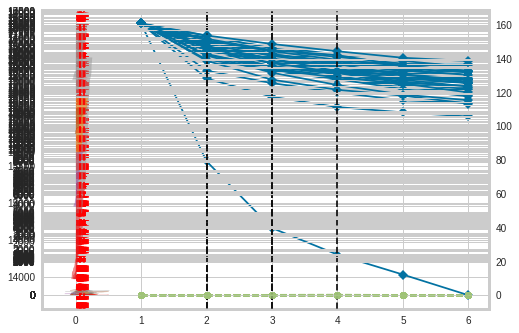

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import SpectralClustering

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



print_info_extra = False
print_info = True

mean_before = True #True

#for id, text in enumerate(train_br["gold_sense_id"]):

answers = []
answers_by_sentence_all = []

global_id = 0
for word_idx, word_list in enumerate(all_representations):

  print("----------Word number:", word_idx)

  word_list_len = len(word_list)
  if print_info_extra: print(word_list_len)
  #print(type(word_list[0]))
  #print(word_list[0].shape)
  word_labels_list = len(train_br["gold_sense_id"][global_id : (global_id + word_list_len) ])
  if print_info_extra: print(len(train_br["gold_sense_id"][global_id : (global_id + word_list_len) ]))

  #print(train_br["gold_sense_id"][global_id:word_list_len])

  assert word_list_len==word_labels_list

  for sen_id, (sentence_list, label) in enumerate(zip(word_list, train_br["gold_sense_id"][global_id : (global_id + word_list_len) ])):
    
    #print(sen_id, sentence_list.shape, label)
    

    if mean_before:
      #print(sentence_list.shape)
      sentence_list = np.mean(sentence_list, axis=0, keepdims=True)
      #print(sentence_list.shape)
    else:
      answers_by_sentence = len(sentence_list)
      #print(answers_by_sentence)
      answers_by_sentence_all.append(answers_by_sentence)








    #### K-means (or mb try Neural layer ?):

    ## Just all words as different inputs:
    if sen_id == 0:
      word_representations_all = sentence_list #((1, 1, 1, 768))

      #if (train_br.gold_sense_id[id] != train_br.gold_sense_id[id-1]):

      #sentence_representations = np.append(sentence_representations, XXX_NEW, axis=0)
      #print(sentence_representations.shape)
      
    else:
      word_representations_all = np.append(word_representations_all, sentence_list, axis=0)

    ## Mean of words from one sentence:

    #answers.append()
    global_id += 1

  if print_info: print(word_representations_all.shape)




  ### Pre-processing:
  ## Normalise
  # print("Before:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])

  # word_representations_all = normalize(word_representations_all, axis=0)
  
  # print("After:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])


  ## Standartise:
  # print("Before:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])
  
  # word_representations_all = stats.zscore(word_representations_all) #, axis=1, ddof=1)

  # print("After:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])

  ## PCA:
  #fit_transform(X, y=None)

  # if print_info_extra: print("Before:", word_representations_all.shape)
  
  # #pca = PCA(n_components=10) #(word_representations_all.shape[0] // 2 ))
  # pca = PCA(.90)

  # word_representations_all = pca.fit_transform(word_representations_all)
  # print(pca.explained_variance_ratio_)
  
  # if print_info_extra: print("After:", word_representations_all.shape)




  #print(sentence_list)
  #print(word_representations_all.shape)
  #print(np.mean(word_representations_all, axis=0, keepdims=True))


  
  ## Choose the number of clusters:
  model_e = KMeans(random_state=0)

  elb_visualizer = KElbowVisualizer(model_e, k=(1,7))
  elb_visualizer.fit(word_representations_all)
  #elb_visualizer.show()

  e_number = elb_visualizer.elbow_value_
  #if print_info_extra: 
  print("e_numb", elb_visualizer.elbow_value_)
  #print(elb_visualizer.elbow_score_)


  s_scores = []
  for clus in range(3): # 2-4 clusters
    model_s = KMeans(n_clusters = clus+2, random_state=0)
    sil_visualizer = SilhouetteVisualizer(model_s)
    sil_visualizer.fit(word_representations_all) 
    #sil_visualizer.show()

    s_scores.append(sil_visualizer.silhouette_score_)
    #if print_info_extra: 
    print("s_score", clus+2, sil_visualizer.silhouette_score_)
    #print(sil_visualizer.silhouette_samples_)

  s_scores2b = sorted(range(len(s_scores)), key = lambda sub: s_scores[sub])[-2:]
  s_scores2b = [x + 2 for x in s_scores2b] # (0..n)+2 as number of cluster

  # s_scores.sort()
  # last_index = len(s_scores) - 1
  # s_scores2b = [(last_index - 1), last_index]
  print(s_scores2b)


  if e_number:
    if (e_number in s_scores2b):
      max_val = max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2])
      min_val = min(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2])

      if ( (max_val % min_val) < (max_val*0.1) ):
        print(max_val*0.1)
        clusters_number = e_number
      else:
        s_scores2b.sort()
        clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2
    else:
      s_scores2b.sort()
      clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2

  else:
    s_scores2b.sort()
    clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2

  print("Cluster number:", clusters_number)
  


  ### K-means clustering:
  #kmeans = KMeans(n_clusters=2, random_state=0).fit(word_representations_all) #2,3,4,5 
  kmeans = KMeans(n_clusters=clusters_number, random_state=0).fit(word_representations_all) #2,3,4,5 

  #kmeans = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(word_representations_all) #2,3,4,5 
  #kmeans = KMeans(n_clusters=2, random_state=0, algorithm='full').fit(word_representations_all) #2,3,4,5 

  # kmeans = SpectralClustering(n_clusters=2, 
  #                             assign_labels='kmeans', 
  #                             random_state=0).fit(word_representations_all)
  # 'discretize', 'cluster_qr', 'kmeans'

  if print_info: print(kmeans.labels_)
  if print_info: print(len(kmeans.labels_))

  #if print_info: print(kmeans.cluster_centers_)


  answers.extend(kmeans.labels_)
  #nswers += kmeans.labels_
  #answers.append(kmeans.labels_)
  if print_info: print(len(answers))

#if print_info: print(len(answers))

print(len(answers_by_sentence_all))



if not mean_before:
  
  answers_new = []
  answer_id = 0

  for sentence in answers_by_sentence_all:

    #print(len(answers[answer_id: (answer_id + (sentence))]))
    if len(answers[answer_id: (answer_id + (sentence))]) > 1:
      list_temp = answers[answer_id: (answer_id + (sentence))]
      if print_info_extra: print(list_temp) 


      # classes = {}
      # for i in list_temp:
      #     classes[i] = list_temp.count(i)
      #print(classes)

      zeros = 0
      ones = 0
      zeros = list_temp.count(0)
      ones = list_temp.count(1)
      if print_info_extra: print(zeros, ones)

      if zeros >= ones:
        answers_new.append(0)
      elif zeros < ones:
        answers_new.append(1)
      else:
        raise Exception(f"[ERROR My] WTF ???")

      if print_info_extra: print(answers_new[-1])

    else:
      answers_new.append(answers[answer_id])


    answer_id += sentence
  
  if print_info_extra: print(len(answers_new))
  if print_info_extra: print(len(answers))

  answers = answers_new
  print(len(answers))




##### Train file

In [ ]:
#train_br['text'] = train_br.context
train_br['predict_sense_id'] = [answers[i] for i in range(train_br.shape[0])]

train_br

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,3492,акция,NaN,0,104-109,"точными сведениями осенью. Напомним, что снача...",точными сведениями осенью. напомним что сначал...
1,3493,акция,NaN,1,"6-11,79-84","пакет акций. «Все зависит от того, насколько р...",пакет акции. все зависит от того насколько реа...
2,3494,акция,NaN,1,"70-75,119-124","в ЕГРЮЛ только 5 октября 2012 года, а госрегис...",в егрюл только 5 октября 2012 года а госрегист...
3,3495,акция,NaN,1,67-72,"8%, а бумаги Дальсвязи подорожали на 4,4%. Вме...",8 а бумаги дальсвязи подорожали на 4 4 . вмест...
4,3496,акция,NaN,0,90-95,", пожилые - у нас много категорий граждан, кот...",пожилые у нас много категории граждан которым...
...,...,...,...,...,...,...,...
6551,10043,шашка,NaN,0,64-71,"1, 2, 3, 4 приведена в порядок, и при дальнейш...",1 2 3 4 приведена в порядок и при дальнеиших м...
6552,10044,шашка,NaN,1,86-91,"весело, были одеты щеголями и распоряжались ра...",весело были одеты щеголями и распоряжались раз...
6553,10045,шашка,NaN,1,103-110,"подол, как звереныши, поглядывали блестящими г...",подол как звереныши поглядывали блестящими гла...
6554,10046,шашка,NaN,1,101-106,", случавшиеся с монументом Чапаеву, у которого...",случавшиеся с монументом чапаеву у которого с...


In [ ]:
#train_br.to_csv('/content/russe-wsi-kit/data/main/bts-rnc/train_my.csv', index=False, sep='\t', encoding='utf-8')
train_br.to_csv('/content/russe-wsi-kit/data/main/bts-rnc/br_test_my_SEP_multi.csv', index=False, sep='\t', encoding='utf-8')



#path_my = '/content/russe-wsi-kit/data/main/bts-rnc/train_my.csv'
path_my = '/content/russe-wsi-kit/data/main/bts-rnc/br_test_my_SEP_multi.csv'

train_br_my = pd.read_csv(path_my, sep='\t', header=0)

In [ ]:
compression_opts = dict(method='zip', archive_name='train_my_z.csv')

train_br.to_csv('out.zip', index=False, sep='\t', encoding='utf-8', compression=compression_opts)

In [ ]:
train_br_my.head(30)

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,3492,акция,NaN,0,104-109,"точными сведениями осенью. Напомним, что снача...",точными сведениями осенью. напомним что сначал...
1,3493,акция,NaN,1,"6-11,79-84","пакет акций. «Все зависит от того, насколько р...",пакет акции. все зависит от того насколько реа...
2,3494,акция,NaN,1,"70-75,119-124","в ЕГРЮЛ только 5 октября 2012 года, а госрегис...",в егрюл только 5 октября 2012 года а госрегист...
3,3495,акция,NaN,1,67-72,"8%, а бумаги Дальсвязи подорожали на 4,4%. Вме...",8 а бумаги дальсвязи подорожали на 4 4 . вмест...
4,3496,акция,NaN,0,90-95,", пожилые - у нас много категорий граждан, кот...",пожилые у нас много категории граждан которым...
5,3497,акция,NaN,1,96-101,"сообщал «Новый Регион», Хозяйственный суд Киев...",сообщал новыи регион хозяиственныи суд киева в...
6,3498,акция,NaN,1,72-77,ансамбля из двух отелей — «Будапешт» и «Петр I...,ансамбля из двух отелеи будапешт и петр i . пр...
7,3499,акция,NaN,0,95-100,". Было бы удивительно, если бы это остановило ...",. было бы удивительно если бы это остановило в...
8,3500,акция,NaN,1,89-94,из показаний бывшего топ-менеджера «Ренессанса...,из показании бывшего топ менеджера ренессанса ...
9,3501,акция,NaN,1,83-88,судом Московского округа. ОПК в свою очередь д...,судом московского округа. опк в свою очередь д...


In [ ]:
!python3 /content/russe-wsi-kit/evaluate.py /content/russe-wsi-kit/data/main/bts-rnc/train_my.csv

word	ari	count
балка	0.458529	119
вид	0.391495	77
винт	0.216556	123
горн	0.127359	51
губа	0.010926	137
жаба	0.393018	121
клетка	0.794778	150
крыло	0.296023	91
купюра	0.023275	150
курица	0.004068	93
лавка	0.077963	149
лайка	0.083021	99
лев	-0.035531	44
лира	0.917247	49
мина	0.481596	65
мишень	0.554322	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.045367	148
полис	0.017479	142
пост	0.717630	144
поток	-0.024710	136
проказа	-0.001275	146
пропасть	0.315260	127
проспект	-0.037394	139
пытка	0.243832	143
рысь	0.284660	120
среда	0.448420	144
хвост	0.630253	121
штамп	0.529431	96
	0.268703	3491


In [ ]:
-----------###### Original (no [SEP]) #####################
word	ari	count
балка	0.458529	119
вид	0.639119	77
винт	0.228789	123
горн	0.127359	51
губа	0.001466	137
жаба	0.393018	121
клетка	0.794778	150
крыло	0.221593	91
купюра	-0.046081	150
курица	0.004068	93
лавка	0.209140	149
лайка	0.083021	99
лев	-0.035531	44
лира	0.917247	49
мина	0.526021	65
мишень	0.530044	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.045367	148
полис	0.029748	142
пост	0.743067	144
поток	0.009162	136
проказа	0.009902	146
пропасть	0.032776	127
проспект	-0.096300	139
пытка	0.224535	143
рысь	0.507083	120
среда	0.448420	144
хвост	0.605430	121
штамп	0.529431	96
	0.271597	3491



### PCA n=0.90 ##################################################
word	ari	count
балка	0.458529	119
вид	0.635494	77
винт	0.216556	123
горн	0.127359	51
губа	0.002438	137
жаба	0.393018	121
клетка	0.794778	150
крыло	0.296023	91
купюра	-0.048159	150
курица	0.004068	93
лавка	0.196811	149
лайка	0.116951	99
лев	-0.035531	44
лира	0.917247	49
мина	0.526021	65
мишень	0.530044	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.045367	148
полис	0.025684	142
пост	0.692590	144
поток	0.009162	136
проказа	0.002616	146
пропасть	0.032776	127
проспект	-0.067734	139
пытка	0.212585	143
рысь	0.531121	120
среда	0.448420	144
хвост	0.657659	121
штамп	0.529431	96
	0.274143	3491



### PCA n=0.60
word	ari	count
балка	0.481643	119
вид	0.635494	77
винт	0.216556	123
горн	0.127359	51
губа	0.003844	137
жаба	0.035043	121
клетка	0.794778	150
крыло	0.257068	91
купюра	-0.044911	150
курица	0.004068	93
лавка	0.248340	149
лайка	0.104836	99
лев	-0.035531	44
лира	0.917247	49
мина	0.526021	65
мишень	0.552365	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.048504	148
полис	0.006246	142
пост	0.692590	144
поток	0.009162	136
проказа	0.013452	146
пропасть	0.014651	127
проспект	-0.022902	139
пытка	0.224535	143
рысь	0.605715	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.529431	96
	0.267478	3491



### PCA n=0.30
word	ari	count
балка	0.435453	119
вид	0.595616	77
винт	0.216556	123
горн	0.133945	51
губа	0.002438	137
жаба	0.035043	121
клетка	0.794778	150
крыло	0.257068	91
купюра	-0.042315	150
курица	0.008612	93
лавка	0.234916	149
лайка	0.140589	99
лев	-0.048885	44
лира	0.917247	49
мина	0.526021	65
мишень	0.577266	121
обед	0.074133	100
оклад	0.410416	146
опушка	0.045367	148
полис	0.013456	142
пост	0.717630	144
поток	0.000141	136
проказа	0.012503	146
пропасть	0.063159	127
проспект	-0.096300	139
пытка	0.224535	143
рысь	0.531121	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.499804	96
	0.266228	3491



#Mean after 
word	ari	count
балка	0.554360	119
вид	0.595616	77
винт	0.059797	123
горн	0.111979	51
губа	0.003844	137
жаба	0.019559	121
клетка	0.794778	150
крыло	0.321589	91
купюра	0.083506	150
курица	0.008298	93
лавка	0.234916	149
лайка	0.105141	99
лев	-0.059707	44
лира	0.917247	49
мина	0.360744	65
мишень	0.550187	121
обед	0.082420	100
оклад	0.331119	146
опушка	0.018634	148
полис	-0.007355	142
пост	0.717630	144
поток	0.009162	136
проказа	-0.000294	146
пропасть	0.052604	127
проспект	-0.094384	139
пытка	0.201029	143
рысь	0.480271	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.499804	96
	0.257616	3491



#Mean after + PCA n=0.30
word	ari	count
балка	0.458529	119
вид	0.595616	77
винт	0.104000	123
горн	0.005108	51
губа	0.002438	137
жаба	0.035271	121
клетка	0.794778	150
крыло	0.023899	91
купюра	-0.047164	150
курица	0.008298	93
лавка	0.234916	149
лайка	0.127548	99
лев	-0.067985	44
лира	0.917247	49
мина	0.526021	65
мишень	0.525906	121
обед	0.056991	100
оклад	0.331119	146
опушка	0.048504	148
полис	-0.014288	142
пост	0.717630	144
поток	-0.008376	136
проказа	-0.002165	146
пропасть	0.063159	127
проспект	-0.065169	139
пытка	0.212585	143
рысь	0.507083	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.560025	96
	0.248320	3491


#Mean after + Var_cluster_numb #################################
word	ari	count
балка	0.459997	119
вид	0.565303	77
винт	0.059797	123
горн	0.125247	51
губа	0.009671	137
жаба	0.236356	121
клетка	0.794778	150
крыло	0.250673	91
купюра	0.083506	150
курица	0.020274	93
лавка	0.217598	149
лайка	0.105141	99
лев	-0.007301	44
лира	0.917247	49
мина	0.360744	65
мишень	0.550187	121
обед	0.082420	100
оклад	0.331119	146
опушка	0.018634	148
полис	-0.007355	142
пост	0.717630	144
поток	-0.045943	136
проказа	-0.000294	146
пропасть	0.291100	127
проспект	0.002114	139
пытка	0.201029	143
рысь	0.480271	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.499804	96
	0.270432	3491


#Mean after + Var_cluster_numb + PCA n=0.90
word	ari	count
балка	0.435995	119
вид	0.387487	77
винт	0.067006	123
горн	-0.043355	51
губа	-0.013348	137
жаба	0.256561	121
клетка	0.794778	150
крыло	0.250673	91
купюра	0.051655	150
курица	0.020274	93
лавка	0.217598	149
лайка	0.070440	99
лев	0.086598	44
лира	0.917247	49
мина	0.526021	65
мишень	0.481370	121
обед	0.087049	100
оклад	0.331119	146
опушка	0.033935	148
полис	0.016668	142
пост	0.717630	144
поток	-0.022622	136
проказа	0.001923	146
пропасть	0.248047	127
проспект	-0.006124	139
пытка	0.212585	143
рысь	0.506093	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.420727	96
	0.262854	3491



# Original + Var_cluster_numb #################################
word	ari	count
балка	0.458529	119
вид	0.550595	77
винт	0.228789	123
горн	0.127359	51
губа	0.013493	137
жаба	0.393018	121
клетка	0.794778	150
крыло	0.221593	91
купюра	0.023275	150
курица	0.004068	93
лавка	0.134583	149
лайка	0.083021	99
лев	-0.035531	44
лира	0.917247	49
мина	0.526021	65
мишень	0.530044	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.045367	148
полис	0.029748	142
пост	0.743067	144
поток	-0.028182	136
проказа	0.009902	146
пропасть	0.295606	127
проспект	-0.043385	139
пытка	0.224535	143
рысь	0.277610	120
среда	0.448420	144
хвост	0.605430	121
штамп	0.529431	96
	0.272240	3491



# Original + Var_cluster_numb + PCA n=0.95
word	ari	count
балка	0.458529	119
вид	0.391495	77
винт	0.216556	123
горн	0.127359	51
губа	0.010926	137
жаба	0.393018	121
клетка	0.794778	150
крыло	0.296023	91
купюра	0.023275	150
курица	0.004068	93
лавка	0.077963	149
лайка	0.083021	99
лев	-0.035531	44
лира	0.917247	49
мина	0.481596	65
мишень	0.554322	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.045367	148
полис	0.017479	142
пост	0.717630	144
поток	-0.024710	136
проказа	-0.001275	146
пропасть	0.315260	127
проспект	-0.037394	139
пытка	0.243832	143
рысь	0.284660	120
среда	0.448420	144
хвост	0.630253	121
штамп	0.529431	96
	0.268703	3491

# Original + Var_cluster_numb + PCA n=0.90 #################################
word	ari	count
балка	0.458529	119
вид	0.635494	77
винт	0.216556	123
горн	0.127359	51
губа	-0.015058	137
жаба	0.393018	121
клетка	0.794778	150
крыло	0.296023	91
купюра	0.090270	150
курица	0.004068	93
лавка	0.230273	149
лайка	0.116951	99
лев	-0.035531	44
лира	0.917247	49
мина	0.526021	65
мишень	0.530044	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.045367	148
полис	0.025684	142
пост	0.692590	144
поток	-0.036511	136
проказа	0.002616	146
пропасть	0.233417	127
проспект	-0.033952	139
пытка	0.212585	143
рысь	0.368054	120
среда	0.448420	144
хвост	0.657659	121
штамп	0.529431	96
	0.282093	3491



# Original + Var_cluster_numb + PCA n=0.60
word	ari	count
балка	0.481643	119
вид	0.635494	77
винт	0.216556	123
горн	0.127359	51
губа	-0.011226	137
жаба	0.258206	121
клетка	0.794778	150
крыло	0.257068	91
купюра	0.025229	150
курица	0.004068	93
лавка	0.230273	149
лайка	0.104836	99
лев	0.012550	44
лира	0.917247	49
мина	0.526021	65
мишень	0.552365	121
обед	0.066725	100
оклад	0.331119	146
опушка	0.048504	148
полис	0.006246	142
пост	0.692590	144
поток	-0.036788	136
проказа	0.013452	146
пропасть	0.265080	127
проспект	-0.021659	139
пытка	0.224535	143
рысь	0.302543	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.529431	96
	0.274419	3491


# Original + Var_cluster_numb + PCA n=0.30
word	ari	count
балка	0.435453	119
вид	0.355372	77
винт	0.081522	123
горн	0.125515	51
губа	-0.014789	137
жаба	0.307740	121
клетка	0.794778	150
крыло	0.257068	91
купюра	0.026678	150
курица	0.008612	93
лавка	0.239320	149
лайка	0.140589	99
лев	0.017154	44
лира	0.917247	49
мина	0.526021	65
мишень	0.577266	121
обед	0.074133	100
оклад	0.410416	146
опушка	-0.006622	148
полис	0.004682	142
пост	0.386440	144
поток	-0.024736	136
проказа	0.012503	146
пропасть	0.254733	127
проспект	-0.004456	139
пытка	0.067219	143
рысь	0.321280	120
среда	0.448420	144
хвост	0.633753	121
штамп	0.272719	96
	0.242341	3491






-----------###### with [SEP]:
word	ari	count
балка	0.351146	119
вид	0.680318	77
винт	0.192357	123
горн	0.106890	51
губа	-0.007513	137
жаба	0.011759	121
клетка	0.760188	150
крыло	0.238850	91
купюра	0.095099	150
курица	0.011271	93
лавка	0.069021	149
лайка	0.013926	99
лев	-0.028082	44
лира	0.760315	49
мина	0.324282	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.355459	146
опушка	0.023275	148
полис	0.015036	142
пост	0.643696	144
поток	-0.016413	136
проказа	-0.004074	146
пропасть	0.074143	127
проспект	-0.015640	139
пытка	0.068248	143
рысь	0.466836	120
среда	0.424963	144
хвост	0.690839	121
штамп	0.443468	96
	0.235156	3491



### Standardise:
word	ari	count
балка	0.481643	119
вид	0.680318	77
винт	0.179867	123
горн	0.047549	51
губа	-0.001713	137
жаба	0.011759	121
клетка	0.719051	150
крыло	0.238850	91
купюра	0.072607	150
курица	0.011271	93
лавка	0.076737	149
лайка	-0.004776	99
лев	-0.018000	44
лира	0.760315	49
мина	0.289591	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.339008	146
опушка	0.027443	148
полис	0.003650	142
пост	0.596376	144
поток	-0.016413	136
проказа	-0.005638	146
пропасть	0.074143	127
проспект	-0.043244	139
пытка	0.076821	143
рысь	0.458436	120
среда	0.424963	144
хвост	0.601643	121
штамп	0.494509	96
	0.229354	3491


### Normilise:
word	ari	count
балка	0.529552	119
вид	0.680318	77
винт	0.029654	123
горн	0.106890	51
губа	0.002321	137
жаба	0.011759	121
клетка	0.719051	150
крыло	0.238850	91
купюра	0.023181	150
курица	-0.000910	93
лавка	0.084750	149
лайка	-0.063139	99
лев	-0.018000	44
лира	0.760315	49
мина	0.114998	65
мишень	0.604730	121
обед	0.066725	100
оклад	0.295569	146
опушка	0.023275	148
полис	0.003650	142
пост	0.643696	144
поток	-0.012453	136
проказа	-0.004867	146
пропасть	-0.006925	127
проспект	-0.065874	139
пытка	0.068248	143
рысь	0.490296	120
среда	0.424963	144
хвост	0.601643	121
штамп	0.471148	96
	0.219013	3491


### PCA n//2
word	ari	count
балка	0.331272	119
вид	0.680318	77
винт	0.192357	123
горн	0.106890	51
губа	-0.001713	137
жаба	0.011759	121
клетка	0.760188	150
крыло	0.235427	91
купюра	0.089212	150
курица	-0.000910	93
лавка	0.069021	149
лайка	0.009494	99
лев	-0.035531	44
лира	0.760315	49
мина	0.360744	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.333304	146
опушка	0.025312	148
полис	0.006246	142
пост	0.643696	144
поток	-0.004179	136
проказа	-0.005956	146
пропасть	0.122405	127
проспект	-0.024189	139
пытка	0.068248	143
рысь	0.545699	120
среда	0.424963	144
хвост	0.574087	121
штамп	0.471148	96
	0.234539	3491



### PCA n=10
word	ari	count
балка	0.351146	119
вид	0.680318	77
винт	0.179867	123
горн	0.246769	51
губа	-0.005700	137
жаба	0.004980	121
клетка	0.768479	150
крыло	0.236742	91
купюра	0.089212	150
курица	0.004068	93
лавка	0.069021	149
лайка	0.005601	99
лев	-0.028082	44
лира	0.760315	49
мина	0.256600	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.295569	146
опушка	0.023275	148
полис	0.006246	142
пост	0.692590	144
поток	-0.012453	136
проказа	-0.003689	146
пропасть	0.097406	127
проспект	-0.028767	139
пытка	0.051818	143
рысь	0.600415	120
среда	0.424963	144
хвост	0.547535	121
штамп	0.471148	96
	0.234317	3491  



### PCA n=0.90 ##################################################
word	ari	count
балка	0.351146	119
вид	0.680318	77
винт	0.192357	123
горн	0.106890	51
губа	-0.001713	137
жаба	0.008566	121
клетка	0.760188	150
крыло	0.236742	91
купюра	0.089212	150
курица	0.011271	93
лавка	0.069021	149
лайка	0.004893	99
лев	-0.048885	44
лира	0.760315	49
мина	0.324282	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.355459	146
опушка	0.025312	148
полис	0.007602	142
пост	0.643696	144
поток	-0.016413	136
проказа	-0.004074	146
пропасть	0.149156	127
проспект	-0.024189	139
пытка	0.051818	143
рысь	0.545699	120
среда	0.424963	144
хвост	0.574087	121
штамп	0.471148	96
	0.235371	3491



### PCA n=0.95
word	ari	count
балка	0.351192	119
вид	0.680318	77
винт	0.192357	123
горн	0.106890	51
губа	-0.001839	137
жаба	0.008566	121
клетка	0.760188	150
крыло	0.274296	91
купюра	0.095099	150
курица	0.011271	93
лавка	0.069021	149
лайка	0.009494	99
лев	-0.028082	44
лира	0.760315	49
мина	0.324282	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.295569	146
опушка	0.025312	148
полис	0.018353	142
пост	0.643696	144
поток	-0.016413	136
проказа	-0.004588	146
пропасть	0.042476	127
проспект	-0.015640	139
пытка	0.068248	143
рысь	0.466836	120
среда	0.424963	144
хвост	0.574087	121
штамп	0.443468	96
	0.228564	3491



### PCA n=0.60 ####################################################
word	ari	count
балка	0.351146	119
вид	0.680318	77
винт	0.179867	123
горн	0.209156	51
губа	-0.006634	137
жаба	0.015804	121
клетка	0.760188	150
крыло	0.236742	91
купюра	0.095099	150
курица	0.004068	93
лавка	0.084691	149
лайка	0.009494	99
лев	-0.011193	44
лира	0.760315	49
мина	0.324282	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.295569	146
опушка	0.023275	148
полис	0.008999	142
пост	0.667946	144
поток	-0.012453	136
проказа	-0.003689	146
пропасть	0.052604	127
проспект	-0.024609	139
пытка	0.068248	143
рысь	0.600415	120
среда	0.424963	144
хвост	0.547535	121
штамп	0.443468	96
	0.233798	3491



### PCA n=0.30 ##########################################################
word	ari	count
балка	0.351146	119
вид	0.639119	77
винт	0.179867	123
горн	0.035491	51
губа	0.001158	137
жаба	0.004980	121
клетка	0.768479	150
крыло	0.236742	91
купюра	0.089212	150
курица	-0.000910	93
лавка	0.084691	149
лайка	0.009494	99
лев	-0.018000	44
лира	0.760315	49
мина	0.256600	65
мишень	0.520821	121
обед	0.066725	100
оклад	0.350334	146
опушка	0.023275	148
полис	0.008999	142
пост	0.692590	144
поток	-0.012453	136
проказа	-0.004867	146
пропасть	0.149156	127
проспект	-0.020234	139
пытка	0.068248	143
рысь	0.600415	120
среда	0.402142	144
хвост	0.547535	121
штамп	0.471148	96
	0.235672	3491  



### PCA n=0.20
word	ari	count
балка	0.371548	119
вид	0.680318	77
винт	0.192357	123
горн	0.035491	51
губа	-0.005700	137
жаба	-0.001489	121
клетка	0.719051	150
крыло	0.236742	91
купюра	0.089212	150
курица	-0.007039	93
лавка	0.150915	149
лайка	0.002239	99
лев	-0.048885	44
лира	0.760315	49
мина	0.324282	65
мишень	0.520821	121
обед	0.074133	100
оклад	0.350334	146
опушка	0.029674	148
полис	0.011924	142
пост	0.643696	144
поток	-0.020259	136
проказа	-0.003689	146
пропасть	0.135560	127
проспект	-0.032288	139
пытка	0.051818	143
рысь	0.550840	120
среда	0.379961	144
хвост	0.521942	121
штамп	0.443468	96
	0.230843	3491



### Mean after
word	ari	count
балка	0.292843	119
вид	0.680318	77
винт	0.021434	123
горн	-0.000984	51
губа	-0.003666	137
жаба	0.000598	121
клетка	0.760188	150
крыло	0.235427	91
купюра	0.057459	150
курица	0.061339	93
лавка	0.076610	149
лайка	0.009494	99
лев	0.010144	44
лира	0.760315	49
мина	0.289591	65
мишень	0.547782	121
обед	0.056991	100
оклад	0.279492	146
опушка	0.025312	148
полис	0.013456	142
пост	0.692590	144
поток	0.009162	136
проказа	-0.006121	146
пропасть	0.109687	127
проспект	-0.053041	139
пытка	0.068248	143
рысь	0.524648	120
среда	0.424963	144
хвост	0.547535	121
штамп	0.471148	96
	0.223009	3491



### Mean after + PCA n=0.30 
word	ari	count
балка	0.292843	119
вид	0.680318	77
винт	0.046176	123
горн	0.212537	51
губа	0.002321	137
жаба	0.008018	121
клетка	0.760188	150
крыло	0.255110	91
купюра	0.089212	150
курица	0.066375	93
лавка	0.076676	149
лайка	-0.006064	99
лев	-0.035531	44
лира	0.760315	49
мина	0.256600	65
мишень	0.494221	121
обед	0.056991	100
оклад	0.324783	146
опушка	0.023275	148
полис	-0.014288	142
пост	0.692590	144
поток	-0.016413	136
проказа	-0.003433	146
пропасть	0.135560	127
проспект	-0.032288	139
пытка	0.094697	143
рысь	0.518986	120
среда	0.379961	144
хвост	0.521942	121
штамп	0.443468	96
	0.224966	3491

##### Test file:

In [ ]:
path_test = '/content/russe-wsi-kit/data/main/bts-rnc/test.csv'

test_br = pd.read_csv(path_test, sep='\t', header=0)

In [ ]:
test_br.head(10)

In [ ]:
test_br['predict_sense_id'] = [answers[i] for i in range(test_br.shape[0])]

test_br

In [ ]:
test_br_my.to_csv('/content/russe-wsi-kit/data/main/bts-rnc/test_my.csv', index=False, sep='\t', encoding='utf-8')


path_my = '/content/russe-wsi-kit/data/main/bts-rnc/test_my.csv'

test_br_my = pd.read_csv(path_my, sep='\t', header=0)

In [ ]:
test_br_my.head(10)

####Wiki-Wiki

----------Word number: 0
(112, 768)
[0.10915298 0.0701125  0.06652663 0.05953938 0.05067892 0.04406162
 0.03250803 0.03109774 0.02770635 0.02482077 0.02292648 0.0192858
 0.01910653 0.01637677 0.01509491 0.01408101 0.01333051 0.01302094
 0.01291814 0.0118843  0.01098927 0.01073806 0.01026572 0.00996226
 0.00982345 0.00912969 0.00883307 0.00867977 0.00832009 0.00822815
 0.00795769 0.00772312 0.00719994 0.00691301 0.00682406 0.00663021
 0.00644259 0.00601007 0.0059028  0.00588322 0.00581307 0.00551139
 0.00519815 0.00514738 0.00493231 0.00487075 0.00467007 0.00449189
 0.00446047 0.00419719 0.00406598 0.00392278 0.00389046 0.00383256]


/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.11309529
s_score 3 0.09535839
s_score 4 0.09903921
[4, 2]
Cluster number: 2
[0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0
 0]
112
112
----------Word number: 1
(135, 768)
[0.20888743 0.09943613 0.06636869 0.06073705 0.03154711 0.03048676
 0.02543027 0.02255419 0.01896483 0.01729956 0.01563815 0.01486505
 0.01424877 0.01338859 0.01255814 0.01191283 0.01161622 0.01011231
 0.00994303 0.00993534 0.00960778 0.00859651 0.00838392 0.0081942
 0.00740265 0.00721699 0.00707778 0.00699856 0.00672859 0.00645247
 0.00633979 0.00616216 0.00587522 0.00553815 0.0054641  0.00537861
 0.00527849 0.00511707 0.00496111 0.00486477 0.00464553 0.00457485
 0.00447952 0.00436784 0.00425822 0.00406543 0.00394185 0.00387834
 0.00373448 0.00360809 0.00351724 0.00346365 0.0034191  0.00331298
 0.00320847 0.00314653 0.

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


e_numb None
s_score 2 0.10384301
s_score 3 0.1298912
s_score 4 0.13825229
[3, 4]
Cluster number: 4
[0 1 0 1 2 0 0 0 2 1 2 0 3 0 1 0 0 2 0 3 1 0 0 1 2 1 1 2 1 3 1 0 0 1 1 2 2
 1 0 1 0 1 1 1 3 2 3 3 1 3 0 0 0 0 2 1 0 0 2 1 2 2 0 2 2 0 1 1 0 1 0 1 1 1
 0 1 3 0 1]
79
618
0


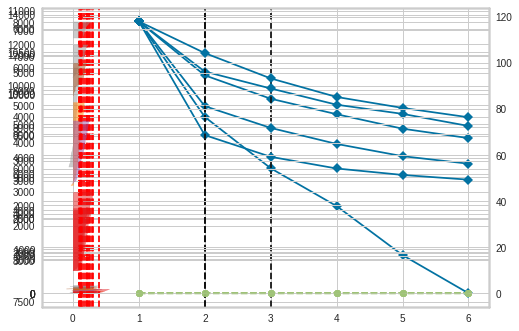

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import SpectralClustering

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



print_info_extra = False
print_info = True

mean_before = True #True


answers = []
answers_by_sentence_all = []

global_id = 0
for word_idx, word_list in enumerate(all_representations):

  print("----------Word number:", word_idx)

  word_list_len = len(word_list)
  if print_info_extra: print(word_list_len)
  #print(type(word_list[0]))
  #print(word_list[0].shape)

  word_labels_list = len(train_ww["gold_sense_id"][global_id : (global_id + word_list_len) ])
  if print_info_extra: print(len(train_ww["gold_sense_id"][global_id : (global_id + word_list_len) ]))
  # word_labels_list = len(train_br["gold_sense_id"][global_id : (global_id + word_list_len) ])
  # if print_info_extra: print(len(train_br["gold_sense_id"][global_id : (global_id + word_list_len) ]))

  assert word_list_len==word_labels_list

  for sen_id, (sentence_list, label) in enumerate(zip(word_list, train_ww["gold_sense_id"][global_id : (global_id + word_list_len) ])):
  #for sen_id, (sentence_list, label) in enumerate(zip(word_list, train_br["gold_sense_id"][global_id : (global_id + word_list_len) ])):
    
    #print(sen_id, sentence_list.shape, label)
    

    if mean_before:
      #print(sentence_list.shape)
      sentence_list = np.mean(sentence_list, axis=0, keepdims=True)
      #print(sentence_list.shape)
    else:
      answers_by_sentence = len(sentence_list)
      #print(answers_by_sentence)
      answers_by_sentence_all.append(answers_by_sentence)





    #### K-means (or mb try Neural layer ?):

    ## Just all words as different inputs:
    if sen_id == 0:
      word_representations_all = sentence_list #((1, 1, 1, 768))

      
    else:
      word_representations_all = np.append(word_representations_all, sentence_list, axis=0)

    ## Mean of words from one sentence:

    #answers.append()
    global_id += 1

  if print_info: print(word_representations_all.shape)




  ### Pre-processing:
  ## Normalise
  # print("Before:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])

  # word_representations_all = normalize(word_representations_all, axis=0)
  
  # print("After:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])


  ## Standartise:
  # print("Before:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])
  
  # word_representations_all = stats.zscore(word_representations_all) #, axis=1, ddof=1)

  # print("After:", word_representations_all.mean(axis=0, keepdims=True))
  # print(word_representations_all[0])

  ## PCA:
  #fit_transform(X, y=None)

  if print_info_extra: print("Before:", word_representations_all.shape)
  
  #pca = PCA(n_components=10) #(word_representations_all.shape[0] // 2 ))
  pca = PCA(.90)

  word_representations_all = pca.fit_transform(word_representations_all)
  print(pca.explained_variance_ratio_)
  
  if print_info_extra: print("After:", word_representations_all.shape)




  #print(sentence_list)
  #print(word_representations_all.shape)
  #print(np.mean(word_representations_all, axis=0, keepdims=True))


  
  ## Choose the number of clusters:
  model_e = KMeans(random_state=0)

  elb_visualizer = KElbowVisualizer(model_e, k=(1,7))
  elb_visualizer.fit(word_representations_all)
  #elb_visualizer.show()

  e_number = elb_visualizer.elbow_value_
  #if print_info_extra: 
  print("e_numb", elb_visualizer.elbow_value_)
  #print(elb_visualizer.elbow_score_)


  s_scores = []
  for clus in range(3): # 2-4 clusters
    model_s = KMeans(n_clusters = clus+2, random_state=0)
    sil_visualizer = SilhouetteVisualizer(model_s)
    sil_visualizer.fit(word_representations_all) 
    #sil_visualizer.show()

    s_scores.append(sil_visualizer.silhouette_score_)
    #if print_info_extra: 
    print("s_score", clus+2, sil_visualizer.silhouette_score_)
    #print(sil_visualizer.silhouette_samples_)

  s_scores2b = sorted(range(len(s_scores)), key = lambda sub: s_scores[sub])[-2:]
  s_scores2b = [x + 2 for x in s_scores2b] # (0..n)+2 as number of cluster

  # s_scores.sort()
  # last_index = len(s_scores) - 1
  # s_scores2b = [(last_index - 1), last_index]
  print(s_scores2b)


  if e_number:
    if (e_number in s_scores2b):
      max_val = max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2])
      min_val = min(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2])

      if ( (max_val % min_val) < (max_val*0.1) ):
        print(max_val*0.1)
        clusters_number = e_number
      else:
        s_scores2b.sort()
        clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2
    else:
      s_scores2b.sort()
      clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2

  else:
    s_scores2b.sort()
    clusters_number = s_scores.index( max(s_scores[s_scores2b[0] - 2], s_scores[s_scores2b[1] - 2]) ) + 2

  print("Cluster number:", clusters_number)
  


  ### K-means clustering:
  #kmeans = KMeans(n_clusters=2, random_state=0).fit(word_representations_all) #2,3,4,5 
  kmeans = KMeans(n_clusters=clusters_number, random_state=0).fit(word_representations_all) #2,3,4,5 

  #kmeans = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(word_representations_all) #2,3,4,5 
  #kmeans = KMeans(n_clusters=2, random_state=0, algorithm='full').fit(word_representations_all) #2,3,4,5 

  # kmeans = SpectralClustering(n_clusters=2, 
  #                             assign_labels='kmeans', 
  #                             random_state=0).fit(word_representations_all)
  # 'discretize', 'cluster_qr', 'kmeans'

  if print_info: print(kmeans.labels_)
  if print_info: print(len(kmeans.labels_))

  #if print_info: print(kmeans.cluster_centers_)


  answers.extend(kmeans.labels_)
  #nswers += kmeans.labels_
  #answers.append(kmeans.labels_)
  if print_info: print(len(answers))

#if print_info: print(len(answers))

print(len(answers_by_sentence_all))



if not mean_before:
  
  answers_new = []
  answer_id = 0

  for sentence in answers_by_sentence_all:

    #print(len(answers[answer_id: (answer_id + (sentence))]))
    if len(answers[answer_id: (answer_id + (sentence))]) > 1:
      list_temp = answers[answer_id: (answer_id + (sentence))]
      if print_info_extra: print(list_temp) 


      # classes = {}
      # for i in list_temp:
      #     classes[i] = list_temp.count(i)
      #print(classes)

      zeros = 0
      ones = 0
      zeros = list_temp.count(0)
      ones = list_temp.count(1)
      if print_info_extra: print(zeros, ones)

      if zeros >= ones:
        answers_new.append(0)
      elif zeros < ones:
        answers_new.append(1)
      else:
        raise Exception(f"[ERROR My] WTF ???")

      if print_info_extra: print(answers_new[-1])

    else:
      answers_new.append(answers[answer_id])


    answer_id += sentence
  
  if print_info_extra: print(len(answers_new))
  if print_info_extra: print(len(answers))

  answers = answers_new
  print(len(answers))




###### Old clustering:

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

print_info = False

#for id, text in enumerate(train_ww["gold_sense_id"]):

answers = []

global_id = 0
for word_list in all_representations:

  word_list_len = len(word_list)
  if print_info: print(word_list_len)
  #print(type(word_list[0]))
  #print(word_list[0].shape)
  word_labels_list = len(train_ww["gold_sense_id"][global_id : (global_id + word_list_len) ])
  if print_info: print(len(train_ww["gold_sense_id"][global_id : (global_id + word_list_len) ]))

  #print(train_ww["gold_sense_id"][global_id:word_list_len])

  assert word_list_len==word_labels_list

  for sen_id, (sentence_list, label) in enumerate(zip(word_list, train_ww["gold_sense_id"][global_id : (global_id + word_list_len) ])):
    
    #print(sen_id, sentence_list.shape, label)
    

    ### Pre-processing:
    ## Normalise
    ## PCA

    #print(sentence_list.shape)
    sentence_list = np.mean(sentence_list, axis=0, keepdims=True)
    #print(sentence_list.shape)

    #### K-means / KNN / Neural layer

    ## Just all words as different inputs:
    if sen_id == 0:
      word_representations_all = sentence_list #((1, 1, 1, 768))
      #if (train_ww.gold_sense_id[id] != train_ww.gold_sense_id[id-1]):

      #sentence_representations = np.append(sentence_representations, XXX_NEW, axis=0)
      #print(sentence_representations.shape)
      
    else:
      word_representations_all = np.append(word_representations_all, sentence_list, axis=0)

    ## Mean of words from one sentence:

    #answers.append()
    global_id += 1

  print(word_representations_all.shape)

  kmeans = KMeans(n_clusters=2, random_state=0).fit(word_representations_all)

  print(kmeans.labels_)
  print(len(kmeans.labels_))

  print(kmeans.cluster_centers_)


  answers.extend(kmeans.labels_)
  #nswers += kmeans.labels_
  #answers.append(kmeans.labels_)
  print(len(answers))

print(len(answers))

# >>> X = np.array([[1, 2], [1, 4], [1, 0],
# ...               [10, 2], [10, 4], [10, 0]])
# >>> kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# >>> kmeans.labels_
# array([1, 1, 1, 0, 0, 0], dtype=int32)
# >>> kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)
# >>> kmeans.cluster_centers_
# array([[10.,  2.],
#        [ 1.,  2.]])



(138, 768)
[0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0
 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
138
[[ 0.21412508 -0.7602949   0.16394542 ...  0.25909725  0.4382007
  -0.173175  ]
 [ 0.21241593 -0.6044675   0.4236911  ...  0.25168285  0.25931486
  -0.26208782]]
138
(110, 768)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
110
[[ 0.11567131 -0.4672461   0.8155403  ...  0.13259245  0.07686578
  -0.19115189]
 [ 0.1309267  -0.18631722  0.9776833  ... -0.26348737  0.23803203
  -0.04256398]]
248
(135, 768)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

##### Train file

In [ ]:
#train_ww['text'] = train_ww.context
train_ww['predict_sense_id'] = [answers[i] for i in range(train_ww.shape[0])]

train_ww

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,440,банка,NaN,0,"7-12,36-41",здание банка китая ( макао ) здание банка кита...,здание банка китая макао здание банка китая ba...
1,441,банка,NaN,1,"201-206,154-159,429-434,13-18",трехлитровая банка во времена ссср такие банки...,трехлитровая банка во времена ссср такие банки...
2,442,банка,NaN,0,"58-63,21-26,263-268,101-106",здание национального банка украины в здании на...,здание национального банка украины в здании на...
3,443,банка,NaN,0,"261-266,343-348,134-139",зюдфиртель города эссен ( федеральная земля се...,зюдфиртель города эссен федеральная земля севе...
4,444,банка,NaN,0,"43-48,521-526,300-307,381-386",ведения боевых действий полевые учреждения бан...,ведения боевых деиствии полевые учреждения бан...
...,...,...,...,...,...,...,...
613,1073,душ,NaN,0,"324-327,404-407","вайзард . по стечению обстоятельств , ичиго ку...",ваизард . по стечению обстоятельств ичиго куро...
614,1074,душ,NaN,1,286-289,подлые способности . использовал его дважды — ...,подлые способности . использовал его дважды во...
615,1075,душ,NaN,3,260-263,"ему было более шестидесяти лет , и это сочинен...",ему было более шестидесяти лет и это сочинение...
616,1076,душ,NaN,0,"436-439,565-568,323-326",имеет начиненные ядом лезвия у подбородка с ме...,имеет начиненные ядом лезвия у подбородка с ме...


In [ ]:
#train_ww.to_csv('/content/russe-wsi-kit/data/main/wiki-wiki/train_my.csv', index=False, sep='\t', encoding='utf-8')
train_ww.to_csv('/content/russe-wsi-kit/data/main/wiki-wiki/ww_test_my_noSEP_multi_pca90.csv', index=False, sep='\t', encoding='utf-8')


#path_my = '/content/russe-wsi-kit/data/main/wiki-wiki/train_my.csv'
path_my = '/content/russe-wsi-kit/data/main/wiki-wiki/ww_test_my_noSEP_multi_pca90.csv'

train_ww_my = pd.read_csv(path_my, sep='\t', header=0)

In [ ]:
compression_opts = dict(method='zip', archive_name='train_my_z.csv')

train_ww.to_csv('out.zip', index=False, sep='\t', encoding='utf-8', compression=compression_opts)

In [ ]:
train_ww_my.head(30)

,context_id,word,gold_sense_id,predict_sense_id,positions,context,text
0,440,банка,NaN,0,"7-12,36-41",здание банка китая ( макао ) здание банка кита...,здание банка китая макао здание банка китая ba...
1,441,банка,NaN,1,"201-206,154-159,429-434,13-18",трехлитровая банка во времена ссср такие банки...,трехлитровая банка во времена ссср такие банки...
2,442,банка,NaN,0,"58-63,21-26,263-268,101-106",здание национального банка украины в здании на...,здание национального банка украины в здании на...
3,443,банка,NaN,0,"261-266,343-348,134-139",зюдфиртель города эссен ( федеральная земля се...,зюдфиртель города эссен федеральная земля севе...
4,444,банка,NaN,0,"43-48,521-526,300-307,381-386",ведения боевых действий полевые учреждения бан...,ведения боевых деиствии полевые учреждения бан...
5,445,банка,NaN,1,"19-24,88-93,11-16","вачусетт ( банка ) банка вачусетт , "" риф вачу...",вачусетт банка банка вачусетт риф вачусетт фан...
6,446,банка,NaN,0,"292-297,204-209",— годах подпольной типографией союза вооруженн...,годах подпольнои типографиеи союза вооруженно...
7,447,банка,NaN,0,"379-384,43-48,331-336","директоров , который возглавляет президент бан...",директоров которыи возглавляет президент банка...
8,448,банка,NaN,1,"303-308,284-289",- электроходом обь в огромной африканско - ант...,электроходом обь в огромнои африканско антарк...
9,449,банка,NaN,1,193-198,составлял около т . в году общая ориентировочн...,составлял около т . в году общая ориентировочн...


In [ ]:
!python3 /content/russe-wsi-kit/evaluate.py /content/russe-wsi-kit/data/main/wiki-wiki/train_my.csv

word	ari	count
бор	0.853910	56
замок	-0.027006	138
лук	0.892788	110
суда	1.000000	135
	0.631660	439


In [ ]:
------ ### Original (no SEP)

# Original (no SEP) 2c


# Original (no SEP) + Multi


# Original (no SEP) + Multi + PCA n=90



------ ### Original (with SEP)




------ ### with unknown
word	ari	count
бор	0.853910	56
замок	-0.027006	138
лук	0.892788	110
суда	1.000000	135
	0.631660	439



------ ### baseline:
word	ari	count
бор	0.591175	56
замок	0.495386	138
лук	0.637076	110
суда	0.005465	135
	0.392449	439

##### Test file:

In [ ]:
path_test = '/content/russe-wsi-kit/data/main/active-dict/test.csv'

test_ww = pd.read_csv(path_test, sep='\t', header=0)

In [ ]:
test_ww.head(10)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,2074,давление,NaN,NaN,0-8,Давление пара создается движением поршня в цил...
1,2075,давление,NaN,NaN,13-21,"«У тебя что, давление поднялось?» Я сказал, чт..."
2,2076,давление,NaN,NaN,56-64,Я жалуюсь Никоновичу наконец на головокружение...
3,2077,давление,NaN,NaN,0-8,Давление в котле не менялось
4,2078,давление,NaN,NaN,25-33,Он каждые два часа мерил давление и сахар в крови
5,2079,давление,NaN,NaN,178-186,"Узор, образованный гранатами, […] свидетельств..."
6,2080,давление,NaN,NaN,18-27,обработка металла давлением
7,2081,давление,NaN,NaN,30-38,На директора оказывали грубое давление
8,2082,давление,NaN,NaN,50-58,На моего подзащитного оказывается психологичес...
9,2083,давление,NaN,NaN,21-29,Из-за неравномерного давления снега на стенки ...


In [ ]:
test_ww['predict_sense_id'] = [answers[i] for i in range(test_ww.shape[0])]

test_ww

In [ ]:
test_ww_my.to_csv('/content/russe-wsi-kit/data/main/wiki-wiki/test_my.csv', index=False, sep='\t', encoding='utf-8')


path_my = '/content/russe-wsi-kit/data/main/wiki-wiki/test_my.csv'

test_ww_my = pd.read_csv(path_my, sep='\t', header=0)

In [ ]:
test_ww_my.head(10)